# Drzewa Wzmacniane Gradientowo

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from helpers import Node


## Zadanie 1
W tym zadaniu będziesz implementował algorytm Gradient Boosting Trees dla problemu regresji. Aby zaimplementować ten algorytm dostępny jest obiekt `Node` implementujący drzewo regresyjne. Jest to odpowiednio dostosowany obiekt, który implementowałeś w pierwszym zadaniu domowym. Możesz wykorzystać swoją własną implementację (i dostosować ją wg. opisu poniżej) lub skorzystać z implementacji w pliku `helpers`.

W stosunku do poprzedniej implementacji obiekt ma pewne dodatkowe cechy, które umożliwią sprawniejszą implementację:
- W konstruktorze `Node` jest teraz jeden obowiązkowy argument `calculate_leaf_value`, do którego należy wstawić funkcję, która jest wywoływana przez algorytm w momencie tworzenia liścia celem obliczenia jego wartości. W standardowym drzewie regresji algorytm tworzący liść oblicza jego wartość jako średnią wartość jego elementów. Jeśli chcielibyśmy uzyskać takie działanie, powinniśmy zaimplementować następującą funkcję:

```python
def mean_val_leaf(X, y, last_predicted):
    return np.mean(y)

tree = Node(calculate_leaf_value=mean_val_leaf)
```
Zwróć uwagę na parametry funkcji tworzącej liść: `X`, `y` charakteryzujące obiekty w liściu oraz `last_predicted` przechowujące aktualną predykcję klasyfikatora dla tych obiektów. Poprzez aktualną predykcję rozumiemy tu predykcję uzyskaną wszystkimi dotychczas stworzonymi klasyfikatorami bazowymi w GBT (czyli wynik osiągnięty pozostałymi drzewami niż to tworzone). Argument `last_predicted` na chwilę obecną wydaje się niepotrzebny, lecz będzie on potrzebny do realizacji zadania.

- Dodatkowe argumenty obsługuje też funkcja ucząca model `fit(X, y, last_predicted, max_depth = None)` - która dostaje na wejście wcześniej wspomniane `last_predicted` oraz argument `max_depth` wstrzymujący budowę zbyt głębokich drzew. Innych mechanizmów pruningu niezaimplementowano, jeśli jednak takowe istnieją w Twojej implementacji, możesz je wykorzystać.

Stwórz zbiór danych do regresji poniższym kodem:

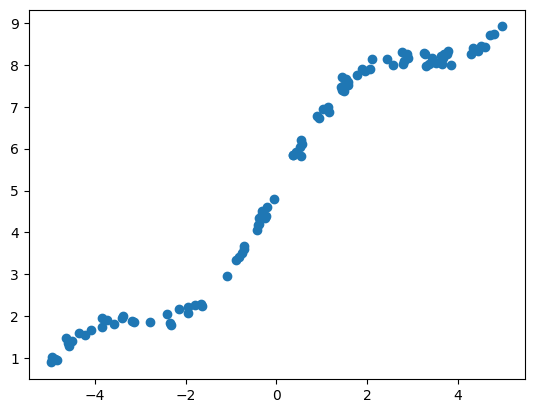

In [2]:
X = np.random.uniform(-5,5,100)
y = 5 + X + np.sin(X) + np.random.normal(scale=0.1, size=100)
plt.plot(X,y,'o')
X = np.expand_dims(X, axis=1)

Zaimplementuj algorytm GBT dla błędu kwadratowego. Aby to zrobić należy uzupełnić w ogólnym pseudokodzie przedstawionym na zajęciach trzy elementy:
- model początkowy $F_0(x)$ zwracający stałą wartość $v$ która optymalizuje błąd:
$$F_0(x) = \arg \min_v \sum_{i=1}^N L(y_i, v) $$
- wzór na wartość ujemnego gradientu tj. pseudo-rezyduum:
$$r_i  =  - \frac{\partial}{\partial \hat{y_i}} L(y_i, \hat{y_i}) $$
gdzie $\hat{y_i}$ to aktualna predykcja klasyfikatora tj. w $m$-tej iteracji $\hat{y_i}=F_m(x)$
- wzór na wartość liścia $v$ optymalizujący funkcję celu całego modelu GBT
$$v = \arg \min_v \sum_{i=1}^{N_l} L(y_i, F_{m-1}(x_i) + v) $$
Zwróć uwagę, że suma iteruje tylko po instancjach w liściu (${N_l}$ to liczba elementów w liściu).

Wyznacz powyższe wartości (rozwiązania dla referencji poniżej komórki z kodem) i zaimplementuj algorytm. 

In [28]:
class GBTRegressor(object):
    
    def __init__(self, learning_rate=1):
        self.trees = [] # Lista kolejnych drzew (Node) klasyfikatora
        self.initial_model = None # Model początkowy, zwracający stałą wartość 
                                  #(zmienna po prostu przechowuje tę wartość)
        self.learning_rate = learning_rate
        self.residuals = []
        
    def calc_leaf(self, X, y, last_predicted):
        """
        Funkcja do wykorzystania jako argument klasyfikatora bazowego Node
        """
        return np.mean(y)
        
    def fit(self, X, y, M = 100, max_depth = 1):
        """ 
        Funckja trenująca model GBT o M klasyfikatora bazowych
        z maksymalną głębkością pojedynczego drzewa max_depth
        """
        self.initial_model = np.mean(y)
        Y = np.full(len(X), self.initial_model)
    
        for _ in range(M):
            residuals = y - Y
            base_model = Node(calculate_leaf_value=self.calc_leaf)
            base_model.fit(X, residuals, Y, max_depth=max_depth)
            self.residuals.append(residuals)
            tmp = self.learning_rate * base_model.predict(X)
            self.trees.append(base_model)
            Y += tmp
            

            
    def predict(self, X):
        """
        Zwrócenie predykcji dla obiektów testowych X
        """
        predictions = [tree.predict(X) for tree in self.trees]
        summed_predictions = np.sum(predictions, axis=0)
        return self.initial_model + self.learning_rate * summed_predictions

Przetestuj działanie algorytmu:

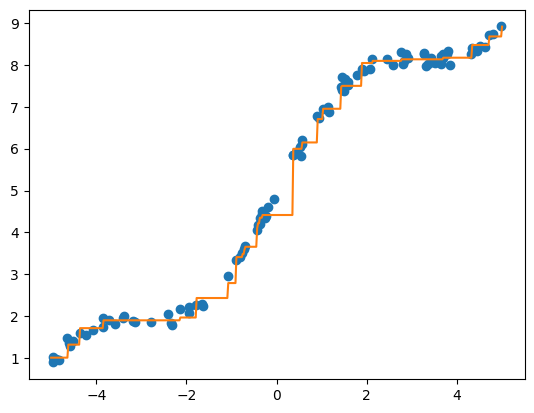

In [29]:
X_test = np.linspace(-5, 5, num=500)
X_test = np.expand_dims(X_test, axis=1)
gbt = GBTRegressor()
gbt.fit(X,y)
y_pred = gbt.predict(X_test)
plt.plot(X,y,'o')
plt.plot(X_test,y_pred,'-')

Narysuj wynik modelu z odpowednio 1, 2, 5, 10 i 100 klasyfikatorami bazowami. Za klasfikator bazowy przyjmij decision stump.

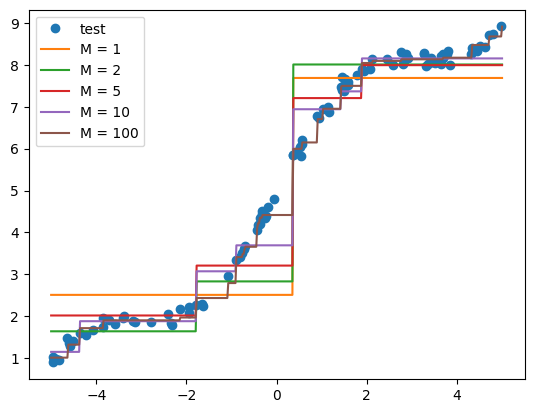

In [30]:
num_classifiers = [1, 2, 5, 10, 100]
plt.plot(X, y, 'o', label='test')
for m in num_classifiers:
    gbt = GBTRegressor()
    gbt.fit(X, y, M=m, max_depth=1)
    Y_test = gbt.predict(X_test)
    plt.plot(X_test, Y_test, '-', label=f'M = {m}')
plt.legend()

Sprawdź jak zmieniają się wartości redyduów w kilku początkowych iteracjach GBT. Narysuj wykresy $x$ vs $y-\hat{y}$ - zwróć uwagę, że tak właśnie wyglądają zbiory na których uczą się kolejne klasyfikatory.

C:\Users\jesmok\AppData\Local\Temp\ipykernel_5740\746266533.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X, y + current_residuals, c=color, s=10, label=j + 1)


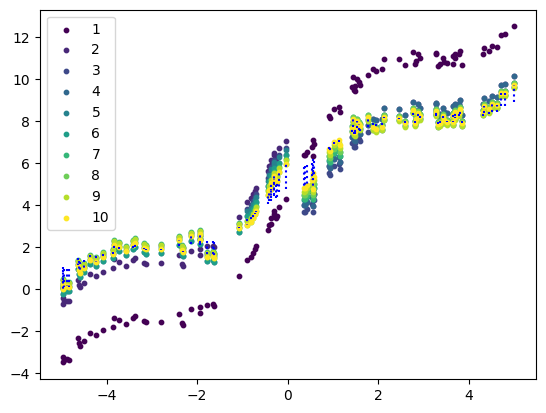

In [39]:
model = GBTRegressor()
model.fit(X, y, M=10)

cm = plt.get_cmap('viridis')
last_residuals = model.residuals[len(model.residuals) - 1]

plt.vlines(X, ymin=y, ymax=y + last_residuals, colors='b', ls='dotted')

for j in range(10):
    color = cm(j / (9))
    current_residuals = model.residuals[j]
    plt.scatter(X, y + current_residuals, c=color, s=10, label=j + 1)


plt.legend()

*Odpowiedzi:*
- model początkowy $F_0(x)$
$$F_0(x) = \arg \min_v \sum_{i=1}^N L(y_i, v) = \frac{1}{2} \sum_{i=1}^N (y_i- v)^2 $$
wartość ta to oczywiście średnia arytmetyczna $v = \frac{1}{n} \sum_{i=1}^N y_i$. (Upewnij się, że to rozumiesz poprzez policzenie pochodnej i przyrównanie jej do 0).
- wzór na wartość ujemnego gradientu tj. pseudo-rezyduum 
$$r_i  =  - \frac{\partial}{\partial \hat{y_i}} L(y_i, \hat{y_i}) = - \frac{\partial}{\partial \hat{y_i}} \frac{1}{2}(y_i- \hat{y_i})^2$$
Co po przekształceniach wykorzystujących regułę łańcuchową ("pochodna zewnętrzna razy pochodna wewnętrzna"):
$$r_i  = -\frac{1}{2} 2(y_i- \hat{y_i})\frac{\partial}{\partial \hat{y_i}} (y_i- \hat{y_i}) 
= -(y_i- \hat{y_i})\cdot(-1)
= y_i- \hat{y_i}  $$
- wzór na wartość liścia $v$ optymalizujący funkcję celu
$$v = \arg \min_v \sum_{i=1}^{N_l} L(y_i, F_{m-1}(x_i) + v) = \frac{1}{2} \sum_{i=1}^{N_l} (y_i- F_{m-1}(x_i) - v)^2 $$
Co można dalej obliczyć poprzez przyrównanie pochodnej do 0 lub poprzez zauważenie że jest to w naszej sytuacji ten sam wzór co dla modelu początkowego gdzie $y_i$ zostało zastępione $y_i- F_{m-1}(x_i)=r_i$. W związku z tym wartość liścia to $v = \frac{1}{n} \sum_{i=1}^N r_i$

## Zadanie 2
Zaimplementuj GBT dla problemu klasyfikacji binarnej, który będzie optymalizował błąd regresji logicznej tj. entropię krzyżową wyrażoną wzorem:
$$L(y_i, \hat{p_i}) = y_i \log \hat{p_i} +  (1-y_i) \log (1-\hat{p_i}) $$
gdzie $y_i\in \{0,1\}$ to prawdziwa wartość klasy a $\hat{p_i}$ to predykcja klasyfikatora dla $i$-tego elementu.

- Zauważ, że GBT wykorzystuje drzewa regresji, które - choć modyfikujemy im sposób obliczania liści - nadal tworzą podziały dla miary SSE. Aby wykorzystać GBT do problemu klasyfikacji, należy zastanowić się jak możemy wykorzystać regresor do klasyfikacji. Ten problem rozwiązywaliśmy już wcześniej przy omawianiu regresji logistycznej, gdzie tworzyliśmy klasyfikator z modelu regresji liniowej. Przypomnijmy, że w regresji logistycznej model regresji liniowej służy do predykcji logitu prawdopodobieństwa klasy (który przypomnijmy ma zakres wartości od $-\infty$ do $\infty$)
$$\text{logit}(p_x) = \ln \frac{p_x}{1-p_x}=w^Tx+b$$
Podobnie w GBT należy skonstruować model regresji do przewidywania wartości $\text{logit}(p_x)$, a jedynie przy predykcji (lub kiedy jest to wygodne) transformować go do prawdopodobieństwa klasy funkcją sigmoidalną $p_x  = \frac{1}{1+e^{- \text{logit}(p_x)}}  $

**Zadania**

1. Powyższy zapis funkcji celu $L(y_i, \hat{p_i})$ jest wyrażony w zależności od prawdopodobieństwa klasy, a nie wartości logitu $L(y_i, \text{logit}(\hat{p_i}))$. Przekształć wzór na funkcję celu, aby jej argumentem był logit. Zwróć uwagę, że model regresji będzie przewidywał właśnie logit, więc przy wyznaczaniu elementów algorytmu GBT należy liczyć np. pochodne tej właśnie przekształconej funkcji.

    Zapisz wzór na tę funkcję w komórce poniżej (np. w komentarzu, nie musisz implementować).


$$p_x = \frac{1}{1 + e^{-logit(x)}} = \frac{1}{1 + \frac{1}{e^logit(x)}} = \frac{1}{\frac{e^logit(x) + 1}{e^logit(x)}} = \frac{e^logit(x)}{1+e^logit(x)}$$
$$L(y_i, logit(x)) = y_i \log (\frac{e^{logit(x)}}{e^{logit(x)} + 1}) + (1 - y_i) \log (1 - \frac{e^{logit(x)}}{e^{logit(x)} + 1})$$
$$L(y_i, logit(x)) = y_i \log (\frac{e^{logit(x)}}{e^{logit(x)} + 1}) + (1 - y_i) \log (\frac{1}{1 + e^{logit(x)}})$$
$$L(y_i, logit(x)) = y_i \log (\frac{e^{logit(x)}}{e^{logit(x)} + 1}) + (1 - y_i) (\log 1 - \log (1 + e^{logit(x)}))$$
$$L(y_i, logit(x)) = y_i \log (\frac{e^{logit(x)}}{e^{logit(x)} + 1}) + (y_i - 1) \log (1 + e^{logit(x)})$$
$$L(y_i, logit(x)) = y_i \log e^{logit(x)} - y_i \log (1 + e^{logit(x)}) + y_i \log (1 + e^{logit(x)}) - \log(1 + e^{logit(x)})$$
$$L(y_i, logit(x)) = y_i \log e^{logit(x)} - \log(1 + e^{logit(x)})$$
$$L(y_i, logit(p_x)) = y_i \log e^{logit(p_x)} - \log (1 + e^{logit(p_x)})$$
$$L(y_i, logit(p_x)) = y_i logit(p_x) - \log (1 + e^{logit(p_x)})$$

2. Zacznijmy uzupełniać w ogólnym pseudokodzie przedstawionym na zajęciach brakujące elementy. Wyznacz model początkowy $F_0(x)$ zwracający stałą wartość $v$ która optymalizuje błąd:
$$F_0(x) = \arg \min_v \sum_{i=1}^N L(y_i, v) $$
$$\frac{\partial}{\partial v} L(y_i, v) = \frac{\partial}{\partial v} (y_iv - log(1 + e^v)) = y_i - \frac{e^v}{1 + e^v} = 0 => y_i = \frac{e^v}{1 + e^v}$$
$$y_i + y_i e^v = e^v => e^v = \frac{y_i}{1 - y_i} => v = \log \frac{y_i}{1 - y_i}$$

$$F_0(x) = \log \frac{y_i}{1 - y_i}$$


YOUR ANSWER HERE

3. Wyznacz wzór na wartość ujemnego gradientu tj. pseudo-rezyduum:
$$r_i  =  - \frac{\partial}{\partial \hat{y_i}} L(y_i, \hat{y_i}) $$
Uwaga: na samym końcu, aby wzór uzykał prostszą formę, możesz zamienić w nim wartości logitów z powrotem na prawdopodobieństwa.

$$r_i = - y_i + \frac{e^{\hat y_i}}{1 + e^{\hat y_i}}$$
$$r_i = - y_i + p_x = p_x - y_i$$

4. Wzór na wartość liścia $v$ optymalizujący funkcję celu całego modelu GBT
$$v = \arg \min_v \sum_{i=1}^{N_l} L(y_i, F_{m-1}(x_i) + v) $$
niestety nie jest prosty do wyznaczenia w tym przypadku. Stosuje się przybliżenie Taylora drugiego rzedu tej funkcji i wtedy optimum ma postać:
$$v = \frac{-\sum_{i=1}^{N_L} L_i' }{\sum_{i=1}^{N_L} L_i''}$$
gdzie $L_i'$ i $L_i''$ to skrócony zapis pierwszej i drugiej pochodnej policzonej po funkcji straty dla $i$-tego elementu. Ponieważ $r_i=-L_i'$ to licznik przyjmuje postać $\sum_{i=1}^{N_L} r_i $. Wyznacz cały wzór.



$$v = \frac{\sum_{i=1}^{N_L}r_i}{\sum_{i=1}^{N_L} \frac{e^v}{(e^v+1)^2}}$$
$$\frac{1}{e^v + 1} = \frac{e^v + 1 - e^v}{e^v + 1} => 1 - \frac{e^v}{e^v + 1} => 1 - p_x$$
$$v = \frac{\sum_{i=1}^{N_L}r_i(e^v + 1)^2}{\sum_{i=1}^{N_L} e^v}$$
$$v = \frac{\sum_{i=1}^{N_L}r_i p_x}{\sum_{i=1}^{N_L} 1 - p_x}$$

Wykorzystując uzyskane wyniki zaimplementuj algorytm. 

In [1]:
import scipy.special
# Wskazówka: scipy.special.expit() implemenuje funkcję sigmoidalną

class GBTClassifier(object):
    def __init__(self):
        self.trees = []
        self.initial_model = None
        self.learning_rate = 1
        self.residuals = []
        
    def calc_leaf(self, X, y, last_predicted):\
        return np.mean(y)
    
    def fit(self, X, y, M = 100, max_depth = 10):
        self.initial_model = np.log(np.mean(y) / (1 - np.mean(y)))
        Y = np.full(len(X), self.initial_model)
        for _ in range(M):
            residuals = -(Y - y)
            self.residuals.append(residuals)
            tree = Node(calculate_leaf_value=self.calc_leaf)
            tree.fit(X, residuals, Y, max_depth=max_depth)
            Y += self.learning_rate * tree.predict(X)
            self.trees.append(tree)
            
    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        return scipy.special.expit(self.initial_model + self.learning_rate * sum(predictions))
    

Przetestuj swoją implementację na zbinaryzowanym zbiorze `iris`.

C:\Users\jesmok\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\jesmok\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\jesmok\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


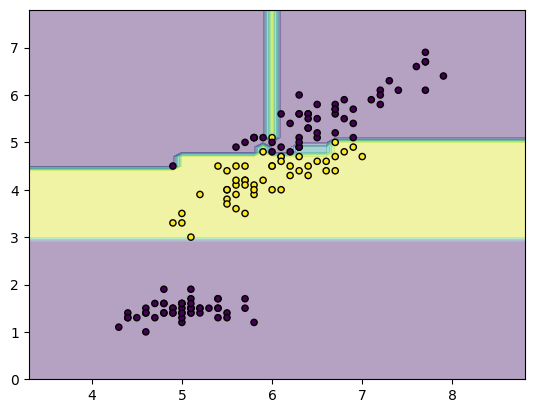

In [4]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data[:, [0, 2]]
y = iris.target
y[y==2] = 0 # Sprowadzenie problemu do klasyfikacji binarnej

# Kod rysowania
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

clf = GBTClassifier()
clf.fit(X,y)
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
plt.show()

Narysuj granice decyzji klasyfikatora dla 10, 20, 50 i 100 iteracji algorytmu dla klasyfikatora bazowego o maksymalnej głębokości 1 i 2.

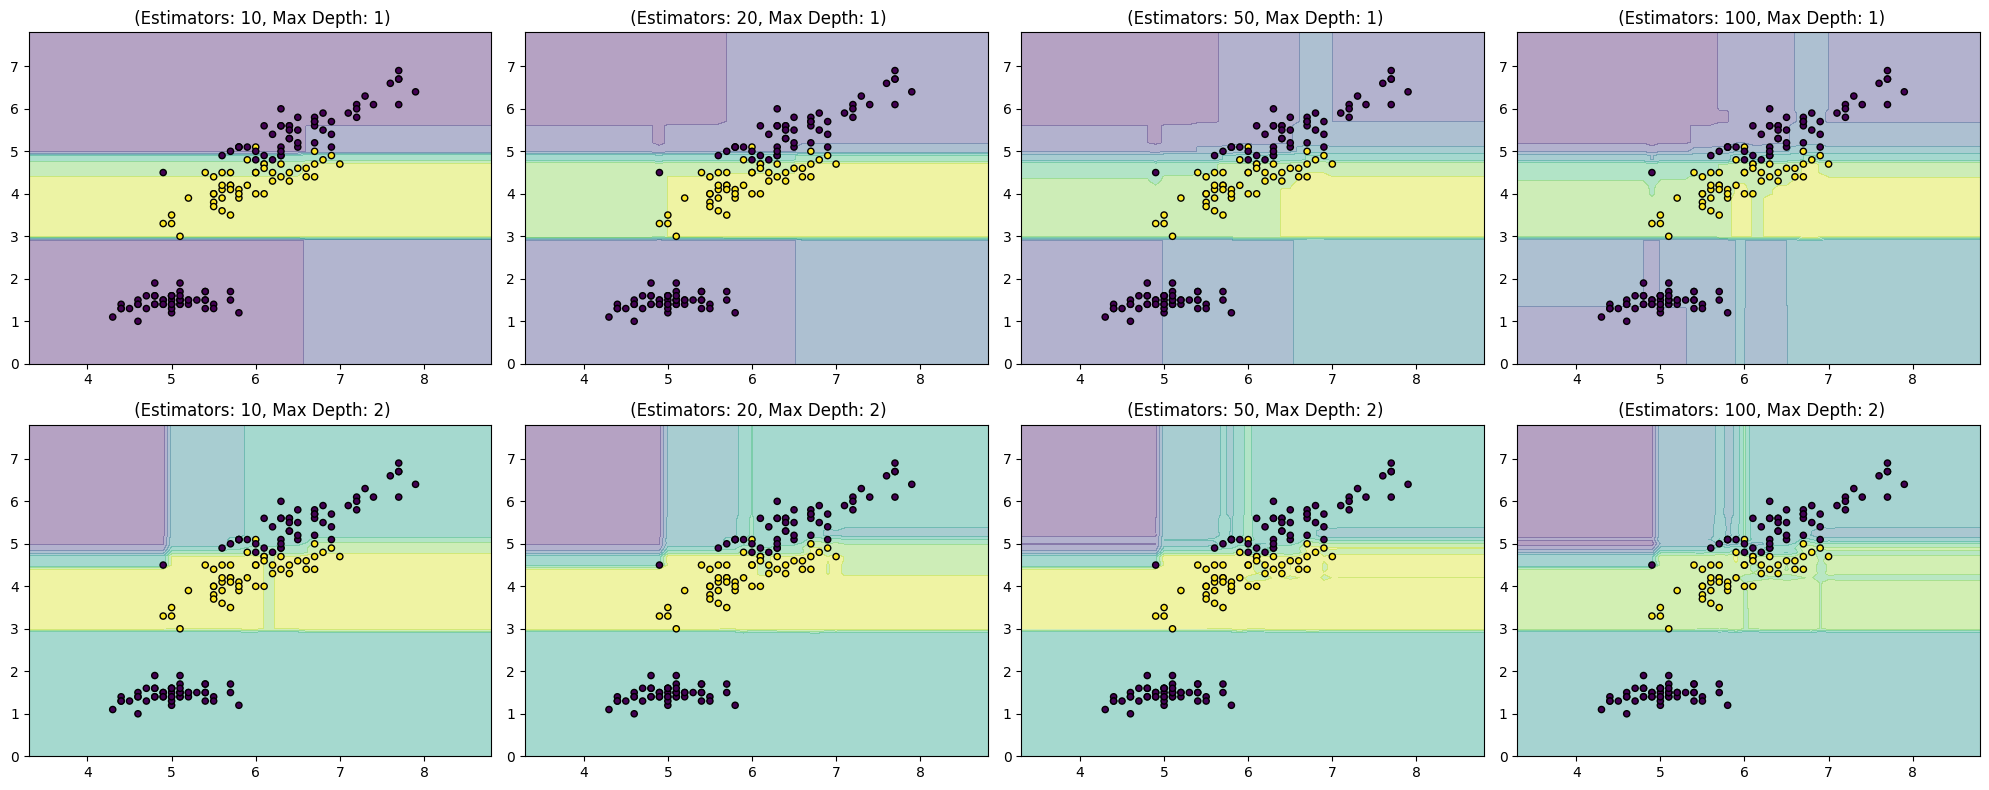

In [5]:
def plot_gbt_classifiers():
    iris_data = datasets.load_iris()
    features = iris_data.data[:, [0, 2]]
    labels = iris_data.target
    labels[labels == 2] = 0

    x_min, x_max = features[:, 0].min() - 1, features[:, 0].max() + 1
    y_min, y_max = features[:, 1].min() - 1, features[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    num_estimators_list = [10, 20, 50, 100]
    max_depth_list = [1, 2]

    fig, axes = plt.subplots(2, 4, figsize=(20, 8))
    
    row=0
    for max_depth in max_depth_list:
        col=0
        for  num_estimators in num_estimators_list:
            classifier = GBTClassifier()
            classifier.fit(features, labels, M=num_estimators, max_depth=max_depth)
            predictions = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
            predictions = predictions.reshape(xx.shape)

            ax = axes[row, col]
            ax.contourf(xx, yy, predictions, alpha=0.4)
            ax.scatter(features[:, 0], features[:, 1], c=labels, s=20, edgecolor='k')
            ax.set_title(f" (Estimators: {num_estimators}, Max Depth: {max_depth})")
            col+=1
        row+=1
    plt.tight_layout()
    plt.show()

plot_gbt_classifiers()

**Ćwiczenia**
1. Przeanalizuj wyniki powyższego eksperymentu i określ w których sytuacjach nastąpiło przeuczenie.
2. W jaki sposób zaimplementować GBT dla problemu klasyfikacji wieloklasowej?
3. W powyższym problemie który z klasyfikatorów bazowych (o jakiej max. głębokości) poradził sobie lepiej? Czy jest sens stosować w tym problemie drzewa o głębokości większej niż testowana (tj. 2). Odpowiedź uzasadnij.
4. Dodaj do implementacji parametr $\eta$ i przetestuj kilka jego wartości. Pamętaj, że $\eta$ powinno być wykorzystywane nie tylko w funkcji `fit`, ale także `predict` - dlaczego?

Odpowiedź na trzecią kropkę umieść poniżej.

Drzewa ze wzorsotem limitu głębokości potrafią wyznaczać bardziej skomplikowane granice między klasami. Jednak głębsze drzewa mogą zostać szybciej przetrenowane. Drzewa o głębkości większej niż testowana mogą być nieuzasadnione.

## Zadanie 3
GBT jest bardzo popularnym algorytmem głównie dzięki bardzo efektywnym implementacjom potrafiącym sobie radzić z dużymi zbiorami danych. W tym ćwiczeniu Twoim zadaniem jest nauczenie się podstaw obsługi biblioteki `catboost`, którą powinieneś zainstalować.

Wczytanie zbioru danych `iris` z poprzedniego zadania.

In [41]:
from catboost import CatBoostClassifier
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data[:, [0, 2]]
y = iris.target
y[y==2] = 0 # Sprowadzenie problemu do klasyfikacji binarnej

Trening modelu

In [43]:
model = CatBoostClassifier(logging_level='Silent')
model.fit(X, y, eval_set=(X, y), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Przykładowy kod ewaluuje działanie algorytmu na części uczącej. Podziel zbiór na część uczącą i testową i ponownie uruchom algorytm. 


In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = CatBoostClassifier()
model.fit(X_train, y_train, eval_set=(X_test, y_test), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.01877
0:	learn: 0.6794327	test: 0.6813121	best: 0.6813121 (0)	total: 1.84ms	remaining: 1.83s
1:	learn: 0.6517914	test: 0.6555496	best: 0.6555496 (1)	total: 3.49ms	remaining: 1.74s
2:	learn: 0.6311689	test: 0.6302147	best: 0.6302147 (2)	total: 5.54ms	remaining: 1.84s
3:	learn: 0.6079164	test: 0.6043640	best: 0.6043640 (3)	total: 7.66ms	remaining: 1.91s
4:	learn: 0.5867069	test: 0.5824002	best: 0.5824002 (4)	total: 10.6ms	remaining: 2.1s
5:	learn: 0.5673258	test: 0.5667485	best: 0.5667485 (5)	total: 12.2ms	remaining: 2.02s
6:	learn: 0.5495990	test: 0.5502001	best: 0.5502001 (6)	total: 14.4ms	remaining: 2.04s
7:	learn: 0.5336411	test: 0.5342780	best: 0.5342780 (7)	total: 15.8ms	remaining: 1.96s
8:	learn: 0.5154826	test: 0.5140501	best: 0.5140501 (8)	total: 17.8ms	remaining: 1.96s
9:	learn: 0.4970128	test: 0.4964185	best: 0.4964185 (9)	total: 19.3ms	remaining: 1.91s
10:	learn: 0.4790805	test: 0.4771177	best: 0.4771177 (10)	total: 21ms	remaining: 1.88s
11:	learn: 0.46

158:	learn: 0.0908008	test: 0.0944581	best: 0.0944581 (158)	total: 364ms	remaining: 1.93s
159:	learn: 0.0905369	test: 0.0940444	best: 0.0940444 (159)	total: 369ms	remaining: 1.94s
160:	learn: 0.0896974	test: 0.0933000	best: 0.0933000 (160)	total: 371ms	remaining: 1.93s
161:	learn: 0.0894712	test: 0.0931949	best: 0.0931949 (161)	total: 373ms	remaining: 1.93s
162:	learn: 0.0886855	test: 0.0924146	best: 0.0924146 (162)	total: 375ms	remaining: 1.93s
163:	learn: 0.0886073	test: 0.0924250	best: 0.0924146 (162)	total: 377ms	remaining: 1.92s
164:	learn: 0.0882098	test: 0.0922002	best: 0.0922002 (164)	total: 379ms	remaining: 1.92s
165:	learn: 0.0876524	test: 0.0919436	best: 0.0919436 (165)	total: 382ms	remaining: 1.92s
166:	learn: 0.0873015	test: 0.0917298	best: 0.0917298 (166)	total: 385ms	remaining: 1.92s
167:	learn: 0.0868555	test: 0.0911910	best: 0.0911910 (167)	total: 388ms	remaining: 1.92s
168:	learn: 0.0865150	test: 0.0907679	best: 0.0907679 (168)	total: 390ms	remaining: 1.92s
169:	learn

309:	learn: 0.0533890	test: 0.0693660	best: 0.0693660 (309)	total: 745ms	remaining: 1.66s
310:	learn: 0.0533390	test: 0.0693760	best: 0.0693660 (309)	total: 747ms	remaining: 1.66s
311:	learn: 0.0529256	test: 0.0688267	best: 0.0688267 (311)	total: 749ms	remaining: 1.65s
312:	learn: 0.0525693	test: 0.0682462	best: 0.0682462 (312)	total: 751ms	remaining: 1.65s
313:	learn: 0.0524958	test: 0.0682153	best: 0.0682153 (313)	total: 754ms	remaining: 1.65s
314:	learn: 0.0522137	test: 0.0679969	best: 0.0679969 (314)	total: 757ms	remaining: 1.65s
315:	learn: 0.0521578	test: 0.0680031	best: 0.0679969 (314)	total: 760ms	remaining: 1.65s
316:	learn: 0.0519586	test: 0.0681700	best: 0.0679969 (314)	total: 763ms	remaining: 1.64s
317:	learn: 0.0516957	test: 0.0680245	best: 0.0679969 (314)	total: 766ms	remaining: 1.64s
318:	learn: 0.0515816	test: 0.0679173	best: 0.0679173 (318)	total: 768ms	remaining: 1.64s
319:	learn: 0.0515352	test: 0.0679161	best: 0.0679161 (319)	total: 772ms	remaining: 1.64s
320:	learn

438:	learn: 0.0354108	test: 0.0510818	best: 0.0510818 (438)	total: 1.12s	remaining: 1.43s
439:	learn: 0.0353654	test: 0.0511086	best: 0.0510818 (438)	total: 1.12s	remaining: 1.43s
440:	learn: 0.0352572	test: 0.0510888	best: 0.0510818 (438)	total: 1.13s	remaining: 1.43s
441:	learn: 0.0351448	test: 0.0509703	best: 0.0509703 (441)	total: 1.13s	remaining: 1.43s
442:	learn: 0.0350645	test: 0.0507374	best: 0.0507374 (442)	total: 1.13s	remaining: 1.42s
443:	learn: 0.0349510	test: 0.0504799	best: 0.0504799 (443)	total: 1.14s	remaining: 1.42s
444:	learn: 0.0348292	test: 0.0503920	best: 0.0503920 (444)	total: 1.14s	remaining: 1.42s
445:	learn: 0.0348064	test: 0.0503995	best: 0.0503920 (444)	total: 1.14s	remaining: 1.42s
446:	learn: 0.0347382	test: 0.0502407	best: 0.0502407 (446)	total: 1.15s	remaining: 1.42s
447:	learn: 0.0345899	test: 0.0500846	best: 0.0500846 (447)	total: 1.15s	remaining: 1.42s
448:	learn: 0.0344905	test: 0.0500773	best: 0.0500773 (448)	total: 1.15s	remaining: 1.42s
449:	learn

564:	learn: 0.0272905	test: 0.0467079	best: 0.0465318 (548)	total: 1.49s	remaining: 1.15s
565:	learn: 0.0272401	test: 0.0467138	best: 0.0465318 (548)	total: 1.49s	remaining: 1.14s
566:	learn: 0.0271900	test: 0.0467202	best: 0.0465318 (548)	total: 1.5s	remaining: 1.14s
567:	learn: 0.0271768	test: 0.0467239	best: 0.0465318 (548)	total: 1.5s	remaining: 1.14s
568:	learn: 0.0271291	test: 0.0467583	best: 0.0465318 (548)	total: 1.5s	remaining: 1.14s
569:	learn: 0.0270932	test: 0.0467761	best: 0.0465318 (548)	total: 1.5s	remaining: 1.13s
570:	learn: 0.0270795	test: 0.0467797	best: 0.0465318 (548)	total: 1.5s	remaining: 1.13s
571:	learn: 0.0270660	test: 0.0467831	best: 0.0465318 (548)	total: 1.51s	remaining: 1.13s
572:	learn: 0.0270523	test: 0.0467864	best: 0.0465318 (548)	total: 1.51s	remaining: 1.12s
573:	learn: 0.0270056	test: 0.0468206	best: 0.0465318 (548)	total: 1.51s	remaining: 1.12s
574:	learn: 0.0269569	test: 0.0468282	best: 0.0465318 (548)	total: 1.51s	remaining: 1.12s
575:	learn: 0.0

708:	learn: 0.0229647	test: 0.0498300	best: 0.0465318 (548)	total: 1.86s	remaining: 762ms
709:	learn: 0.0229565	test: 0.0498377	best: 0.0465318 (548)	total: 1.86s	remaining: 759ms
710:	learn: 0.0229313	test: 0.0498893	best: 0.0465318 (548)	total: 1.86s	remaining: 756ms
711:	learn: 0.0229230	test: 0.0498972	best: 0.0465318 (548)	total: 1.86s	remaining: 754ms
712:	learn: 0.0229146	test: 0.0499050	best: 0.0465318 (548)	total: 1.87s	remaining: 751ms
713:	learn: 0.0228897	test: 0.0499566	best: 0.0465318 (548)	total: 1.87s	remaining: 749ms
714:	learn: 0.0228636	test: 0.0499482	best: 0.0465318 (548)	total: 1.87s	remaining: 747ms
715:	learn: 0.0228250	test: 0.0499745	best: 0.0465318 (548)	total: 1.88s	remaining: 744ms
716:	learn: 0.0228167	test: 0.0499823	best: 0.0465318 (548)	total: 1.88s	remaining: 742ms
717:	learn: 0.0227909	test: 0.0499737	best: 0.0465318 (548)	total: 1.88s	remaining: 739ms
718:	learn: 0.0227664	test: 0.0500249	best: 0.0465318 (548)	total: 1.88s	remaining: 736ms
719:	learn

852:	learn: 0.0206056	test: 0.0515655	best: 0.0465318 (548)	total: 2.23s	remaining: 384ms
853:	learn: 0.0205897	test: 0.0515979	best: 0.0465318 (548)	total: 2.23s	remaining: 382ms
854:	learn: 0.0205847	test: 0.0516045	best: 0.0465318 (548)	total: 2.23s	remaining: 379ms
855:	learn: 0.0205794	test: 0.0516109	best: 0.0465318 (548)	total: 2.24s	remaining: 376ms
856:	learn: 0.0205743	test: 0.0516171	best: 0.0465318 (548)	total: 2.24s	remaining: 374ms
857:	learn: 0.0205691	test: 0.0516232	best: 0.0465318 (548)	total: 2.24s	remaining: 371ms
858:	learn: 0.0205534	test: 0.0516556	best: 0.0465318 (548)	total: 2.25s	remaining: 369ms
859:	learn: 0.0205267	test: 0.0516359	best: 0.0465318 (548)	total: 2.25s	remaining: 366ms
860:	learn: 0.0205109	test: 0.0516800	best: 0.0465318 (548)	total: 2.25s	remaining: 363ms
861:	learn: 0.0204953	test: 0.0517126	best: 0.0465318 (548)	total: 2.25s	remaining: 361ms
862:	learn: 0.0204792	test: 0.0517062	best: 0.0465318 (548)	total: 2.25s	remaining: 358ms
863:	learn

Gdybyś porównał wartość funkcji straty osiągniętej przez catboost z wartością uzyskaną Twoją implementacją na zbiorze uczącym przy analogicznej liczbie drzew (domyślnie w `GBTClassifier` $M=100$) to wartość ta będzie najprawdopodobniej niższa dla... Twojej implementacji. Dlaczego? Czy to oznacza, że - pomijając aspekt wydajności obliczeń - Twoja metoda działa lepiej niż catboost?

*Dla chętnych*: porównaj wartość funkcji straty osiągniętej przez catboost z Twoją implementacją z zadania 2.

YOUR ANSWER HERE

Zaimportuj dowolny większy i bardziej wymagający zbiór danych. Ćwiczenie możesz wykonać na [dowolnym zbiorze danych](https://catboost.ai/docs/concepts/python-reference_datasets.html) - ładowanie zbioru może trochę potrwać. Jeśli masz problemy sprzętowe z operowaniem na dużym zbiorze danych to jest też dostępny zbiór `titanic`.

In [45]:
# from catboost import datasets

# train_df, test_df = datasets.adult()
# print(train_df.shape, test_df.shape)


(32561, 15) (16281, 15)


Spróbuj osiągnąć jak najlepszy wynik na wybranym zbiorze poprzez tuning parametrów. Ważne parametry uczenia zostały opisane [tutaj](https://catboost.ai/docs/concepts/python-reference_parameters-list.html).

In [51]:
X_train, X_test = train_df.drop(columns=['income']), test_df.drop(columns=['income'])
y_train, y_test = train_df.income, test_df.income
cc=['workclass', 'education','marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
X_train[cc] = X_train[cc].fillna(value='unknown')
X_test[cc] = X_test[cc].fillna(value='unknown')
model = CatBoostClassifier(cat_features=[1,3,5,6,7,8,9,13])
grid = dict(
    learning_rate=[0.01, 0.2],
    depth=[7, 8, 9],
    l2_leaf_reg=[1, 3, 5, 7, 9]
)
output = model.randomized_search(grid, X_train, y_train, plot=True)
print(output.params)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6833329	test: 0.6832003	best: 0.6832003 (0)	total: 126ms	remaining: 2m 5s
1:	learn: 0.6729996	test: 0.6728254	best: 0.6728254 (1)	total: 246ms	remaining: 2m 2s
2:	learn: 0.6625293	test: 0.6622384	best: 0.6622384 (2)	total: 379ms	remaining: 2m 5s
3:	learn: 0.6524429	test: 0.6520165	best: 0.6520165 (3)	total: 511ms	remaining: 2m 7s
4:	learn: 0.6429968	test: 0.6423971	best: 0.6423971 (4)	total: 640ms	remaining: 2m 7s
5:	learn: 0.6343564	test: 0.6332541	best: 0.6332541 (5)	total: 759ms	remaining: 2m 5s
6:	learn: 0.6256297	test: 0.6244827	best: 0.6244827 (6)	total: 917ms	remaining: 2m 10s
7:	learn: 0.6175545	test: 0.6162947	best: 0.6162947 (7)	total: 1.1s	remaining: 2m 16s
8:	learn: 0.6089179	test: 0.6075369	best: 0.6075369 (8)	total: 1.28s	remaining: 2m 20s
9:	learn: 0.6005220	test: 0.5990443	best: 0.5990443 (9)	total: 1.46s	remaining: 2m 24s
10:	learn: 0.5929549	test: 0.5913422	best: 0.5913422 (10)	total: 1.62s	remaining: 2m 25s
11:	learn: 0.5852812	test: 0.5836168	best: 0.583

93:	learn: 0.3474327	test: 0.3456697	best: 0.3456697 (93)	total: 14.8s	remaining: 2m 22s
94:	learn: 0.3469748	test: 0.3452140	best: 0.3452140 (94)	total: 14.9s	remaining: 2m 21s
95:	learn: 0.3463268	test: 0.3445493	best: 0.3445493 (95)	total: 15s	remaining: 2m 21s
96:	learn: 0.3455943	test: 0.3437924	best: 0.3437924 (96)	total: 15.2s	remaining: 2m 21s
97:	learn: 0.3448558	test: 0.3430854	best: 0.3430854 (97)	total: 15.3s	remaining: 2m 21s
98:	learn: 0.3441034	test: 0.3423355	best: 0.3423355 (98)	total: 15.5s	remaining: 2m 20s
99:	learn: 0.3433659	test: 0.3416084	best: 0.3416084 (99)	total: 15.6s	remaining: 2m 20s
100:	learn: 0.3426957	test: 0.3409359	best: 0.3409359 (100)	total: 15.8s	remaining: 2m 20s
101:	learn: 0.3420601	test: 0.3402811	best: 0.3402811 (101)	total: 15.9s	remaining: 2m 20s
102:	learn: 0.3414331	test: 0.3396516	best: 0.3396516 (102)	total: 16.1s	remaining: 2m 20s
103:	learn: 0.3406982	test: 0.3389078	best: 0.3389078 (103)	total: 16.3s	remaining: 2m 20s
104:	learn: 0.3

185:	learn: 0.3112677	test: 0.3112226	best: 0.3112226 (185)	total: 28.4s	remaining: 2m 4s
186:	learn: 0.3109850	test: 0.3109628	best: 0.3109628 (186)	total: 28.5s	remaining: 2m 4s
187:	learn: 0.3107152	test: 0.3106961	best: 0.3106961 (187)	total: 28.7s	remaining: 2m 3s
188:	learn: 0.3105484	test: 0.3105018	best: 0.3105018 (188)	total: 28.8s	remaining: 2m 3s
189:	learn: 0.3103933	test: 0.3103697	best: 0.3103697 (189)	total: 28.9s	remaining: 2m 3s
190:	learn: 0.3101874	test: 0.3101728	best: 0.3101728 (190)	total: 29.1s	remaining: 2m 3s
191:	learn: 0.3100148	test: 0.3100132	best: 0.3100132 (191)	total: 29.2s	remaining: 2m 2s
192:	learn: 0.3097903	test: 0.3098128	best: 0.3098128 (192)	total: 29.4s	remaining: 2m 2s
193:	learn: 0.3095695	test: 0.3096164	best: 0.3096164 (193)	total: 29.5s	remaining: 2m 2s
194:	learn: 0.3093868	test: 0.3094769	best: 0.3094769 (194)	total: 29.7s	remaining: 2m 2s
195:	learn: 0.3092144	test: 0.3093195	best: 0.3093195 (195)	total: 29.8s	remaining: 2m 2s
196:	learn

277:	learn: 0.2984862	test: 0.3005027	best: 0.3005027 (277)	total: 43.6s	remaining: 1m 53s
278:	learn: 0.2984286	test: 0.3004483	best: 0.3004483 (278)	total: 43.7s	remaining: 1m 53s
279:	learn: 0.2983217	test: 0.3003414	best: 0.3003414 (279)	total: 43.9s	remaining: 1m 53s
280:	learn: 0.2981803	test: 0.3002294	best: 0.3002294 (280)	total: 44.1s	remaining: 1m 52s
281:	learn: 0.2980960	test: 0.3001867	best: 0.3001867 (281)	total: 44.3s	remaining: 1m 52s
282:	learn: 0.2980016	test: 0.3001228	best: 0.3001228 (282)	total: 44.4s	remaining: 1m 52s
283:	learn: 0.2978969	test: 0.3000498	best: 0.3000498 (283)	total: 44.6s	remaining: 1m 52s
284:	learn: 0.2978113	test: 0.2999918	best: 0.2999918 (284)	total: 44.7s	remaining: 1m 52s
285:	learn: 0.2977179	test: 0.2999283	best: 0.2999283 (285)	total: 44.9s	remaining: 1m 52s
286:	learn: 0.2976374	test: 0.2998729	best: 0.2998729 (286)	total: 45.1s	remaining: 1m 52s
287:	learn: 0.2975376	test: 0.2998052	best: 0.2998052 (287)	total: 45.3s	remaining: 1m 52s

368:	learn: 0.2905646	test: 0.2944336	best: 0.2944336 (368)	total: 1m 1s	remaining: 1m 45s
369:	learn: 0.2904987	test: 0.2944008	best: 0.2944008 (369)	total: 1m 1s	remaining: 1m 45s
370:	learn: 0.2904536	test: 0.2943833	best: 0.2943833 (370)	total: 1m 1s	remaining: 1m 45s
371:	learn: 0.2903899	test: 0.2943465	best: 0.2943465 (371)	total: 1m 2s	remaining: 1m 44s
372:	learn: 0.2903300	test: 0.2943308	best: 0.2943308 (372)	total: 1m 2s	remaining: 1m 44s
373:	learn: 0.2902882	test: 0.2943204	best: 0.2943204 (373)	total: 1m 2s	remaining: 1m 44s
374:	learn: 0.2902406	test: 0.2942995	best: 0.2942995 (374)	total: 1m 2s	remaining: 1m 44s
375:	learn: 0.2901436	test: 0.2942129	best: 0.2942129 (375)	total: 1m 2s	remaining: 1m 44s
376:	learn: 0.2900939	test: 0.2941735	best: 0.2941735 (376)	total: 1m 2s	remaining: 1m 44s
377:	learn: 0.2900324	test: 0.2941401	best: 0.2941401 (377)	total: 1m 3s	remaining: 1m 43s
378:	learn: 0.2899810	test: 0.2940932	best: 0.2940932 (378)	total: 1m 3s	remaining: 1m 43s

458:	learn: 0.2854133	test: 0.2910963	best: 0.2910963 (458)	total: 1m 17s	remaining: 1m 31s
459:	learn: 0.2853857	test: 0.2910626	best: 0.2910626 (459)	total: 1m 18s	remaining: 1m 31s
460:	learn: 0.2853364	test: 0.2910387	best: 0.2910387 (460)	total: 1m 18s	remaining: 1m 31s
461:	learn: 0.2853031	test: 0.2910338	best: 0.2910338 (461)	total: 1m 18s	remaining: 1m 31s
462:	learn: 0.2852532	test: 0.2910057	best: 0.2910057 (462)	total: 1m 18s	remaining: 1m 31s
463:	learn: 0.2851628	test: 0.2909401	best: 0.2909401 (463)	total: 1m 18s	remaining: 1m 31s
464:	learn: 0.2851184	test: 0.2909207	best: 0.2909207 (464)	total: 1m 19s	remaining: 1m 30s
465:	learn: 0.2850729	test: 0.2908977	best: 0.2908977 (465)	total: 1m 19s	remaining: 1m 30s
466:	learn: 0.2850315	test: 0.2908860	best: 0.2908860 (466)	total: 1m 19s	remaining: 1m 30s
467:	learn: 0.2850042	test: 0.2908793	best: 0.2908793 (467)	total: 1m 19s	remaining: 1m 30s
468:	learn: 0.2849588	test: 0.2908649	best: 0.2908649 (468)	total: 1m 19s	remain

548:	learn: 0.2818685	test: 0.2891057	best: 0.2891057 (548)	total: 1m 32s	remaining: 1m 15s
549:	learn: 0.2818249	test: 0.2890815	best: 0.2890815 (549)	total: 1m 32s	remaining: 1m 15s
550:	learn: 0.2818071	test: 0.2890757	best: 0.2890757 (550)	total: 1m 32s	remaining: 1m 15s
551:	learn: 0.2817878	test: 0.2890659	best: 0.2890659 (551)	total: 1m 32s	remaining: 1m 15s
552:	learn: 0.2817299	test: 0.2890328	best: 0.2890328 (552)	total: 1m 32s	remaining: 1m 14s
553:	learn: 0.2816970	test: 0.2890276	best: 0.2890276 (553)	total: 1m 32s	remaining: 1m 14s
554:	learn: 0.2816487	test: 0.2890090	best: 0.2890090 (554)	total: 1m 33s	remaining: 1m 14s
555:	learn: 0.2815630	test: 0.2889136	best: 0.2889136 (555)	total: 1m 33s	remaining: 1m 14s
556:	learn: 0.2815428	test: 0.2889050	best: 0.2889050 (556)	total: 1m 33s	remaining: 1m 14s
557:	learn: 0.2814804	test: 0.2888509	best: 0.2888509 (557)	total: 1m 33s	remaining: 1m 14s
558:	learn: 0.2814656	test: 0.2888354	best: 0.2888354 (558)	total: 1m 33s	remain

639:	learn: 0.2786071	test: 0.2872509	best: 0.2872509 (639)	total: 1m 47s	remaining: 1m
640:	learn: 0.2785764	test: 0.2872396	best: 0.2872396 (640)	total: 1m 48s	remaining: 1m
641:	learn: 0.2785331	test: 0.2872044	best: 0.2872044 (641)	total: 1m 48s	remaining: 1m
642:	learn: 0.2784857	test: 0.2871660	best: 0.2871660 (642)	total: 1m 48s	remaining: 1m
643:	learn: 0.2784206	test: 0.2871014	best: 0.2871014 (643)	total: 1m 48s	remaining: 1m
644:	learn: 0.2784140	test: 0.2871038	best: 0.2871014 (643)	total: 1m 48s	remaining: 59.9s
645:	learn: 0.2783815	test: 0.2870809	best: 0.2870809 (645)	total: 1m 49s	remaining: 59.8s
646:	learn: 0.2783717	test: 0.2870841	best: 0.2870809 (645)	total: 1m 49s	remaining: 59.6s
647:	learn: 0.2783484	test: 0.2870701	best: 0.2870701 (647)	total: 1m 49s	remaining: 59.4s
648:	learn: 0.2783213	test: 0.2870567	best: 0.2870567 (648)	total: 1m 49s	remaining: 59.3s
649:	learn: 0.2782943	test: 0.2870531	best: 0.2870531 (649)	total: 1m 49s	remaining: 59.1s
650:	learn: 0.

731:	learn: 0.2759450	test: 0.2860827	best: 0.2860827 (731)	total: 2m 5s	remaining: 45.9s
732:	learn: 0.2759267	test: 0.2860908	best: 0.2860827 (731)	total: 2m 5s	remaining: 45.7s
733:	learn: 0.2758972	test: 0.2860797	best: 0.2860797 (733)	total: 2m 5s	remaining: 45.5s
734:	learn: 0.2758774	test: 0.2860684	best: 0.2860684 (734)	total: 2m 5s	remaining: 45.3s
735:	learn: 0.2758520	test: 0.2860668	best: 0.2860668 (735)	total: 2m 5s	remaining: 45.1s
736:	learn: 0.2758204	test: 0.2860418	best: 0.2860418 (736)	total: 2m 6s	remaining: 45s
737:	learn: 0.2758084	test: 0.2860360	best: 0.2860360 (737)	total: 2m 6s	remaining: 44.8s
738:	learn: 0.2757856	test: 0.2860233	best: 0.2860233 (738)	total: 2m 6s	remaining: 44.6s
739:	learn: 0.2757585	test: 0.2860137	best: 0.2860137 (739)	total: 2m 6s	remaining: 44.5s
740:	learn: 0.2757290	test: 0.2859896	best: 0.2859896 (740)	total: 2m 6s	remaining: 44.3s
741:	learn: 0.2757000	test: 0.2859717	best: 0.2859717 (741)	total: 2m 7s	remaining: 44.2s
742:	learn: 

822:	learn: 0.2732754	test: 0.2846385	best: 0.2846376 (821)	total: 2m 21s	remaining: 30.5s
823:	learn: 0.2732581	test: 0.2846352	best: 0.2846352 (823)	total: 2m 22s	remaining: 30.3s
824:	learn: 0.2732356	test: 0.2846411	best: 0.2846352 (823)	total: 2m 22s	remaining: 30.2s
825:	learn: 0.2732168	test: 0.2846356	best: 0.2846352 (823)	total: 2m 22s	remaining: 30s
826:	learn: 0.2731734	test: 0.2846245	best: 0.2846245 (826)	total: 2m 22s	remaining: 29.8s
827:	learn: 0.2731606	test: 0.2846118	best: 0.2846118 (827)	total: 2m 22s	remaining: 29.7s
828:	learn: 0.2731606	test: 0.2846118	best: 0.2846118 (827)	total: 2m 22s	remaining: 29.5s
829:	learn: 0.2731438	test: 0.2846076	best: 0.2846076 (829)	total: 2m 22s	remaining: 29.3s
830:	learn: 0.2731410	test: 0.2846095	best: 0.2846076 (829)	total: 2m 23s	remaining: 29.1s
831:	learn: 0.2731203	test: 0.2846032	best: 0.2846032 (831)	total: 2m 23s	remaining: 28.9s
832:	learn: 0.2731098	test: 0.2845933	best: 0.2845933 (832)	total: 2m 23s	remaining: 28.8s
8

914:	learn: 0.2711699	test: 0.2838321	best: 0.2838321 (914)	total: 2m 37s	remaining: 14.6s
915:	learn: 0.2711493	test: 0.2838328	best: 0.2838321 (914)	total: 2m 37s	remaining: 14.4s
916:	learn: 0.2711114	test: 0.2838124	best: 0.2838124 (916)	total: 2m 37s	remaining: 14.3s
917:	learn: 0.2710928	test: 0.2838254	best: 0.2838124 (916)	total: 2m 37s	remaining: 14.1s
918:	learn: 0.2710649	test: 0.2838072	best: 0.2838072 (918)	total: 2m 37s	remaining: 13.9s
919:	learn: 0.2710426	test: 0.2838094	best: 0.2838072 (918)	total: 2m 38s	remaining: 13.7s
920:	learn: 0.2710104	test: 0.2838017	best: 0.2838017 (920)	total: 2m 38s	remaining: 13.6s
921:	learn: 0.2709296	test: 0.2837256	best: 0.2837256 (921)	total: 2m 38s	remaining: 13.4s
922:	learn: 0.2709039	test: 0.2837163	best: 0.2837163 (922)	total: 2m 38s	remaining: 13.2s
923:	learn: 0.2708977	test: 0.2837129	best: 0.2837129 (923)	total: 2m 38s	remaining: 13.1s
924:	learn: 0.2708912	test: 0.2837112	best: 0.2837112 (924)	total: 2m 39s	remaining: 12.9s

4:	learn: 0.3431769	test: 0.3396756	best: 0.3396756 (4)	total: 1.14s	remaining: 3m 46s
5:	learn: 0.3300258	test: 0.3268823	best: 0.3268823 (5)	total: 1.43s	remaining: 3m 57s
6:	learn: 0.3236629	test: 0.3215045	best: 0.3215045 (6)	total: 1.67s	remaining: 3m 56s
7:	learn: 0.3192082	test: 0.3182460	best: 0.3182460 (7)	total: 1.91s	remaining: 3m 57s
8:	learn: 0.3143754	test: 0.3136196	best: 0.3136196 (8)	total: 2.12s	remaining: 3m 53s
9:	learn: 0.3110026	test: 0.3102589	best: 0.3102589 (9)	total: 2.32s	remaining: 3m 49s
10:	learn: 0.3073597	test: 0.3072008	best: 0.3072008 (10)	total: 2.51s	remaining: 3m 45s
11:	learn: 0.3052315	test: 0.3057031	best: 0.3057031 (11)	total: 2.73s	remaining: 3m 44s
12:	learn: 0.3017872	test: 0.3025497	best: 0.3025497 (12)	total: 2.9s	remaining: 3m 40s
13:	learn: 0.3002454	test: 0.3012645	best: 0.3012645 (13)	total: 3.08s	remaining: 3m 36s
14:	learn: 0.2982196	test: 0.3001483	best: 0.3001483 (14)	total: 3.24s	remaining: 3m 33s
15:	learn: 0.2967435	test: 0.29894

97:	learn: 0.2554674	test: 0.2800820	best: 0.2797699 (90)	total: 17.8s	remaining: 2m 44s
98:	learn: 0.2551644	test: 0.2799971	best: 0.2797699 (90)	total: 18s	remaining: 2m 43s
99:	learn: 0.2549352	test: 0.2798690	best: 0.2797699 (90)	total: 18.2s	remaining: 2m 43s
100:	learn: 0.2545198	test: 0.2798646	best: 0.2797699 (90)	total: 18.3s	remaining: 2m 43s
101:	learn: 0.2542393	test: 0.2799744	best: 0.2797699 (90)	total: 18.5s	remaining: 2m 42s
102:	learn: 0.2537920	test: 0.2798862	best: 0.2797699 (90)	total: 18.6s	remaining: 2m 42s
103:	learn: 0.2534367	test: 0.2798482	best: 0.2797699 (90)	total: 18.8s	remaining: 2m 42s
104:	learn: 0.2532014	test: 0.2799137	best: 0.2797699 (90)	total: 19s	remaining: 2m 41s
105:	learn: 0.2530426	test: 0.2799439	best: 0.2797699 (90)	total: 19.1s	remaining: 2m 41s
106:	learn: 0.2522034	test: 0.2794286	best: 0.2794286 (106)	total: 19.3s	remaining: 2m 41s
107:	learn: 0.2520467	test: 0.2794497	best: 0.2794286 (106)	total: 19.5s	remaining: 2m 40s
108:	learn: 0.2

188:	learn: 0.2332208	test: 0.2794815	best: 0.2791978 (137)	total: 35.6s	remaining: 2m 32s
189:	learn: 0.2331041	test: 0.2795607	best: 0.2791978 (137)	total: 35.7s	remaining: 2m 32s
190:	learn: 0.2326860	test: 0.2797805	best: 0.2791978 (137)	total: 36s	remaining: 2m 32s
191:	learn: 0.2325731	test: 0.2798749	best: 0.2791978 (137)	total: 36.1s	remaining: 2m 32s
192:	learn: 0.2323588	test: 0.2796980	best: 0.2791978 (137)	total: 36.4s	remaining: 2m 32s
193:	learn: 0.2322816	test: 0.2797193	best: 0.2791978 (137)	total: 36.5s	remaining: 2m 31s
194:	learn: 0.2321742	test: 0.2796633	best: 0.2791978 (137)	total: 36.7s	remaining: 2m 31s
195:	learn: 0.2321518	test: 0.2796481	best: 0.2791978 (137)	total: 36.9s	remaining: 2m 31s
196:	learn: 0.2321414	test: 0.2796378	best: 0.2791978 (137)	total: 37.1s	remaining: 2m 31s
197:	learn: 0.2319526	test: 0.2795999	best: 0.2791978 (137)	total: 37.3s	remaining: 2m 31s
198:	learn: 0.2318699	test: 0.2795505	best: 0.2791978 (137)	total: 37.5s	remaining: 2m 31s
1

279:	learn: 0.2185636	test: 0.2821897	best: 0.2791978 (137)	total: 51.9s	remaining: 2m 13s
280:	learn: 0.2184265	test: 0.2823505	best: 0.2791978 (137)	total: 52.1s	remaining: 2m 13s
281:	learn: 0.2184161	test: 0.2823488	best: 0.2791978 (137)	total: 52.3s	remaining: 2m 13s
282:	learn: 0.2183533	test: 0.2823706	best: 0.2791978 (137)	total: 52.4s	remaining: 2m 12s
283:	learn: 0.2182028	test: 0.2824884	best: 0.2791978 (137)	total: 52.6s	remaining: 2m 12s
284:	learn: 0.2180216	test: 0.2826590	best: 0.2791978 (137)	total: 52.8s	remaining: 2m 12s
285:	learn: 0.2177732	test: 0.2828766	best: 0.2791978 (137)	total: 53s	remaining: 2m 12s
286:	learn: 0.2177076	test: 0.2829455	best: 0.2791978 (137)	total: 53.2s	remaining: 2m 12s
287:	learn: 0.2175242	test: 0.2830502	best: 0.2791978 (137)	total: 53.4s	remaining: 2m 11s
288:	learn: 0.2173919	test: 0.2831696	best: 0.2791978 (137)	total: 53.6s	remaining: 2m 11s
289:	learn: 0.2171348	test: 0.2832564	best: 0.2791978 (137)	total: 53.8s	remaining: 2m 11s
2

371:	learn: 0.2037909	test: 0.2846526	best: 0.2791978 (137)	total: 1m 8s	remaining: 1m 55s
372:	learn: 0.2036367	test: 0.2846354	best: 0.2791978 (137)	total: 1m 8s	remaining: 1m 55s
373:	learn: 0.2035020	test: 0.2846026	best: 0.2791978 (137)	total: 1m 8s	remaining: 1m 55s
374:	learn: 0.2033651	test: 0.2845416	best: 0.2791978 (137)	total: 1m 8s	remaining: 1m 54s
375:	learn: 0.2032294	test: 0.2845844	best: 0.2791978 (137)	total: 1m 9s	remaining: 1m 54s
376:	learn: 0.2031398	test: 0.2845561	best: 0.2791978 (137)	total: 1m 9s	remaining: 1m 54s
377:	learn: 0.2030977	test: 0.2845661	best: 0.2791978 (137)	total: 1m 9s	remaining: 1m 54s
378:	learn: 0.2027535	test: 0.2844758	best: 0.2791978 (137)	total: 1m 9s	remaining: 1m 53s
379:	learn: 0.2025606	test: 0.2845397	best: 0.2791978 (137)	total: 1m 9s	remaining: 1m 53s
380:	learn: 0.2022549	test: 0.2844573	best: 0.2791978 (137)	total: 1m 9s	remaining: 1m 53s
381:	learn: 0.2021922	test: 0.2843753	best: 0.2791978 (137)	total: 1m 10s	remaining: 1m 53

462:	learn: 0.1914868	test: 0.2865873	best: 0.2791978 (137)	total: 1m 25s	remaining: 1m 38s
463:	learn: 0.1914163	test: 0.2865535	best: 0.2791978 (137)	total: 1m 25s	remaining: 1m 38s
464:	learn: 0.1913972	test: 0.2865661	best: 0.2791978 (137)	total: 1m 25s	remaining: 1m 38s
465:	learn: 0.1911806	test: 0.2866413	best: 0.2791978 (137)	total: 1m 25s	remaining: 1m 38s
466:	learn: 0.1911567	test: 0.2866603	best: 0.2791978 (137)	total: 1m 26s	remaining: 1m 38s
467:	learn: 0.1911016	test: 0.2866255	best: 0.2791978 (137)	total: 1m 26s	remaining: 1m 38s
468:	learn: 0.1910729	test: 0.2866676	best: 0.2791978 (137)	total: 1m 26s	remaining: 1m 38s
469:	learn: 0.1909293	test: 0.2868427	best: 0.2791978 (137)	total: 1m 26s	remaining: 1m 37s
470:	learn: 0.1908436	test: 0.2868127	best: 0.2791978 (137)	total: 1m 27s	remaining: 1m 37s
471:	learn: 0.1906256	test: 0.2868780	best: 0.2791978 (137)	total: 1m 27s	remaining: 1m 37s
472:	learn: 0.1905703	test: 0.2868521	best: 0.2791978 (137)	total: 1m 27s	remain

553:	learn: 0.1810689	test: 0.2890760	best: 0.2791978 (137)	total: 1m 44s	remaining: 1m 24s
554:	learn: 0.1810366	test: 0.2891323	best: 0.2791978 (137)	total: 1m 44s	remaining: 1m 23s
555:	learn: 0.1808406	test: 0.2893327	best: 0.2791978 (137)	total: 1m 44s	remaining: 1m 23s
556:	learn: 0.1807456	test: 0.2892780	best: 0.2791978 (137)	total: 1m 45s	remaining: 1m 23s
557:	learn: 0.1806566	test: 0.2892667	best: 0.2791978 (137)	total: 1m 45s	remaining: 1m 23s
558:	learn: 0.1805320	test: 0.2893412	best: 0.2791978 (137)	total: 1m 45s	remaining: 1m 23s
559:	learn: 0.1803503	test: 0.2895457	best: 0.2791978 (137)	total: 1m 45s	remaining: 1m 22s
560:	learn: 0.1803376	test: 0.2895563	best: 0.2791978 (137)	total: 1m 45s	remaining: 1m 22s
561:	learn: 0.1802939	test: 0.2895122	best: 0.2791978 (137)	total: 1m 45s	remaining: 1m 22s
562:	learn: 0.1801382	test: 0.2897058	best: 0.2791978 (137)	total: 1m 46s	remaining: 1m 22s
563:	learn: 0.1800954	test: 0.2896797	best: 0.2791978 (137)	total: 1m 46s	remain

643:	learn: 0.1712595	test: 0.2917247	best: 0.2791978 (137)	total: 2m 1s	remaining: 1m 6s
644:	learn: 0.1711861	test: 0.2918056	best: 0.2791978 (137)	total: 2m 1s	remaining: 1m 6s
645:	learn: 0.1710847	test: 0.2917951	best: 0.2791978 (137)	total: 2m 1s	remaining: 1m 6s
646:	learn: 0.1708908	test: 0.2919297	best: 0.2791978 (137)	total: 2m 1s	remaining: 1m 6s
647:	learn: 0.1707722	test: 0.2919666	best: 0.2791978 (137)	total: 2m 1s	remaining: 1m 6s
648:	learn: 0.1706605	test: 0.2919939	best: 0.2791978 (137)	total: 2m 1s	remaining: 1m 5s
649:	learn: 0.1705660	test: 0.2919839	best: 0.2791978 (137)	total: 2m 2s	remaining: 1m 5s
650:	learn: 0.1704711	test: 0.2920052	best: 0.2791978 (137)	total: 2m 2s	remaining: 1m 5s
651:	learn: 0.1703335	test: 0.2920402	best: 0.2791978 (137)	total: 2m 2s	remaining: 1m 5s
652:	learn: 0.1701392	test: 0.2920031	best: 0.2791978 (137)	total: 2m 2s	remaining: 1m 5s
653:	learn: 0.1700892	test: 0.2920294	best: 0.2791978 (137)	total: 2m 2s	remaining: 1m 5s
654:	learn

734:	learn: 0.1619569	test: 0.2943255	best: 0.2791978 (137)	total: 2m 17s	remaining: 49.7s
735:	learn: 0.1618636	test: 0.2944025	best: 0.2791978 (137)	total: 2m 18s	remaining: 49.5s
736:	learn: 0.1617185	test: 0.2944883	best: 0.2791978 (137)	total: 2m 18s	remaining: 49.4s
737:	learn: 0.1615602	test: 0.2946988	best: 0.2791978 (137)	total: 2m 18s	remaining: 49.2s
738:	learn: 0.1614239	test: 0.2948143	best: 0.2791978 (137)	total: 2m 18s	remaining: 49s
739:	learn: 0.1613605	test: 0.2947359	best: 0.2791978 (137)	total: 2m 18s	remaining: 48.8s
740:	learn: 0.1613380	test: 0.2947272	best: 0.2791978 (137)	total: 2m 19s	remaining: 48.6s
741:	learn: 0.1612233	test: 0.2947987	best: 0.2791978 (137)	total: 2m 19s	remaining: 48.4s
742:	learn: 0.1610354	test: 0.2948610	best: 0.2791978 (137)	total: 2m 19s	remaining: 48.2s
743:	learn: 0.1610351	test: 0.2948608	best: 0.2791978 (137)	total: 2m 19s	remaining: 48s
744:	learn: 0.1610152	test: 0.2948703	best: 0.2791978 (137)	total: 2m 19s	remaining: 47.8s
745

825:	learn: 0.1541623	test: 0.2968900	best: 0.2791978 (137)	total: 2m 33s	remaining: 32.3s
826:	learn: 0.1541253	test: 0.2968525	best: 0.2791978 (137)	total: 2m 33s	remaining: 32.1s
827:	learn: 0.1540924	test: 0.2968236	best: 0.2791978 (137)	total: 2m 33s	remaining: 31.9s
828:	learn: 0.1539333	test: 0.2967858	best: 0.2791978 (137)	total: 2m 33s	remaining: 31.7s
829:	learn: 0.1538691	test: 0.2968352	best: 0.2791978 (137)	total: 2m 34s	remaining: 31.6s
830:	learn: 0.1536734	test: 0.2969670	best: 0.2791978 (137)	total: 2m 34s	remaining: 31.4s
831:	learn: 0.1535255	test: 0.2970708	best: 0.2791978 (137)	total: 2m 34s	remaining: 31.2s
832:	learn: 0.1534824	test: 0.2970580	best: 0.2791978 (137)	total: 2m 34s	remaining: 31s
833:	learn: 0.1533931	test: 0.2970284	best: 0.2791978 (137)	total: 2m 34s	remaining: 30.8s
834:	learn: 0.1532319	test: 0.2970202	best: 0.2791978 (137)	total: 2m 35s	remaining: 30.6s
835:	learn: 0.1531296	test: 0.2969945	best: 0.2791978 (137)	total: 2m 35s	remaining: 30.5s
8

916:	learn: 0.1467492	test: 0.2995670	best: 0.2791978 (137)	total: 2m 48s	remaining: 15.3s
917:	learn: 0.1466943	test: 0.2995822	best: 0.2791978 (137)	total: 2m 49s	remaining: 15.1s
918:	learn: 0.1466583	test: 0.2995924	best: 0.2791978 (137)	total: 2m 49s	remaining: 14.9s
919:	learn: 0.1466561	test: 0.2995926	best: 0.2791978 (137)	total: 2m 49s	remaining: 14.7s
920:	learn: 0.1465083	test: 0.2996412	best: 0.2791978 (137)	total: 2m 49s	remaining: 14.5s
921:	learn: 0.1463582	test: 0.2998982	best: 0.2791978 (137)	total: 2m 49s	remaining: 14.4s
922:	learn: 0.1462922	test: 0.2999290	best: 0.2791978 (137)	total: 2m 49s	remaining: 14.2s
923:	learn: 0.1461496	test: 0.2999614	best: 0.2791978 (137)	total: 2m 50s	remaining: 14s
924:	learn: 0.1459669	test: 0.3000244	best: 0.2791978 (137)	total: 2m 50s	remaining: 13.8s
925:	learn: 0.1458589	test: 0.3000297	best: 0.2791978 (137)	total: 2m 50s	remaining: 13.6s
926:	learn: 0.1457533	test: 0.3000325	best: 0.2791978 (137)	total: 2m 50s	remaining: 13.4s
9

7:	learn: 0.3196131	test: 0.3172923	best: 0.3172923 (7)	total: 1.36s	remaining: 2m 49s
8:	learn: 0.3151729	test: 0.3138249	best: 0.3138249 (8)	total: 1.54s	remaining: 2m 49s
9:	learn: 0.3109100	test: 0.3101886	best: 0.3101886 (9)	total: 1.73s	remaining: 2m 51s
10:	learn: 0.3083447	test: 0.3083365	best: 0.3083365 (10)	total: 1.9s	remaining: 2m 51s
11:	learn: 0.3056511	test: 0.3055350	best: 0.3055350 (11)	total: 2.1s	remaining: 2m 53s
12:	learn: 0.3040892	test: 0.3045719	best: 0.3045719 (12)	total: 2.28s	remaining: 2m 53s
13:	learn: 0.3004611	test: 0.3019105	best: 0.3019105 (13)	total: 2.47s	remaining: 2m 54s
14:	learn: 0.2979167	test: 0.2993892	best: 0.2993892 (14)	total: 2.65s	remaining: 2m 54s
15:	learn: 0.2959309	test: 0.2978356	best: 0.2978356 (15)	total: 2.84s	remaining: 2m 54s
16:	learn: 0.2945108	test: 0.2969998	best: 0.2969998 (16)	total: 3.03s	remaining: 2m 55s
17:	learn: 0.2934915	test: 0.2963324	best: 0.2963324 (17)	total: 3.2s	remaining: 2m 54s
18:	learn: 0.2917710	test: 0.2

101:	learn: 0.2573649	test: 0.2795710	best: 0.2795710 (101)	total: 16.3s	remaining: 2m 23s
102:	learn: 0.2570722	test: 0.2795171	best: 0.2795171 (102)	total: 16.5s	remaining: 2m 23s
103:	learn: 0.2565443	test: 0.2793813	best: 0.2793813 (103)	total: 16.7s	remaining: 2m 23s
104:	learn: 0.2562590	test: 0.2792948	best: 0.2792948 (104)	total: 16.9s	remaining: 2m 24s
105:	learn: 0.2559153	test: 0.2792949	best: 0.2792948 (104)	total: 17.1s	remaining: 2m 24s
106:	learn: 0.2558915	test: 0.2792949	best: 0.2792948 (104)	total: 17.3s	remaining: 2m 24s
107:	learn: 0.2553857	test: 0.2793020	best: 0.2792948 (104)	total: 17.4s	remaining: 2m 24s
108:	learn: 0.2553542	test: 0.2793058	best: 0.2792948 (104)	total: 17.6s	remaining: 2m 23s
109:	learn: 0.2551954	test: 0.2793245	best: 0.2792948 (104)	total: 17.7s	remaining: 2m 23s
110:	learn: 0.2549710	test: 0.2794214	best: 0.2792948 (104)	total: 17.9s	remaining: 2m 23s
111:	learn: 0.2546402	test: 0.2794072	best: 0.2792948 (104)	total: 18.1s	remaining: 2m 23s

192:	learn: 0.2380251	test: 0.2785883	best: 0.2774779 (141)	total: 31.2s	remaining: 2m 10s
193:	learn: 0.2379445	test: 0.2786011	best: 0.2774779 (141)	total: 31.3s	remaining: 2m 10s
194:	learn: 0.2378441	test: 0.2785679	best: 0.2774779 (141)	total: 31.5s	remaining: 2m 10s
195:	learn: 0.2377108	test: 0.2786152	best: 0.2774779 (141)	total: 31.7s	remaining: 2m 9s
196:	learn: 0.2374440	test: 0.2784934	best: 0.2774779 (141)	total: 31.8s	remaining: 2m 9s
197:	learn: 0.2372779	test: 0.2785414	best: 0.2774779 (141)	total: 32s	remaining: 2m 9s
198:	learn: 0.2368567	test: 0.2785056	best: 0.2774779 (141)	total: 32.2s	remaining: 2m 9s
199:	learn: 0.2366506	test: 0.2783991	best: 0.2774779 (141)	total: 32.3s	remaining: 2m 9s
200:	learn: 0.2365964	test: 0.2784797	best: 0.2774779 (141)	total: 32.4s	remaining: 2m 8s
201:	learn: 0.2365330	test: 0.2784238	best: 0.2774779 (141)	total: 32.5s	remaining: 2m 8s
202:	learn: 0.2362683	test: 0.2784207	best: 0.2774779 (141)	total: 32.7s	remaining: 2m 8s
203:	lear

285:	learn: 0.2232730	test: 0.2809250	best: 0.2774779 (141)	total: 46.2s	remaining: 1m 55s
286:	learn: 0.2231390	test: 0.2809387	best: 0.2774779 (141)	total: 46.3s	remaining: 1m 55s
287:	learn: 0.2228647	test: 0.2811065	best: 0.2774779 (141)	total: 46.5s	remaining: 1m 54s
288:	learn: 0.2226884	test: 0.2812682	best: 0.2774779 (141)	total: 46.6s	remaining: 1m 54s
289:	learn: 0.2225456	test: 0.2814233	best: 0.2774779 (141)	total: 46.8s	remaining: 1m 54s
290:	learn: 0.2221854	test: 0.2814244	best: 0.2774779 (141)	total: 46.9s	remaining: 1m 54s
291:	learn: 0.2221059	test: 0.2814157	best: 0.2774779 (141)	total: 47.1s	remaining: 1m 54s
292:	learn: 0.2218787	test: 0.2814350	best: 0.2774779 (141)	total: 47.2s	remaining: 1m 53s
293:	learn: 0.2216840	test: 0.2814621	best: 0.2774779 (141)	total: 47.3s	remaining: 1m 53s
294:	learn: 0.2215318	test: 0.2814549	best: 0.2774779 (141)	total: 47.5s	remaining: 1m 53s
295:	learn: 0.2212320	test: 0.2814930	best: 0.2774779 (141)	total: 47.6s	remaining: 1m 53s

377:	learn: 0.2108971	test: 0.2819632	best: 0.2774779 (141)	total: 1m	remaining: 1m 39s
378:	learn: 0.2108590	test: 0.2819880	best: 0.2774779 (141)	total: 1m	remaining: 1m 38s
379:	learn: 0.2107799	test: 0.2820294	best: 0.2774779 (141)	total: 1m	remaining: 1m 38s
380:	learn: 0.2104745	test: 0.2821369	best: 0.2774779 (141)	total: 1m	remaining: 1m 38s
381:	learn: 0.2102607	test: 0.2822584	best: 0.2774779 (141)	total: 1m	remaining: 1m 38s
382:	learn: 0.2101608	test: 0.2822558	best: 0.2774779 (141)	total: 1m	remaining: 1m 38s
383:	learn: 0.2099787	test: 0.2822188	best: 0.2774779 (141)	total: 1m 1s	remaining: 1m 37s
384:	learn: 0.2098927	test: 0.2822857	best: 0.2774779 (141)	total: 1m 1s	remaining: 1m 37s
385:	learn: 0.2098296	test: 0.2822661	best: 0.2774779 (141)	total: 1m 1s	remaining: 1m 37s
386:	learn: 0.2098098	test: 0.2822777	best: 0.2774779 (141)	total: 1m 1s	remaining: 1m 37s
387:	learn: 0.2097906	test: 0.2822727	best: 0.2774779 (141)	total: 1m 1s	remaining: 1m 37s
388:	learn: 0.209

468:	learn: 0.1990836	test: 0.2841949	best: 0.2774779 (141)	total: 1m 14s	remaining: 1m 24s
469:	learn: 0.1989579	test: 0.2842279	best: 0.2774779 (141)	total: 1m 15s	remaining: 1m 24s
470:	learn: 0.1988562	test: 0.2841850	best: 0.2774779 (141)	total: 1m 15s	remaining: 1m 24s
471:	learn: 0.1987718	test: 0.2841904	best: 0.2774779 (141)	total: 1m 15s	remaining: 1m 24s
472:	learn: 0.1986733	test: 0.2842422	best: 0.2774779 (141)	total: 1m 15s	remaining: 1m 24s
473:	learn: 0.1984617	test: 0.2844641	best: 0.2774779 (141)	total: 1m 15s	remaining: 1m 23s
474:	learn: 0.1983145	test: 0.2845570	best: 0.2774779 (141)	total: 1m 15s	remaining: 1m 23s
475:	learn: 0.1982336	test: 0.2846313	best: 0.2774779 (141)	total: 1m 15s	remaining: 1m 23s
476:	learn: 0.1981949	test: 0.2846567	best: 0.2774779 (141)	total: 1m 15s	remaining: 1m 23s
477:	learn: 0.1981484	test: 0.2845743	best: 0.2774779 (141)	total: 1m 16s	remaining: 1m 23s
478:	learn: 0.1980488	test: 0.2845818	best: 0.2774779 (141)	total: 1m 16s	remain

558:	learn: 0.1897507	test: 0.2863536	best: 0.2774779 (141)	total: 1m 28s	remaining: 1m 10s
559:	learn: 0.1895592	test: 0.2864319	best: 0.2774779 (141)	total: 1m 29s	remaining: 1m 9s
560:	learn: 0.1894729	test: 0.2864387	best: 0.2774779 (141)	total: 1m 29s	remaining: 1m 9s
561:	learn: 0.1894006	test: 0.2864650	best: 0.2774779 (141)	total: 1m 29s	remaining: 1m 9s
562:	learn: 0.1892796	test: 0.2865817	best: 0.2774779 (141)	total: 1m 29s	remaining: 1m 9s
563:	learn: 0.1892600	test: 0.2865712	best: 0.2774779 (141)	total: 1m 29s	remaining: 1m 9s
564:	learn: 0.1892055	test: 0.2866734	best: 0.2774779 (141)	total: 1m 29s	remaining: 1m 9s
565:	learn: 0.1891745	test: 0.2866129	best: 0.2774779 (141)	total: 1m 29s	remaining: 1m 8s
566:	learn: 0.1890355	test: 0.2867626	best: 0.2774779 (141)	total: 1m 30s	remaining: 1m 8s
567:	learn: 0.1889053	test: 0.2869186	best: 0.2774779 (141)	total: 1m 30s	remaining: 1m 8s
568:	learn: 0.1888640	test: 0.2869066	best: 0.2774779 (141)	total: 1m 30s	remaining: 1m 8

650:	learn: 0.1809966	test: 0.2886941	best: 0.2774779 (141)	total: 1m 43s	remaining: 55.5s
651:	learn: 0.1809035	test: 0.2887992	best: 0.2774779 (141)	total: 1m 43s	remaining: 55.3s
652:	learn: 0.1808142	test: 0.2888058	best: 0.2774779 (141)	total: 1m 43s	remaining: 55.2s
653:	learn: 0.1807797	test: 0.2887915	best: 0.2774779 (141)	total: 1m 43s	remaining: 55s
654:	learn: 0.1807423	test: 0.2888017	best: 0.2774779 (141)	total: 1m 44s	remaining: 54.8s
655:	learn: 0.1806067	test: 0.2887968	best: 0.2774779 (141)	total: 1m 44s	remaining: 54.7s
656:	learn: 0.1806057	test: 0.2887926	best: 0.2774779 (141)	total: 1m 44s	remaining: 54.5s
657:	learn: 0.1805454	test: 0.2887424	best: 0.2774779 (141)	total: 1m 44s	remaining: 54.3s
658:	learn: 0.1802174	test: 0.2887578	best: 0.2774779 (141)	total: 1m 44s	remaining: 54.2s
659:	learn: 0.1802102	test: 0.2887763	best: 0.2774779 (141)	total: 1m 44s	remaining: 54s
660:	learn: 0.1800353	test: 0.2888144	best: 0.2774779 (141)	total: 1m 45s	remaining: 53.9s
661

742:	learn: 0.1719659	test: 0.2904287	best: 0.2774779 (141)	total: 1m 58s	remaining: 40.9s
743:	learn: 0.1718374	test: 0.2904080	best: 0.2774779 (141)	total: 1m 58s	remaining: 40.8s
744:	learn: 0.1717663	test: 0.2904403	best: 0.2774779 (141)	total: 1m 58s	remaining: 40.6s
745:	learn: 0.1716873	test: 0.2905187	best: 0.2774779 (141)	total: 1m 58s	remaining: 40.5s
746:	learn: 0.1714908	test: 0.2905663	best: 0.2774779 (141)	total: 1m 59s	remaining: 40.3s
747:	learn: 0.1714406	test: 0.2905393	best: 0.2774779 (141)	total: 1m 59s	remaining: 40.2s
748:	learn: 0.1713770	test: 0.2904954	best: 0.2774779 (141)	total: 1m 59s	remaining: 40s
749:	learn: 0.1713674	test: 0.2904867	best: 0.2774779 (141)	total: 1m 59s	remaining: 39.8s
750:	learn: 0.1713283	test: 0.2905175	best: 0.2774779 (141)	total: 1m 59s	remaining: 39.7s
751:	learn: 0.1713274	test: 0.2905186	best: 0.2774779 (141)	total: 1m 59s	remaining: 39.5s
752:	learn: 0.1710491	test: 0.2906113	best: 0.2774779 (141)	total: 2m	remaining: 39.4s
753:	

835:	learn: 0.1650780	test: 0.2918828	best: 0.2774779 (141)	total: 2m 14s	remaining: 26.3s
836:	learn: 0.1649930	test: 0.2919893	best: 0.2774779 (141)	total: 2m 14s	remaining: 26.1s
837:	learn: 0.1648954	test: 0.2918412	best: 0.2774779 (141)	total: 2m 14s	remaining: 26s
838:	learn: 0.1648496	test: 0.2918602	best: 0.2774779 (141)	total: 2m 14s	remaining: 25.8s
839:	learn: 0.1646386	test: 0.2919174	best: 0.2774779 (141)	total: 2m 14s	remaining: 25.7s
840:	learn: 0.1645928	test: 0.2919147	best: 0.2774779 (141)	total: 2m 15s	remaining: 25.5s
841:	learn: 0.1644990	test: 0.2920888	best: 0.2774779 (141)	total: 2m 15s	remaining: 25.4s
842:	learn: 0.1643114	test: 0.2920608	best: 0.2774779 (141)	total: 2m 15s	remaining: 25.2s
843:	learn: 0.1642223	test: 0.2920518	best: 0.2774779 (141)	total: 2m 15s	remaining: 25s
844:	learn: 0.1641248	test: 0.2921138	best: 0.2774779 (141)	total: 2m 15s	remaining: 24.9s
845:	learn: 0.1640396	test: 0.2921749	best: 0.2774779 (141)	total: 2m 15s	remaining: 24.7s
846

926:	learn: 0.1581258	test: 0.2935363	best: 0.2774779 (141)	total: 2m 30s	remaining: 11.9s
927:	learn: 0.1580779	test: 0.2936065	best: 0.2774779 (141)	total: 2m 30s	remaining: 11.7s
928:	learn: 0.1579150	test: 0.2936388	best: 0.2774779 (141)	total: 2m 31s	remaining: 11.6s
929:	learn: 0.1578840	test: 0.2936457	best: 0.2774779 (141)	total: 2m 31s	remaining: 11.4s
930:	learn: 0.1577694	test: 0.2938056	best: 0.2774779 (141)	total: 2m 31s	remaining: 11.2s
931:	learn: 0.1576739	test: 0.2939184	best: 0.2774779 (141)	total: 2m 31s	remaining: 11.1s
932:	learn: 0.1575937	test: 0.2939344	best: 0.2774779 (141)	total: 2m 31s	remaining: 10.9s
933:	learn: 0.1574884	test: 0.2940184	best: 0.2774779 (141)	total: 2m 32s	remaining: 10.7s
934:	learn: 0.1574292	test: 0.2939303	best: 0.2774779 (141)	total: 2m 32s	remaining: 10.6s
935:	learn: 0.1574250	test: 0.2939258	best: 0.2774779 (141)	total: 2m 32s	remaining: 10.4s
936:	learn: 0.1573838	test: 0.2940213	best: 0.2774779 (141)	total: 2m 32s	remaining: 10.3s

16:	learn: 0.2979168	test: 0.2989300	best: 0.2989300 (16)	total: 2.72s	remaining: 2m 37s
17:	learn: 0.2965607	test: 0.2971875	best: 0.2971875 (17)	total: 2.89s	remaining: 2m 37s
18:	learn: 0.2951892	test: 0.2963206	best: 0.2963206 (18)	total: 3.06s	remaining: 2m 38s
19:	learn: 0.2934447	test: 0.2943081	best: 0.2943081 (19)	total: 3.26s	remaining: 2m 39s
20:	learn: 0.2922211	test: 0.2939840	best: 0.2939840 (20)	total: 3.46s	remaining: 2m 41s
21:	learn: 0.2912099	test: 0.2936535	best: 0.2936535 (21)	total: 3.64s	remaining: 2m 41s
22:	learn: 0.2901060	test: 0.2933401	best: 0.2933401 (22)	total: 3.84s	remaining: 2m 43s
23:	learn: 0.2887393	test: 0.2921935	best: 0.2921935 (23)	total: 4.02s	remaining: 2m 43s
24:	learn: 0.2886759	test: 0.2921872	best: 0.2921872 (24)	total: 4.08s	remaining: 2m 39s
25:	learn: 0.2878613	test: 0.2914731	best: 0.2914731 (25)	total: 4.26s	remaining: 2m 39s
26:	learn: 0.2874359	test: 0.2911613	best: 0.2911613 (26)	total: 4.46s	remaining: 2m 40s
27:	learn: 0.2866626	

109:	learn: 0.2551424	test: 0.2778751	best: 0.2775942 (104)	total: 17.7s	remaining: 2m 22s
110:	learn: 0.2551342	test: 0.2778580	best: 0.2775942 (104)	total: 17.8s	remaining: 2m 22s
111:	learn: 0.2549595	test: 0.2779247	best: 0.2775942 (104)	total: 18s	remaining: 2m 22s
112:	learn: 0.2548846	test: 0.2779459	best: 0.2775942 (104)	total: 18.1s	remaining: 2m 22s
113:	learn: 0.2548808	test: 0.2779418	best: 0.2775942 (104)	total: 18.3s	remaining: 2m 22s
114:	learn: 0.2548149	test: 0.2779245	best: 0.2775942 (104)	total: 18.4s	remaining: 2m 21s
115:	learn: 0.2547980	test: 0.2779018	best: 0.2775942 (104)	total: 18.6s	remaining: 2m 21s
116:	learn: 0.2545044	test: 0.2778366	best: 0.2775942 (104)	total: 18.7s	remaining: 2m 21s
117:	learn: 0.2542937	test: 0.2777961	best: 0.2775942 (104)	total: 18.9s	remaining: 2m 21s
118:	learn: 0.2540929	test: 0.2778153	best: 0.2775942 (104)	total: 19s	remaining: 2m 20s
119:	learn: 0.2539950	test: 0.2778075	best: 0.2775942 (104)	total: 19.2s	remaining: 2m 20s
120

201:	learn: 0.2400959	test: 0.2763148	best: 0.2759885 (191)	total: 34.2s	remaining: 2m 15s
202:	learn: 0.2399957	test: 0.2762306	best: 0.2759885 (191)	total: 34.4s	remaining: 2m 15s
203:	learn: 0.2399551	test: 0.2762320	best: 0.2759885 (191)	total: 34.7s	remaining: 2m 15s
204:	learn: 0.2398346	test: 0.2762365	best: 0.2759885 (191)	total: 34.9s	remaining: 2m 15s
205:	learn: 0.2396622	test: 0.2763621	best: 0.2759885 (191)	total: 35.1s	remaining: 2m 15s
206:	learn: 0.2396554	test: 0.2763604	best: 0.2759885 (191)	total: 35.3s	remaining: 2m 15s
207:	learn: 0.2394578	test: 0.2764863	best: 0.2759885 (191)	total: 35.5s	remaining: 2m 15s
208:	learn: 0.2393305	test: 0.2765309	best: 0.2759885 (191)	total: 35.7s	remaining: 2m 15s
209:	learn: 0.2392521	test: 0.2765329	best: 0.2759885 (191)	total: 35.9s	remaining: 2m 15s
210:	learn: 0.2390985	test: 0.2767293	best: 0.2759885 (191)	total: 36.1s	remaining: 2m 14s
211:	learn: 0.2389241	test: 0.2766998	best: 0.2759885 (191)	total: 36.2s	remaining: 2m 14s

293:	learn: 0.2264597	test: 0.2786315	best: 0.2759885 (191)	total: 51.9s	remaining: 2m 4s
294:	learn: 0.2262799	test: 0.2785862	best: 0.2759885 (191)	total: 52.1s	remaining: 2m 4s
295:	learn: 0.2260597	test: 0.2786731	best: 0.2759885 (191)	total: 52.2s	remaining: 2m 4s
296:	learn: 0.2259701	test: 0.2786013	best: 0.2759885 (191)	total: 52.4s	remaining: 2m 3s
297:	learn: 0.2258912	test: 0.2785780	best: 0.2759885 (191)	total: 52.6s	remaining: 2m 3s
298:	learn: 0.2257487	test: 0.2785953	best: 0.2759885 (191)	total: 52.8s	remaining: 2m 3s
299:	learn: 0.2254483	test: 0.2787071	best: 0.2759885 (191)	total: 52.9s	remaining: 2m 3s
300:	learn: 0.2251920	test: 0.2785771	best: 0.2759885 (191)	total: 53.1s	remaining: 2m 3s
301:	learn: 0.2251257	test: 0.2786826	best: 0.2759885 (191)	total: 53.3s	remaining: 2m 3s
302:	learn: 0.2250478	test: 0.2786880	best: 0.2759885 (191)	total: 53.5s	remaining: 2m 2s
303:	learn: 0.2248763	test: 0.2788732	best: 0.2759885 (191)	total: 53.7s	remaining: 2m 2s
304:	learn

384:	learn: 0.2144551	test: 0.2805877	best: 0.2759885 (191)	total: 1m 6s	remaining: 1m 46s
385:	learn: 0.2141452	test: 0.2807788	best: 0.2759885 (191)	total: 1m 7s	remaining: 1m 46s
386:	learn: 0.2141219	test: 0.2807685	best: 0.2759885 (191)	total: 1m 7s	remaining: 1m 46s
387:	learn: 0.2139611	test: 0.2805843	best: 0.2759885 (191)	total: 1m 7s	remaining: 1m 46s
388:	learn: 0.2139603	test: 0.2805843	best: 0.2759885 (191)	total: 1m 7s	remaining: 1m 46s
389:	learn: 0.2139488	test: 0.2805813	best: 0.2759885 (191)	total: 1m 7s	remaining: 1m 45s
390:	learn: 0.2139394	test: 0.2805915	best: 0.2759885 (191)	total: 1m 7s	remaining: 1m 45s
391:	learn: 0.2138568	test: 0.2805526	best: 0.2759885 (191)	total: 1m 8s	remaining: 1m 45s
392:	learn: 0.2137396	test: 0.2805670	best: 0.2759885 (191)	total: 1m 8s	remaining: 1m 45s
393:	learn: 0.2137338	test: 0.2805729	best: 0.2759885 (191)	total: 1m 8s	remaining: 1m 45s
394:	learn: 0.2137089	test: 0.2806091	best: 0.2759885 (191)	total: 1m 8s	remaining: 1m 45s

474:	learn: 0.2048037	test: 0.2815164	best: 0.2759885 (191)	total: 1m 21s	remaining: 1m 29s
475:	learn: 0.2047949	test: 0.2815138	best: 0.2759885 (191)	total: 1m 21s	remaining: 1m 29s
476:	learn: 0.2047872	test: 0.2815099	best: 0.2759885 (191)	total: 1m 21s	remaining: 1m 29s
477:	learn: 0.2047549	test: 0.2814915	best: 0.2759885 (191)	total: 1m 21s	remaining: 1m 29s
478:	learn: 0.2046220	test: 0.2814968	best: 0.2759885 (191)	total: 1m 21s	remaining: 1m 29s
479:	learn: 0.2043570	test: 0.2815594	best: 0.2759885 (191)	total: 1m 22s	remaining: 1m 28s
480:	learn: 0.2041222	test: 0.2816733	best: 0.2759885 (191)	total: 1m 22s	remaining: 1m 28s
481:	learn: 0.2041115	test: 0.2816791	best: 0.2759885 (191)	total: 1m 22s	remaining: 1m 28s
482:	learn: 0.2039676	test: 0.2816653	best: 0.2759885 (191)	total: 1m 22s	remaining: 1m 28s
483:	learn: 0.2038053	test: 0.2815827	best: 0.2759885 (191)	total: 1m 22s	remaining: 1m 28s
484:	learn: 0.2037376	test: 0.2815328	best: 0.2759885 (191)	total: 1m 22s	remain

565:	learn: 0.1964512	test: 0.2825195	best: 0.2759885 (191)	total: 1m 36s	remaining: 1m 14s
566:	learn: 0.1964372	test: 0.2825145	best: 0.2759885 (191)	total: 1m 36s	remaining: 1m 14s
567:	learn: 0.1962287	test: 0.2823916	best: 0.2759885 (191)	total: 1m 37s	remaining: 1m 13s
568:	learn: 0.1961112	test: 0.2825106	best: 0.2759885 (191)	total: 1m 37s	remaining: 1m 13s
569:	learn: 0.1960313	test: 0.2825811	best: 0.2759885 (191)	total: 1m 37s	remaining: 1m 13s
570:	learn: 0.1960189	test: 0.2825818	best: 0.2759885 (191)	total: 1m 37s	remaining: 1m 13s
571:	learn: 0.1959800	test: 0.2825797	best: 0.2759885 (191)	total: 1m 37s	remaining: 1m 13s
572:	learn: 0.1959321	test: 0.2826769	best: 0.2759885 (191)	total: 1m 38s	remaining: 1m 13s
573:	learn: 0.1957723	test: 0.2827033	best: 0.2759885 (191)	total: 1m 38s	remaining: 1m 12s
574:	learn: 0.1957013	test: 0.2827306	best: 0.2759885 (191)	total: 1m 38s	remaining: 1m 12s
575:	learn: 0.1956592	test: 0.2827177	best: 0.2759885 (191)	total: 1m 38s	remain

655:	learn: 0.1890992	test: 0.2841421	best: 0.2759885 (191)	total: 1m 52s	remaining: 59.2s
656:	learn: 0.1890055	test: 0.2841624	best: 0.2759885 (191)	total: 1m 53s	remaining: 59s
657:	learn: 0.1887726	test: 0.2842492	best: 0.2759885 (191)	total: 1m 53s	remaining: 58.8s
658:	learn: 0.1886936	test: 0.2843213	best: 0.2759885 (191)	total: 1m 53s	remaining: 58.7s
659:	learn: 0.1886017	test: 0.2844134	best: 0.2759885 (191)	total: 1m 53s	remaining: 58.5s
660:	learn: 0.1884807	test: 0.2844768	best: 0.2759885 (191)	total: 1m 53s	remaining: 58.4s
661:	learn: 0.1883113	test: 0.2845351	best: 0.2759885 (191)	total: 1m 53s	remaining: 58.2s
662:	learn: 0.1882568	test: 0.2845319	best: 0.2759885 (191)	total: 1m 54s	remaining: 58s
663:	learn: 0.1882324	test: 0.2845046	best: 0.2759885 (191)	total: 1m 54s	remaining: 57.8s
664:	learn: 0.1882104	test: 0.2845538	best: 0.2759885 (191)	total: 1m 54s	remaining: 57.7s
665:	learn: 0.1881439	test: 0.2846471	best: 0.2759885 (191)	total: 1m 54s	remaining: 57.5s
666

746:	learn: 0.1811861	test: 0.2867015	best: 0.2759885 (191)	total: 2m 8s	remaining: 43.5s
747:	learn: 0.1810770	test: 0.2867924	best: 0.2759885 (191)	total: 2m 8s	remaining: 43.4s
748:	learn: 0.1809423	test: 0.2869696	best: 0.2759885 (191)	total: 2m 8s	remaining: 43.2s
749:	learn: 0.1808933	test: 0.2869528	best: 0.2759885 (191)	total: 2m 9s	remaining: 43s
750:	learn: 0.1808068	test: 0.2869426	best: 0.2759885 (191)	total: 2m 9s	remaining: 42.8s
751:	learn: 0.1807513	test: 0.2869574	best: 0.2759885 (191)	total: 2m 9s	remaining: 42.7s
752:	learn: 0.1806796	test: 0.2868838	best: 0.2759885 (191)	total: 2m 9s	remaining: 42.5s
753:	learn: 0.1805658	test: 0.2869556	best: 0.2759885 (191)	total: 2m 9s	remaining: 42.3s
754:	learn: 0.1805050	test: 0.2869405	best: 0.2759885 (191)	total: 2m 9s	remaining: 42.2s
755:	learn: 0.1804069	test: 0.2869710	best: 0.2759885 (191)	total: 2m 10s	remaining: 42s
756:	learn: 0.1803188	test: 0.2868577	best: 0.2759885 (191)	total: 2m 10s	remaining: 41.8s
757:	learn: 

837:	learn: 0.1722833	test: 0.2882550	best: 0.2759885 (191)	total: 2m 23s	remaining: 27.7s
838:	learn: 0.1722155	test: 0.2882269	best: 0.2759885 (191)	total: 2m 23s	remaining: 27.6s
839:	learn: 0.1721442	test: 0.2882257	best: 0.2759885 (191)	total: 2m 23s	remaining: 27.4s
840:	learn: 0.1720916	test: 0.2882389	best: 0.2759885 (191)	total: 2m 23s	remaining: 27.2s
841:	learn: 0.1720362	test: 0.2882071	best: 0.2759885 (191)	total: 2m 24s	remaining: 27s
842:	learn: 0.1719778	test: 0.2881609	best: 0.2759885 (191)	total: 2m 24s	remaining: 26.9s
843:	learn: 0.1718892	test: 0.2881376	best: 0.2759885 (191)	total: 2m 24s	remaining: 26.7s
844:	learn: 0.1718233	test: 0.2881434	best: 0.2759885 (191)	total: 2m 24s	remaining: 26.5s
845:	learn: 0.1717435	test: 0.2880275	best: 0.2759885 (191)	total: 2m 24s	remaining: 26.3s
846:	learn: 0.1716328	test: 0.2881555	best: 0.2759885 (191)	total: 2m 24s	remaining: 26.2s
847:	learn: 0.1715600	test: 0.2881042	best: 0.2759885 (191)	total: 2m 24s	remaining: 26s
848

929:	learn: 0.1661649	test: 0.2894974	best: 0.2759885 (191)	total: 2m 38s	remaining: 11.9s
930:	learn: 0.1660948	test: 0.2894567	best: 0.2759885 (191)	total: 2m 38s	remaining: 11.8s
931:	learn: 0.1660234	test: 0.2894688	best: 0.2759885 (191)	total: 2m 39s	remaining: 11.6s
932:	learn: 0.1659549	test: 0.2895523	best: 0.2759885 (191)	total: 2m 39s	remaining: 11.4s
933:	learn: 0.1658585	test: 0.2896954	best: 0.2759885 (191)	total: 2m 39s	remaining: 11.3s
934:	learn: 0.1657606	test: 0.2897028	best: 0.2759885 (191)	total: 2m 39s	remaining: 11.1s
935:	learn: 0.1657426	test: 0.2897196	best: 0.2759885 (191)	total: 2m 39s	remaining: 10.9s
936:	learn: 0.1656914	test: 0.2896687	best: 0.2759885 (191)	total: 2m 40s	remaining: 10.8s
937:	learn: 0.1656416	test: 0.2896402	best: 0.2759885 (191)	total: 2m 40s	remaining: 10.6s
938:	learn: 0.1655906	test: 0.2896858	best: 0.2759885 (191)	total: 2m 40s	remaining: 10.4s
939:	learn: 0.1655328	test: 0.2897457	best: 0.2759885 (191)	total: 2m 40s	remaining: 10.2s

19:	learn: 0.2868932	test: 0.2923170	best: 0.2923170 (19)	total: 4.21s	remaining: 3m 26s
20:	learn: 0.2860308	test: 0.2919479	best: 0.2919479 (20)	total: 4.36s	remaining: 3m 23s
21:	learn: 0.2851636	test: 0.2914623	best: 0.2914623 (21)	total: 4.55s	remaining: 3m 22s
22:	learn: 0.2841015	test: 0.2907107	best: 0.2907107 (22)	total: 4.75s	remaining: 3m 21s
23:	learn: 0.2829930	test: 0.2902711	best: 0.2902711 (23)	total: 4.95s	remaining: 3m 21s
24:	learn: 0.2820365	test: 0.2897589	best: 0.2897589 (24)	total: 5.17s	remaining: 3m 21s
25:	learn: 0.2811544	test: 0.2897456	best: 0.2897456 (25)	total: 5.39s	remaining: 3m 21s
26:	learn: 0.2805031	test: 0.2889901	best: 0.2889901 (26)	total: 5.58s	remaining: 3m 21s
27:	learn: 0.2791495	test: 0.2872226	best: 0.2872226 (27)	total: 5.82s	remaining: 3m 21s
28:	learn: 0.2786545	test: 0.2872427	best: 0.2872226 (27)	total: 6.03s	remaining: 3m 21s
29:	learn: 0.2784483	test: 0.2871872	best: 0.2871872 (29)	total: 6.21s	remaining: 3m 20s
30:	learn: 0.2783914	

112:	learn: 0.2397565	test: 0.2783039	best: 0.2782138 (110)	total: 23.3s	remaining: 3m 2s
113:	learn: 0.2392477	test: 0.2781813	best: 0.2781813 (113)	total: 23.5s	remaining: 3m 2s
114:	learn: 0.2389321	test: 0.2781753	best: 0.2781753 (114)	total: 23.7s	remaining: 3m 2s
115:	learn: 0.2383202	test: 0.2783145	best: 0.2781753 (114)	total: 23.9s	remaining: 3m 2s
116:	learn: 0.2381189	test: 0.2782429	best: 0.2781753 (114)	total: 24.1s	remaining: 3m 2s
117:	learn: 0.2380238	test: 0.2782522	best: 0.2781753 (114)	total: 24.4s	remaining: 3m 2s
118:	learn: 0.2378279	test: 0.2783772	best: 0.2781753 (114)	total: 24.6s	remaining: 3m 2s
119:	learn: 0.2375726	test: 0.2784796	best: 0.2781753 (114)	total: 24.9s	remaining: 3m 2s
120:	learn: 0.2372894	test: 0.2784627	best: 0.2781753 (114)	total: 25.1s	remaining: 3m 2s
121:	learn: 0.2369339	test: 0.2783955	best: 0.2781753 (114)	total: 25.3s	remaining: 3m 2s
122:	learn: 0.2369017	test: 0.2783884	best: 0.2781753 (114)	total: 25.7s	remaining: 3m 3s
123:	learn

203:	learn: 0.2161151	test: 0.2788229	best: 0.2776735 (126)	total: 41.6s	remaining: 2m 42s
204:	learn: 0.2160302	test: 0.2788120	best: 0.2776735 (126)	total: 41.8s	remaining: 2m 42s
205:	learn: 0.2158483	test: 0.2788443	best: 0.2776735 (126)	total: 42s	remaining: 2m 41s
206:	learn: 0.2156328	test: 0.2787986	best: 0.2776735 (126)	total: 42.2s	remaining: 2m 41s
207:	learn: 0.2154022	test: 0.2789446	best: 0.2776735 (126)	total: 42.4s	remaining: 2m 41s
208:	learn: 0.2152037	test: 0.2790205	best: 0.2776735 (126)	total: 42.6s	remaining: 2m 41s
209:	learn: 0.2151823	test: 0.2790416	best: 0.2776735 (126)	total: 42.8s	remaining: 2m 40s
210:	learn: 0.2150170	test: 0.2790665	best: 0.2776735 (126)	total: 42.9s	remaining: 2m 40s
211:	learn: 0.2148215	test: 0.2791011	best: 0.2776735 (126)	total: 43.1s	remaining: 2m 40s
212:	learn: 0.2146940	test: 0.2790120	best: 0.2776735 (126)	total: 43.2s	remaining: 2m 39s
213:	learn: 0.2142866	test: 0.2791349	best: 0.2776735 (126)	total: 43.4s	remaining: 2m 39s
2

295:	learn: 0.1962407	test: 0.2816330	best: 0.2776735 (126)	total: 58.6s	remaining: 2m 19s
296:	learn: 0.1960134	test: 0.2816105	best: 0.2776735 (126)	total: 58.9s	remaining: 2m 19s
297:	learn: 0.1959574	test: 0.2815675	best: 0.2776735 (126)	total: 59.1s	remaining: 2m 19s
298:	learn: 0.1956033	test: 0.2816850	best: 0.2776735 (126)	total: 59.4s	remaining: 2m 19s
299:	learn: 0.1953014	test: 0.2819063	best: 0.2776735 (126)	total: 59.6s	remaining: 2m 19s
300:	learn: 0.1950387	test: 0.2817992	best: 0.2776735 (126)	total: 59.9s	remaining: 2m 19s
301:	learn: 0.1949020	test: 0.2816238	best: 0.2776735 (126)	total: 1m	remaining: 2m 18s
302:	learn: 0.1947990	test: 0.2816198	best: 0.2776735 (126)	total: 1m	remaining: 2m 18s
303:	learn: 0.1947049	test: 0.2815846	best: 0.2776735 (126)	total: 1m	remaining: 2m 18s
304:	learn: 0.1945919	test: 0.2816223	best: 0.2776735 (126)	total: 1m	remaining: 2m 18s
305:	learn: 0.1945239	test: 0.2816289	best: 0.2776735 (126)	total: 1m 1s	remaining: 2m 18s
306:	learn:

387:	learn: 0.1789825	test: 0.2835743	best: 0.2776735 (126)	total: 1m 19s	remaining: 2m 5s
388:	learn: 0.1786578	test: 0.2837182	best: 0.2776735 (126)	total: 1m 19s	remaining: 2m 5s
389:	learn: 0.1784968	test: 0.2836974	best: 0.2776735 (126)	total: 1m 19s	remaining: 2m 5s
390:	learn: 0.1783581	test: 0.2836568	best: 0.2776735 (126)	total: 1m 20s	remaining: 2m 4s
391:	learn: 0.1782770	test: 0.2837587	best: 0.2776735 (126)	total: 1m 20s	remaining: 2m 4s
392:	learn: 0.1780197	test: 0.2839431	best: 0.2776735 (126)	total: 1m 20s	remaining: 2m 4s
393:	learn: 0.1778898	test: 0.2839787	best: 0.2776735 (126)	total: 1m 20s	remaining: 2m 4s
394:	learn: 0.1777662	test: 0.2840653	best: 0.2776735 (126)	total: 1m 21s	remaining: 2m 4s
395:	learn: 0.1775629	test: 0.2841453	best: 0.2776735 (126)	total: 1m 21s	remaining: 2m 4s
396:	learn: 0.1775007	test: 0.2841657	best: 0.2776735 (126)	total: 1m 21s	remaining: 2m 3s
397:	learn: 0.1774972	test: 0.2841734	best: 0.2776735 (126)	total: 1m 21s	remaining: 2m 3s

477:	learn: 0.1632589	test: 0.2872367	best: 0.2776735 (126)	total: 1m 39s	remaining: 1m 48s
478:	learn: 0.1630621	test: 0.2872311	best: 0.2776735 (126)	total: 1m 39s	remaining: 1m 48s
479:	learn: 0.1628421	test: 0.2872334	best: 0.2776735 (126)	total: 1m 40s	remaining: 1m 48s
480:	learn: 0.1626732	test: 0.2872369	best: 0.2776735 (126)	total: 1m 40s	remaining: 1m 48s
481:	learn: 0.1626254	test: 0.2872042	best: 0.2776735 (126)	total: 1m 40s	remaining: 1m 48s
482:	learn: 0.1624527	test: 0.2871685	best: 0.2776735 (126)	total: 1m 40s	remaining: 1m 47s
483:	learn: 0.1623227	test: 0.2871863	best: 0.2776735 (126)	total: 1m 41s	remaining: 1m 47s
484:	learn: 0.1623053	test: 0.2872111	best: 0.2776735 (126)	total: 1m 41s	remaining: 1m 47s
485:	learn: 0.1622187	test: 0.2872311	best: 0.2776735 (126)	total: 1m 41s	remaining: 1m 47s
486:	learn: 0.1617058	test: 0.2875135	best: 0.2776735 (126)	total: 1m 41s	remaining: 1m 47s
487:	learn: 0.1614511	test: 0.2876117	best: 0.2776735 (126)	total: 1m 42s	remain

568:	learn: 0.1502401	test: 0.2898089	best: 0.2776735 (126)	total: 2m	remaining: 1m 31s
569:	learn: 0.1500843	test: 0.2900214	best: 0.2776735 (126)	total: 2m	remaining: 1m 31s
570:	learn: 0.1498735	test: 0.2901280	best: 0.2776735 (126)	total: 2m	remaining: 1m 30s
571:	learn: 0.1497513	test: 0.2901208	best: 0.2776735 (126)	total: 2m	remaining: 1m 30s
572:	learn: 0.1496461	test: 0.2900070	best: 0.2776735 (126)	total: 2m 1s	remaining: 1m 30s
573:	learn: 0.1495115	test: 0.2900160	best: 0.2776735 (126)	total: 2m 1s	remaining: 1m 30s
574:	learn: 0.1494732	test: 0.2899993	best: 0.2776735 (126)	total: 2m 1s	remaining: 1m 29s
575:	learn: 0.1493832	test: 0.2899825	best: 0.2776735 (126)	total: 2m 1s	remaining: 1m 29s
576:	learn: 0.1493661	test: 0.2899612	best: 0.2776735 (126)	total: 2m 1s	remaining: 1m 29s
577:	learn: 0.1492605	test: 0.2900055	best: 0.2776735 (126)	total: 2m 2s	remaining: 1m 29s
578:	learn: 0.1492143	test: 0.2899474	best: 0.2776735 (126)	total: 2m 2s	remaining: 1m 29s
579:	learn:

658:	learn: 0.1394714	test: 0.2933115	best: 0.2776735 (126)	total: 2m 21s	remaining: 1m 13s
659:	learn: 0.1393349	test: 0.2933215	best: 0.2776735 (126)	total: 2m 21s	remaining: 1m 12s
660:	learn: 0.1392304	test: 0.2933876	best: 0.2776735 (126)	total: 2m 21s	remaining: 1m 12s
661:	learn: 0.1391069	test: 0.2933516	best: 0.2776735 (126)	total: 2m 21s	remaining: 1m 12s
662:	learn: 0.1390799	test: 0.2933417	best: 0.2776735 (126)	total: 2m 22s	remaining: 1m 12s
663:	learn: 0.1390383	test: 0.2933369	best: 0.2776735 (126)	total: 2m 22s	remaining: 1m 11s
664:	learn: 0.1388615	test: 0.2934038	best: 0.2776735 (126)	total: 2m 22s	remaining: 1m 11s
665:	learn: 0.1386798	test: 0.2935742	best: 0.2776735 (126)	total: 2m 22s	remaining: 1m 11s
666:	learn: 0.1384916	test: 0.2936359	best: 0.2776735 (126)	total: 2m 22s	remaining: 1m 11s
667:	learn: 0.1383485	test: 0.2937081	best: 0.2776735 (126)	total: 2m 23s	remaining: 1m 11s
668:	learn: 0.1381466	test: 0.2936351	best: 0.2776735 (126)	total: 2m 23s	remain

749:	learn: 0.1285921	test: 0.2973876	best: 0.2776735 (126)	total: 2m 41s	remaining: 53.9s
750:	learn: 0.1283417	test: 0.2976002	best: 0.2776735 (126)	total: 2m 42s	remaining: 53.7s
751:	learn: 0.1281773	test: 0.2977540	best: 0.2776735 (126)	total: 2m 42s	remaining: 53.5s
752:	learn: 0.1280976	test: 0.2978562	best: 0.2776735 (126)	total: 2m 42s	remaining: 53.3s
753:	learn: 0.1280395	test: 0.2979149	best: 0.2776735 (126)	total: 2m 42s	remaining: 53.1s
754:	learn: 0.1280165	test: 0.2978777	best: 0.2776735 (126)	total: 2m 43s	remaining: 52.9s
755:	learn: 0.1279733	test: 0.2978875	best: 0.2776735 (126)	total: 2m 43s	remaining: 52.7s
756:	learn: 0.1278144	test: 0.2979174	best: 0.2776735 (126)	total: 2m 43s	remaining: 52.5s
757:	learn: 0.1277083	test: 0.2978503	best: 0.2776735 (126)	total: 2m 43s	remaining: 52.2s
758:	learn: 0.1276254	test: 0.2978759	best: 0.2776735 (126)	total: 2m 43s	remaining: 52s
759:	learn: 0.1273157	test: 0.2978930	best: 0.2776735 (126)	total: 2m 43s	remaining: 51.8s
7

840:	learn: 0.1202005	test: 0.3009069	best: 0.2776735 (126)	total: 2m 59s	remaining: 34s
841:	learn: 0.1200988	test: 0.3009218	best: 0.2776735 (126)	total: 2m 59s	remaining: 33.8s
842:	learn: 0.1200547	test: 0.3009978	best: 0.2776735 (126)	total: 3m	remaining: 33.5s
843:	learn: 0.1199177	test: 0.3010229	best: 0.2776735 (126)	total: 3m	remaining: 33.3s
844:	learn: 0.1197583	test: 0.3011884	best: 0.2776735 (126)	total: 3m	remaining: 33.1s
845:	learn: 0.1197061	test: 0.3011445	best: 0.2776735 (126)	total: 3m	remaining: 32.9s
846:	learn: 0.1196350	test: 0.3011543	best: 0.2776735 (126)	total: 3m	remaining: 32.7s
847:	learn: 0.1196108	test: 0.3011414	best: 0.2776735 (126)	total: 3m 1s	remaining: 32.5s
848:	learn: 0.1195509	test: 0.3010321	best: 0.2776735 (126)	total: 3m 1s	remaining: 32.2s
849:	learn: 0.1193940	test: 0.3010349	best: 0.2776735 (126)	total: 3m 1s	remaining: 32s
850:	learn: 0.1191743	test: 0.3011889	best: 0.2776735 (126)	total: 3m 1s	remaining: 31.8s
851:	learn: 0.1191477	test:

931:	learn: 0.1110153	test: 0.3040599	best: 0.2776735 (126)	total: 3m 17s	remaining: 14.4s
932:	learn: 0.1109670	test: 0.3039830	best: 0.2776735 (126)	total: 3m 17s	remaining: 14.2s
933:	learn: 0.1109461	test: 0.3040063	best: 0.2776735 (126)	total: 3m 18s	remaining: 14s
934:	learn: 0.1108916	test: 0.3040389	best: 0.2776735 (126)	total: 3m 18s	remaining: 13.8s
935:	learn: 0.1108555	test: 0.3040406	best: 0.2776735 (126)	total: 3m 18s	remaining: 13.6s
936:	learn: 0.1107456	test: 0.3040648	best: 0.2776735 (126)	total: 3m 18s	remaining: 13.4s
937:	learn: 0.1106994	test: 0.3040396	best: 0.2776735 (126)	total: 3m 18s	remaining: 13.1s
938:	learn: 0.1105757	test: 0.3040866	best: 0.2776735 (126)	total: 3m 19s	remaining: 12.9s
939:	learn: 0.1104709	test: 0.3041844	best: 0.2776735 (126)	total: 3m 19s	remaining: 12.7s
940:	learn: 0.1103827	test: 0.3041834	best: 0.2776735 (126)	total: 3m 19s	remaining: 12.5s
941:	learn: 0.1102055	test: 0.3041614	best: 0.2776735 (126)	total: 3m 19s	remaining: 12.3s
9

22:	learn: 0.5134725	test: 0.5107602	best: 0.5107602 (22)	total: 3.93s	remaining: 2m 46s
23:	learn: 0.5083648	test: 0.5058527	best: 0.5058527 (23)	total: 4.21s	remaining: 2m 51s
24:	learn: 0.5031114	test: 0.5007213	best: 0.5007213 (24)	total: 4.41s	remaining: 2m 51s
25:	learn: 0.4977429	test: 0.4953495	best: 0.4953495 (25)	total: 4.6s	remaining: 2m 52s
26:	learn: 0.4930954	test: 0.4908460	best: 0.4908460 (26)	total: 4.78s	remaining: 2m 52s
27:	learn: 0.4878356	test: 0.4855228	best: 0.4855228 (27)	total: 4.97s	remaining: 2m 52s
28:	learn: 0.4828256	test: 0.4803207	best: 0.4803207 (28)	total: 5.14s	remaining: 2m 52s
29:	learn: 0.4780587	test: 0.4755946	best: 0.4755946 (29)	total: 5.32s	remaining: 2m 52s
30:	learn: 0.4746095	test: 0.4722760	best: 0.4722760 (30)	total: 5.42s	remaining: 2m 49s
31:	learn: 0.4704311	test: 0.4682077	best: 0.4682077 (31)	total: 5.6s	remaining: 2m 49s
32:	learn: 0.4659276	test: 0.4637772	best: 0.4637772 (32)	total: 5.76s	remaining: 2m 48s
33:	learn: 0.4618034	te

115:	learn: 0.3308278	test: 0.3300903	best: 0.3300903 (115)	total: 20.3s	remaining: 2m 34s
116:	learn: 0.3302657	test: 0.3296029	best: 0.3296029 (116)	total: 20.5s	remaining: 2m 34s
117:	learn: 0.3299194	test: 0.3292453	best: 0.3292453 (117)	total: 20.6s	remaining: 2m 34s
118:	learn: 0.3293386	test: 0.3286801	best: 0.3286801 (118)	total: 20.8s	remaining: 2m 33s
119:	learn: 0.3288666	test: 0.3282388	best: 0.3282388 (119)	total: 20.9s	remaining: 2m 33s
120:	learn: 0.3284683	test: 0.3278733	best: 0.3278733 (120)	total: 21.1s	remaining: 2m 33s
121:	learn: 0.3279518	test: 0.3273623	best: 0.3273623 (121)	total: 21.2s	remaining: 2m 32s
122:	learn: 0.3275249	test: 0.3269540	best: 0.3269540 (122)	total: 21.4s	remaining: 2m 32s
123:	learn: 0.3269896	test: 0.3264564	best: 0.3264564 (123)	total: 21.6s	remaining: 2m 32s
124:	learn: 0.3265219	test: 0.3260110	best: 0.3260110 (124)	total: 21.7s	remaining: 2m 32s
125:	learn: 0.3259971	test: 0.3255264	best: 0.3255264 (125)	total: 21.9s	remaining: 2m 32s

206:	learn: 0.3042272	test: 0.3061834	best: 0.3061834 (206)	total: 36.8s	remaining: 2m 20s
207:	learn: 0.3040268	test: 0.3060221	best: 0.3060221 (207)	total: 37s	remaining: 2m 20s
208:	learn: 0.3038455	test: 0.3058485	best: 0.3058485 (208)	total: 37.2s	remaining: 2m 20s
209:	learn: 0.3036748	test: 0.3057124	best: 0.3057124 (209)	total: 37.4s	remaining: 2m 20s
210:	learn: 0.3035492	test: 0.3056037	best: 0.3056037 (210)	total: 37.6s	remaining: 2m 20s
211:	learn: 0.3033919	test: 0.3054796	best: 0.3054796 (211)	total: 37.8s	remaining: 2m 20s
212:	learn: 0.3032717	test: 0.3053894	best: 0.3053894 (212)	total: 38s	remaining: 2m 20s
213:	learn: 0.3031040	test: 0.3052802	best: 0.3052802 (213)	total: 38.2s	remaining: 2m 20s
214:	learn: 0.3029416	test: 0.3051421	best: 0.3051421 (214)	total: 38.5s	remaining: 2m 20s
215:	learn: 0.3027455	test: 0.3049739	best: 0.3049739 (215)	total: 38.7s	remaining: 2m 20s
216:	learn: 0.3026354	test: 0.3049106	best: 0.3049106 (216)	total: 38.9s	remaining: 2m 20s
217

298:	learn: 0.2929977	test: 0.2975411	best: 0.2975411 (298)	total: 52.8s	remaining: 2m 3s
299:	learn: 0.2928981	test: 0.2974539	best: 0.2974539 (299)	total: 53s	remaining: 2m 3s
300:	learn: 0.2927958	test: 0.2973923	best: 0.2973923 (300)	total: 53.2s	remaining: 2m 3s
301:	learn: 0.2927032	test: 0.2973284	best: 0.2973284 (301)	total: 53.4s	remaining: 2m 3s
302:	learn: 0.2926321	test: 0.2972896	best: 0.2972896 (302)	total: 53.6s	remaining: 2m 3s
303:	learn: 0.2925511	test: 0.2972241	best: 0.2972241 (303)	total: 53.8s	remaining: 2m 3s
304:	learn: 0.2924684	test: 0.2971633	best: 0.2971633 (304)	total: 54.1s	remaining: 2m 3s
305:	learn: 0.2923575	test: 0.2970603	best: 0.2970603 (305)	total: 54.3s	remaining: 2m 3s
306:	learn: 0.2922845	test: 0.2970034	best: 0.2970034 (306)	total: 54.5s	remaining: 2m 3s
307:	learn: 0.2922776	test: 0.2969925	best: 0.2969925 (307)	total: 54.6s	remaining: 2m 2s
308:	learn: 0.2921548	test: 0.2968868	best: 0.2968868 (308)	total: 54.9s	remaining: 2m 2s
309:	learn: 

390:	learn: 0.2861660	test: 0.2929540	best: 0.2929540 (390)	total: 1m 10s	remaining: 1m 50s
391:	learn: 0.2861317	test: 0.2929425	best: 0.2929425 (391)	total: 1m 11s	remaining: 1m 50s
392:	learn: 0.2860756	test: 0.2928978	best: 0.2928978 (392)	total: 1m 11s	remaining: 1m 50s
393:	learn: 0.2860189	test: 0.2928945	best: 0.2928945 (393)	total: 1m 11s	remaining: 1m 49s
394:	learn: 0.2859413	test: 0.2928834	best: 0.2928834 (394)	total: 1m 11s	remaining: 1m 49s
395:	learn: 0.2858925	test: 0.2928740	best: 0.2928740 (395)	total: 1m 11s	remaining: 1m 49s
396:	learn: 0.2858399	test: 0.2928558	best: 0.2928558 (396)	total: 1m 12s	remaining: 1m 49s
397:	learn: 0.2857847	test: 0.2928430	best: 0.2928430 (397)	total: 1m 12s	remaining: 1m 49s
398:	learn: 0.2856936	test: 0.2928051	best: 0.2928051 (398)	total: 1m 12s	remaining: 1m 49s
399:	learn: 0.2856301	test: 0.2927782	best: 0.2927782 (399)	total: 1m 12s	remaining: 1m 48s
400:	learn: 0.2855682	test: 0.2927291	best: 0.2927291 (400)	total: 1m 12s	remain

480:	learn: 0.2810570	test: 0.2899619	best: 0.2899619 (480)	total: 1m 26s	remaining: 1m 33s
481:	learn: 0.2810054	test: 0.2899158	best: 0.2899158 (481)	total: 1m 26s	remaining: 1m 32s
482:	learn: 0.2809464	test: 0.2899108	best: 0.2899108 (482)	total: 1m 26s	remaining: 1m 32s
483:	learn: 0.2809130	test: 0.2899000	best: 0.2899000 (483)	total: 1m 26s	remaining: 1m 32s
484:	learn: 0.2808669	test: 0.2898854	best: 0.2898854 (484)	total: 1m 27s	remaining: 1m 32s
485:	learn: 0.2808248	test: 0.2898658	best: 0.2898658 (485)	total: 1m 27s	remaining: 1m 32s
486:	learn: 0.2807990	test: 0.2898554	best: 0.2898554 (486)	total: 1m 27s	remaining: 1m 32s
487:	learn: 0.2807218	test: 0.2897846	best: 0.2897846 (487)	total: 1m 27s	remaining: 1m 31s
488:	learn: 0.2807017	test: 0.2897713	best: 0.2897713 (488)	total: 1m 27s	remaining: 1m 31s
489:	learn: 0.2806455	test: 0.2897418	best: 0.2897418 (489)	total: 1m 27s	remaining: 1m 31s
490:	learn: 0.2806263	test: 0.2897402	best: 0.2897402 (490)	total: 1m 28s	remain

570:	learn: 0.2774695	test: 0.2883263	best: 0.2883263 (570)	total: 1m 42s	remaining: 1m 17s
571:	learn: 0.2774321	test: 0.2883046	best: 0.2883046 (571)	total: 1m 43s	remaining: 1m 17s
572:	learn: 0.2774046	test: 0.2883082	best: 0.2883046 (571)	total: 1m 43s	remaining: 1m 16s
573:	learn: 0.2773891	test: 0.2883020	best: 0.2883020 (573)	total: 1m 43s	remaining: 1m 16s
574:	learn: 0.2773494	test: 0.2882916	best: 0.2882916 (574)	total: 1m 43s	remaining: 1m 16s
575:	learn: 0.2773239	test: 0.2882759	best: 0.2882759 (575)	total: 1m 43s	remaining: 1m 16s
576:	learn: 0.2773212	test: 0.2882703	best: 0.2882703 (576)	total: 1m 43s	remaining: 1m 16s
577:	learn: 0.2772628	test: 0.2882597	best: 0.2882597 (577)	total: 1m 44s	remaining: 1m 15s
578:	learn: 0.2771777	test: 0.2881845	best: 0.2881845 (578)	total: 1m 44s	remaining: 1m 15s
579:	learn: 0.2771477	test: 0.2881677	best: 0.2881677 (579)	total: 1m 44s	remaining: 1m 15s
580:	learn: 0.2771165	test: 0.2881697	best: 0.2881677 (579)	total: 1m 44s	remain

661:	learn: 0.2744225	test: 0.2868448	best: 0.2868448 (661)	total: 1m 57s	remaining: 1m
662:	learn: 0.2744090	test: 0.2868472	best: 0.2868448 (661)	total: 1m 57s	remaining: 59.9s
663:	learn: 0.2743803	test: 0.2868505	best: 0.2868448 (661)	total: 1m 58s	remaining: 59.8s
664:	learn: 0.2743633	test: 0.2868443	best: 0.2868443 (664)	total: 1m 58s	remaining: 59.6s
665:	learn: 0.2743375	test: 0.2868422	best: 0.2868422 (665)	total: 1m 58s	remaining: 59.5s
666:	learn: 0.2743197	test: 0.2868325	best: 0.2868325 (666)	total: 1m 58s	remaining: 59.3s
667:	learn: 0.2742854	test: 0.2868188	best: 0.2868188 (667)	total: 1m 59s	remaining: 59.2s
668:	learn: 0.2742492	test: 0.2867982	best: 0.2867982 (668)	total: 1m 59s	remaining: 59s
669:	learn: 0.2742466	test: 0.2867937	best: 0.2867937 (669)	total: 1m 59s	remaining: 58.8s
670:	learn: 0.2742167	test: 0.2867912	best: 0.2867912 (670)	total: 1m 59s	remaining: 58.6s
671:	learn: 0.2741603	test: 0.2867450	best: 0.2867450 (671)	total: 1m 59s	remaining: 58.4s
672:

753:	learn: 0.2717462	test: 0.2858637	best: 0.2858629 (751)	total: 2m 13s	remaining: 43.5s
754:	learn: 0.2717235	test: 0.2858677	best: 0.2858629 (751)	total: 2m 13s	remaining: 43.4s
755:	learn: 0.2716989	test: 0.2858471	best: 0.2858471 (755)	total: 2m 13s	remaining: 43.2s
756:	learn: 0.2716627	test: 0.2858457	best: 0.2858457 (756)	total: 2m 14s	remaining: 43s
757:	learn: 0.2716407	test: 0.2858395	best: 0.2858395 (757)	total: 2m 14s	remaining: 42.9s
758:	learn: 0.2716217	test: 0.2858431	best: 0.2858395 (757)	total: 2m 14s	remaining: 42.7s
759:	learn: 0.2715551	test: 0.2857953	best: 0.2857953 (759)	total: 2m 14s	remaining: 42.5s
760:	learn: 0.2715181	test: 0.2857897	best: 0.2857897 (760)	total: 2m 14s	remaining: 42.3s
761:	learn: 0.2714900	test: 0.2857836	best: 0.2857836 (761)	total: 2m 14s	remaining: 42.1s
762:	learn: 0.2714487	test: 0.2857787	best: 0.2857787 (762)	total: 2m 15s	remaining: 42s
763:	learn: 0.2714426	test: 0.2857751	best: 0.2857751 (763)	total: 2m 15s	remaining: 41.7s
764

845:	learn: 0.2694888	test: 0.2851143	best: 0.2851143 (845)	total: 2m 27s	remaining: 26.9s
846:	learn: 0.2694789	test: 0.2851126	best: 0.2851126 (846)	total: 2m 27s	remaining: 26.7s
847:	learn: 0.2694521	test: 0.2850952	best: 0.2850952 (847)	total: 2m 28s	remaining: 26.5s
848:	learn: 0.2694220	test: 0.2850864	best: 0.2850864 (848)	total: 2m 28s	remaining: 26.4s
849:	learn: 0.2694123	test: 0.2850864	best: 0.2850864 (848)	total: 2m 28s	remaining: 26.2s
850:	learn: 0.2693866	test: 0.2850842	best: 0.2850842 (850)	total: 2m 28s	remaining: 26s
851:	learn: 0.2693626	test: 0.2850652	best: 0.2850652 (851)	total: 2m 28s	remaining: 25.8s
852:	learn: 0.2693623	test: 0.2850653	best: 0.2850652 (851)	total: 2m 28s	remaining: 25.7s
853:	learn: 0.2693606	test: 0.2850675	best: 0.2850652 (851)	total: 2m 28s	remaining: 25.5s
854:	learn: 0.2693305	test: 0.2850637	best: 0.2850637 (854)	total: 2m 29s	remaining: 25.3s
855:	learn: 0.2693219	test: 0.2850514	best: 0.2850514 (855)	total: 2m 29s	remaining: 25.1s
8

936:	learn: 0.2674057	test: 0.2844552	best: 0.2844552 (936)	total: 2m 42s	remaining: 10.9s
937:	learn: 0.2673695	test: 0.2844470	best: 0.2844470 (937)	total: 2m 42s	remaining: 10.7s
938:	learn: 0.2673396	test: 0.2844403	best: 0.2844403 (938)	total: 2m 42s	remaining: 10.6s
939:	learn: 0.2672500	test: 0.2843515	best: 0.2843515 (939)	total: 2m 43s	remaining: 10.4s
940:	learn: 0.2672410	test: 0.2843439	best: 0.2843439 (940)	total: 2m 43s	remaining: 10.2s
941:	learn: 0.2672002	test: 0.2843116	best: 0.2843116 (941)	total: 2m 43s	remaining: 10.1s
942:	learn: 0.2672001	test: 0.2843117	best: 0.2843116 (941)	total: 2m 43s	remaining: 9.88s
943:	learn: 0.2671544	test: 0.2843097	best: 0.2843097 (943)	total: 2m 43s	remaining: 9.71s
944:	learn: 0.2671205	test: 0.2843114	best: 0.2843097 (943)	total: 2m 43s	remaining: 9.54s
945:	learn: 0.2671090	test: 0.2843170	best: 0.2843097 (943)	total: 2m 44s	remaining: 9.37s
946:	learn: 0.2670875	test: 0.2843193	best: 0.2843097 (943)	total: 2m 44s	remaining: 9.2s


26:	learn: 0.4936528	test: 0.4914099	best: 0.4914099 (26)	total: 4.42s	remaining: 2m 39s
27:	learn: 0.4884180	test: 0.4861103	best: 0.4861103 (27)	total: 4.59s	remaining: 2m 39s
28:	learn: 0.4834268	test: 0.4809289	best: 0.4809289 (28)	total: 4.75s	remaining: 2m 39s
29:	learn: 0.4786502	test: 0.4761901	best: 0.4761901 (29)	total: 4.92s	remaining: 2m 39s
30:	learn: 0.4751876	test: 0.4728579	best: 0.4728579 (30)	total: 5.01s	remaining: 2m 36s
31:	learn: 0.4702371	test: 0.4680249	best: 0.4680249 (31)	total: 5.19s	remaining: 2m 37s
32:	learn: 0.4662230	test: 0.4640232	best: 0.4640232 (32)	total: 5.36s	remaining: 2m 37s
33:	learn: 0.4622208	test: 0.4601916	best: 0.4601916 (33)	total: 5.53s	remaining: 2m 37s
34:	learn: 0.4578724	test: 0.4558297	best: 0.4558297 (34)	total: 5.7s	remaining: 2m 37s
35:	learn: 0.4536676	test: 0.4516761	best: 0.4516761 (35)	total: 5.87s	remaining: 2m 37s
36:	learn: 0.4499280	test: 0.4479311	best: 0.4479311 (36)	total: 6.05s	remaining: 2m 37s
37:	learn: 0.4462148	t

119:	learn: 0.3289328	test: 0.3280858	best: 0.3280858 (119)	total: 21.4s	remaining: 2m 36s
120:	learn: 0.3283246	test: 0.3274979	best: 0.3274979 (120)	total: 21.5s	remaining: 2m 36s
121:	learn: 0.3278430	test: 0.3270351	best: 0.3270351 (121)	total: 21.7s	remaining: 2m 35s
122:	learn: 0.3274156	test: 0.3266921	best: 0.3266921 (122)	total: 21.8s	remaining: 2m 35s
123:	learn: 0.3269628	test: 0.3262524	best: 0.3262524 (123)	total: 22s	remaining: 2m 35s
124:	learn: 0.3265698	test: 0.3258589	best: 0.3258589 (124)	total: 22.1s	remaining: 2m 34s
125:	learn: 0.3261714	test: 0.3254706	best: 0.3254706 (125)	total: 22.3s	remaining: 2m 34s
126:	learn: 0.3257649	test: 0.3250651	best: 0.3250651 (126)	total: 22.4s	remaining: 2m 34s
127:	learn: 0.3253994	test: 0.3247125	best: 0.3247125 (127)	total: 22.6s	remaining: 2m 34s
128:	learn: 0.3250741	test: 0.3244061	best: 0.3244061 (128)	total: 22.8s	remaining: 2m 33s
129:	learn: 0.3246280	test: 0.3239789	best: 0.3239789 (129)	total: 23s	remaining: 2m 33s
130

211:	learn: 0.3038085	test: 0.3054729	best: 0.3054729 (211)	total: 37.7s	remaining: 2m 19s
212:	learn: 0.3036649	test: 0.3053613	best: 0.3053613 (212)	total: 37.9s	remaining: 2m 19s
213:	learn: 0.3035197	test: 0.3052495	best: 0.3052495 (213)	total: 38s	remaining: 2m 19s
214:	learn: 0.3033698	test: 0.3051167	best: 0.3051167 (214)	total: 38.2s	remaining: 2m 19s
215:	learn: 0.3031718	test: 0.3049328	best: 0.3049328 (215)	total: 38.4s	remaining: 2m 19s
216:	learn: 0.3030236	test: 0.3048117	best: 0.3048117 (216)	total: 38.6s	remaining: 2m 19s
217:	learn: 0.3030043	test: 0.3047861	best: 0.3047861 (217)	total: 38.6s	remaining: 2m 18s
218:	learn: 0.3028868	test: 0.3047298	best: 0.3047298 (218)	total: 38.8s	remaining: 2m 18s
219:	learn: 0.3027879	test: 0.3046727	best: 0.3046727 (219)	total: 38.9s	remaining: 2m 18s
220:	learn: 0.3026102	test: 0.3045604	best: 0.3045604 (220)	total: 39.1s	remaining: 2m 17s
221:	learn: 0.3024690	test: 0.3044680	best: 0.3044680 (221)	total: 39.3s	remaining: 2m 17s
2

303:	learn: 0.2933805	test: 0.2974965	best: 0.2974965 (303)	total: 56.9s	remaining: 2m 10s
304:	learn: 0.2932906	test: 0.2974487	best: 0.2974487 (304)	total: 57.1s	remaining: 2m 10s
305:	learn: 0.2931919	test: 0.2973910	best: 0.2973910 (305)	total: 57.3s	remaining: 2m 9s
306:	learn: 0.2931118	test: 0.2973329	best: 0.2973329 (306)	total: 57.5s	remaining: 2m 9s
307:	learn: 0.2929722	test: 0.2972022	best: 0.2972022 (307)	total: 57.7s	remaining: 2m 9s
308:	learn: 0.2928743	test: 0.2971481	best: 0.2971481 (308)	total: 57.9s	remaining: 2m 9s
309:	learn: 0.2928116	test: 0.2971226	best: 0.2971226 (309)	total: 58s	remaining: 2m 9s
310:	learn: 0.2927503	test: 0.2970655	best: 0.2970655 (310)	total: 58.2s	remaining: 2m 9s
311:	learn: 0.2926633	test: 0.2969838	best: 0.2969838 (311)	total: 58.5s	remaining: 2m 8s
312:	learn: 0.2925618	test: 0.2969389	best: 0.2969389 (312)	total: 58.7s	remaining: 2m 8s
313:	learn: 0.2925048	test: 0.2969092	best: 0.2969092 (313)	total: 58.9s	remaining: 2m 8s
314:	learn

394:	learn: 0.2868402	test: 0.2931038	best: 0.2931038 (394)	total: 1m 15s	remaining: 1m 55s
395:	learn: 0.2868031	test: 0.2930862	best: 0.2930862 (395)	total: 1m 15s	remaining: 1m 55s
396:	learn: 0.2867445	test: 0.2930691	best: 0.2930691 (396)	total: 1m 15s	remaining: 1m 55s
397:	learn: 0.2867003	test: 0.2930442	best: 0.2930442 (397)	total: 1m 16s	remaining: 1m 55s
398:	learn: 0.2866583	test: 0.2930375	best: 0.2930375 (398)	total: 1m 16s	remaining: 1m 54s
399:	learn: 0.2866045	test: 0.2930267	best: 0.2930267 (399)	total: 1m 16s	remaining: 1m 54s
400:	learn: 0.2865304	test: 0.2929702	best: 0.2929702 (400)	total: 1m 16s	remaining: 1m 54s
401:	learn: 0.2864964	test: 0.2929571	best: 0.2929571 (401)	total: 1m 16s	remaining: 1m 54s
402:	learn: 0.2864301	test: 0.2929209	best: 0.2929209 (402)	total: 1m 17s	remaining: 1m 54s
403:	learn: 0.2863640	test: 0.2928960	best: 0.2928960 (403)	total: 1m 17s	remaining: 1m 54s
404:	learn: 0.2862943	test: 0.2928666	best: 0.2928666 (404)	total: 1m 17s	remain

484:	learn: 0.2817303	test: 0.2899823	best: 0.2899823 (484)	total: 1m 33s	remaining: 1m 39s
485:	learn: 0.2816879	test: 0.2899477	best: 0.2899477 (485)	total: 1m 33s	remaining: 1m 39s
486:	learn: 0.2816529	test: 0.2899307	best: 0.2899307 (486)	total: 1m 33s	remaining: 1m 38s
487:	learn: 0.2816187	test: 0.2898948	best: 0.2898948 (487)	total: 1m 34s	remaining: 1m 38s
488:	learn: 0.2815700	test: 0.2898780	best: 0.2898780 (488)	total: 1m 34s	remaining: 1m 38s
489:	learn: 0.2815336	test: 0.2898685	best: 0.2898685 (489)	total: 1m 34s	remaining: 1m 38s
490:	learn: 0.2814847	test: 0.2898584	best: 0.2898584 (490)	total: 1m 34s	remaining: 1m 38s
491:	learn: 0.2814468	test: 0.2898320	best: 0.2898320 (491)	total: 1m 34s	remaining: 1m 37s
492:	learn: 0.2813978	test: 0.2898067	best: 0.2898067 (492)	total: 1m 34s	remaining: 1m 37s
493:	learn: 0.2813471	test: 0.2897598	best: 0.2897598 (493)	total: 1m 35s	remaining: 1m 37s
494:	learn: 0.2813024	test: 0.2897399	best: 0.2897399 (494)	total: 1m 35s	remain

574:	learn: 0.2782794	test: 0.2883974	best: 0.2883974 (574)	total: 1m 50s	remaining: 1m 21s
575:	learn: 0.2782480	test: 0.2883854	best: 0.2883854 (575)	total: 1m 50s	remaining: 1m 21s
576:	learn: 0.2782096	test: 0.2883787	best: 0.2883787 (576)	total: 1m 50s	remaining: 1m 21s
577:	learn: 0.2781749	test: 0.2883617	best: 0.2883617 (577)	total: 1m 50s	remaining: 1m 20s
578:	learn: 0.2781547	test: 0.2883696	best: 0.2883617 (577)	total: 1m 51s	remaining: 1m 20s
579:	learn: 0.2781132	test: 0.2883632	best: 0.2883617 (577)	total: 1m 51s	remaining: 1m 20s
580:	learn: 0.2780826	test: 0.2883710	best: 0.2883617 (577)	total: 1m 51s	remaining: 1m 20s
581:	learn: 0.2780465	test: 0.2883494	best: 0.2883494 (581)	total: 1m 51s	remaining: 1m 20s
582:	learn: 0.2780160	test: 0.2883321	best: 0.2883321 (582)	total: 1m 51s	remaining: 1m 19s
583:	learn: 0.2779798	test: 0.2883283	best: 0.2883283 (583)	total: 1m 51s	remaining: 1m 19s
584:	learn: 0.2779413	test: 0.2883171	best: 0.2883171 (584)	total: 1m 52s	remain

665:	learn: 0.2751872	test: 0.2869113	best: 0.2869113 (665)	total: 2m 6s	remaining: 1m 3s
666:	learn: 0.2751430	test: 0.2869037	best: 0.2869037 (666)	total: 2m 6s	remaining: 1m 3s
667:	learn: 0.2750882	test: 0.2869025	best: 0.2869025 (667)	total: 2m 6s	remaining: 1m 3s
668:	learn: 0.2750638	test: 0.2868893	best: 0.2868893 (668)	total: 2m 7s	remaining: 1m 2s
669:	learn: 0.2750482	test: 0.2868877	best: 0.2868877 (669)	total: 2m 7s	remaining: 1m 2s
670:	learn: 0.2750379	test: 0.2868870	best: 0.2868870 (670)	total: 2m 7s	remaining: 1m 2s
671:	learn: 0.2750164	test: 0.2868774	best: 0.2868774 (671)	total: 2m 7s	remaining: 1m 2s
672:	learn: 0.2749862	test: 0.2868759	best: 0.2868759 (672)	total: 2m 7s	remaining: 1m 2s
673:	learn: 0.2749496	test: 0.2868546	best: 0.2868546 (673)	total: 2m 8s	remaining: 1m 1s
674:	learn: 0.2749111	test: 0.2868421	best: 0.2868421 (674)	total: 2m 8s	remaining: 1m 1s
675:	learn: 0.2748884	test: 0.2868356	best: 0.2868356 (675)	total: 2m 8s	remaining: 1m 1s
676:	learn

756:	learn: 0.2728204	test: 0.2860259	best: 0.2860224 (755)	total: 2m 24s	remaining: 46.3s
757:	learn: 0.2728024	test: 0.2860216	best: 0.2860216 (757)	total: 2m 24s	remaining: 46.1s
758:	learn: 0.2727718	test: 0.2860278	best: 0.2860216 (757)	total: 2m 24s	remaining: 46s
759:	learn: 0.2727557	test: 0.2860313	best: 0.2860216 (757)	total: 2m 24s	remaining: 45.8s
760:	learn: 0.2727252	test: 0.2860180	best: 0.2860180 (760)	total: 2m 25s	remaining: 45.6s
761:	learn: 0.2726837	test: 0.2860070	best: 0.2860070 (761)	total: 2m 25s	remaining: 45.4s
762:	learn: 0.2726752	test: 0.2860056	best: 0.2860056 (762)	total: 2m 25s	remaining: 45.2s
763:	learn: 0.2726137	test: 0.2859346	best: 0.2859346 (763)	total: 2m 25s	remaining: 45s
764:	learn: 0.2725838	test: 0.2859165	best: 0.2859165 (764)	total: 2m 25s	remaining: 44.8s
765:	learn: 0.2725541	test: 0.2859118	best: 0.2859118 (765)	total: 2m 26s	remaining: 44.6s
766:	learn: 0.2725214	test: 0.2859110	best: 0.2859110 (766)	total: 2m 26s	remaining: 44.4s
767

847:	learn: 0.2703678	test: 0.2850059	best: 0.2850049 (846)	total: 2m 41s	remaining: 28.9s
848:	learn: 0.2703436	test: 0.2849996	best: 0.2849996 (848)	total: 2m 41s	remaining: 28.7s
849:	learn: 0.2702964	test: 0.2849512	best: 0.2849512 (849)	total: 2m 41s	remaining: 28.5s
850:	learn: 0.2702808	test: 0.2849418	best: 0.2849418 (850)	total: 2m 41s	remaining: 28.3s
851:	learn: 0.2702554	test: 0.2849370	best: 0.2849370 (851)	total: 2m 41s	remaining: 28.1s
852:	learn: 0.2702315	test: 0.2849283	best: 0.2849283 (852)	total: 2m 41s	remaining: 27.9s
853:	learn: 0.2701778	test: 0.2849244	best: 0.2849244 (853)	total: 2m 42s	remaining: 27.7s
854:	learn: 0.2701365	test: 0.2849184	best: 0.2849184 (854)	total: 2m 42s	remaining: 27.5s
855:	learn: 0.2701062	test: 0.2848928	best: 0.2848928 (855)	total: 2m 42s	remaining: 27.3s
856:	learn: 0.2700684	test: 0.2848859	best: 0.2848859 (856)	total: 2m 42s	remaining: 27.1s
857:	learn: 0.2700684	test: 0.2848860	best: 0.2848859 (856)	total: 2m 42s	remaining: 26.9s

938:	learn: 0.2680978	test: 0.2840508	best: 0.2840508 (938)	total: 2m 56s	remaining: 11.4s
939:	learn: 0.2680413	test: 0.2840080	best: 0.2840080 (939)	total: 2m 56s	remaining: 11.2s
940:	learn: 0.2680127	test: 0.2840110	best: 0.2840080 (939)	total: 2m 56s	remaining: 11.1s
941:	learn: 0.2679815	test: 0.2840143	best: 0.2840080 (939)	total: 2m 56s	remaining: 10.9s
942:	learn: 0.2679454	test: 0.2839862	best: 0.2839862 (942)	total: 2m 56s	remaining: 10.7s
943:	learn: 0.2679240	test: 0.2839834	best: 0.2839834 (943)	total: 2m 56s	remaining: 10.5s
944:	learn: 0.2678831	test: 0.2839855	best: 0.2839834 (943)	total: 2m 57s	remaining: 10.3s
945:	learn: 0.2678419	test: 0.2839398	best: 0.2839398 (945)	total: 2m 57s	remaining: 10.1s
946:	learn: 0.2678380	test: 0.2839398	best: 0.2839398 (945)	total: 2m 57s	remaining: 9.93s
947:	learn: 0.2678292	test: 0.2839377	best: 0.2839377 (947)	total: 2m 57s	remaining: 9.75s
948:	learn: 0.2678043	test: 0.2839470	best: 0.2839377 (947)	total: 2m 57s	remaining: 9.56s

29:	learn: 0.2777211	test: 0.2874326	best: 0.2874326 (29)	total: 5.31s	remaining: 2m 51s
30:	learn: 0.2773877	test: 0.2871422	best: 0.2871422 (30)	total: 5.47s	remaining: 2m 51s
31:	learn: 0.2767017	test: 0.2866110	best: 0.2866110 (31)	total: 5.68s	remaining: 2m 51s
32:	learn: 0.2760451	test: 0.2867186	best: 0.2866110 (31)	total: 5.84s	remaining: 2m 51s
33:	learn: 0.2752201	test: 0.2866227	best: 0.2866110 (31)	total: 6s	remaining: 2m 50s
34:	learn: 0.2747633	test: 0.2863445	best: 0.2863445 (34)	total: 6.18s	remaining: 2m 50s
35:	learn: 0.2743418	test: 0.2860144	best: 0.2860144 (35)	total: 6.36s	remaining: 2m 50s
36:	learn: 0.2738675	test: 0.2860451	best: 0.2860144 (35)	total: 6.55s	remaining: 2m 50s
37:	learn: 0.2727921	test: 0.2850989	best: 0.2850989 (37)	total: 6.72s	remaining: 2m 50s
38:	learn: 0.2721466	test: 0.2848935	best: 0.2848935 (38)	total: 6.9s	remaining: 2m 50s
39:	learn: 0.2713174	test: 0.2841842	best: 0.2841842 (39)	total: 7.09s	remaining: 2m 50s
40:	learn: 0.2707855	test

122:	learn: 0.2432756	test: 0.2789790	best: 0.2786754 (105)	total: 22.5s	remaining: 2m 40s
123:	learn: 0.2428947	test: 0.2788128	best: 0.2786754 (105)	total: 22.7s	remaining: 2m 40s
124:	learn: 0.2427276	test: 0.2788250	best: 0.2786754 (105)	total: 22.9s	remaining: 2m 39s
125:	learn: 0.2426168	test: 0.2789022	best: 0.2786754 (105)	total: 23s	remaining: 2m 39s
126:	learn: 0.2424725	test: 0.2788933	best: 0.2786754 (105)	total: 23.2s	remaining: 2m 39s
127:	learn: 0.2420270	test: 0.2787546	best: 0.2786754 (105)	total: 23.4s	remaining: 2m 39s
128:	learn: 0.2417762	test: 0.2787194	best: 0.2786754 (105)	total: 23.6s	remaining: 2m 39s
129:	learn: 0.2413667	test: 0.2788419	best: 0.2786754 (105)	total: 23.7s	remaining: 2m 38s
130:	learn: 0.2412019	test: 0.2788070	best: 0.2786754 (105)	total: 23.9s	remaining: 2m 38s
131:	learn: 0.2409727	test: 0.2788817	best: 0.2786754 (105)	total: 24s	remaining: 2m 37s
132:	learn: 0.2407741	test: 0.2787969	best: 0.2786754 (105)	total: 24.2s	remaining: 2m 37s
133

213:	learn: 0.2244667	test: 0.2800706	best: 0.2785563 (169)	total: 38.4s	remaining: 2m 20s
214:	learn: 0.2243116	test: 0.2799875	best: 0.2785563 (169)	total: 38.5s	remaining: 2m 20s
215:	learn: 0.2239395	test: 0.2799276	best: 0.2785563 (169)	total: 38.7s	remaining: 2m 20s
216:	learn: 0.2238181	test: 0.2800054	best: 0.2785563 (169)	total: 38.8s	remaining: 2m 20s
217:	learn: 0.2233436	test: 0.2801122	best: 0.2785563 (169)	total: 39s	remaining: 2m 19s
218:	learn: 0.2232849	test: 0.2800698	best: 0.2785563 (169)	total: 39.2s	remaining: 2m 19s
219:	learn: 0.2229770	test: 0.2799112	best: 0.2785563 (169)	total: 39.3s	remaining: 2m 19s
220:	learn: 0.2228497	test: 0.2799179	best: 0.2785563 (169)	total: 39.5s	remaining: 2m 19s
221:	learn: 0.2227089	test: 0.2799891	best: 0.2785563 (169)	total: 39.7s	remaining: 2m 19s
222:	learn: 0.2225643	test: 0.2800202	best: 0.2785563 (169)	total: 39.8s	remaining: 2m 18s
223:	learn: 0.2225163	test: 0.2800022	best: 0.2785563 (169)	total: 40s	remaining: 2m 18s
224

305:	learn: 0.2071762	test: 0.2811064	best: 0.2785563 (169)	total: 54.7s	remaining: 2m 4s
306:	learn: 0.2071489	test: 0.2811105	best: 0.2785563 (169)	total: 54.9s	remaining: 2m 3s
307:	learn: 0.2067768	test: 0.2811059	best: 0.2785563 (169)	total: 55.2s	remaining: 2m 3s
308:	learn: 0.2066700	test: 0.2810710	best: 0.2785563 (169)	total: 55.4s	remaining: 2m 3s
309:	learn: 0.2065038	test: 0.2810933	best: 0.2785563 (169)	total: 55.6s	remaining: 2m 3s
310:	learn: 0.2060498	test: 0.2813192	best: 0.2785563 (169)	total: 55.8s	remaining: 2m 3s
311:	learn: 0.2057113	test: 0.2814278	best: 0.2785563 (169)	total: 56s	remaining: 2m 3s
312:	learn: 0.2054878	test: 0.2814533	best: 0.2785563 (169)	total: 56.2s	remaining: 2m 3s
313:	learn: 0.2054071	test: 0.2814359	best: 0.2785563 (169)	total: 56.4s	remaining: 2m 3s
314:	learn: 0.2052828	test: 0.2816032	best: 0.2785563 (169)	total: 56.7s	remaining: 2m 3s
315:	learn: 0.2051351	test: 0.2814864	best: 0.2785563 (169)	total: 56.9s	remaining: 2m 3s
316:	learn: 

396:	learn: 0.1925388	test: 0.2811859	best: 0.2785563 (169)	total: 1m 12s	remaining: 1m 49s
397:	learn: 0.1925212	test: 0.2812046	best: 0.2785563 (169)	total: 1m 12s	remaining: 1m 49s
398:	learn: 0.1922523	test: 0.2812218	best: 0.2785563 (169)	total: 1m 12s	remaining: 1m 49s
399:	learn: 0.1922414	test: 0.2812325	best: 0.2785563 (169)	total: 1m 12s	remaining: 1m 49s
400:	learn: 0.1919706	test: 0.2814246	best: 0.2785563 (169)	total: 1m 13s	remaining: 1m 49s
401:	learn: 0.1918297	test: 0.2813688	best: 0.2785563 (169)	total: 1m 13s	remaining: 1m 49s
402:	learn: 0.1916637	test: 0.2812708	best: 0.2785563 (169)	total: 1m 13s	remaining: 1m 48s
403:	learn: 0.1914102	test: 0.2813106	best: 0.2785563 (169)	total: 1m 13s	remaining: 1m 48s
404:	learn: 0.1913860	test: 0.2813110	best: 0.2785563 (169)	total: 1m 13s	remaining: 1m 48s
405:	learn: 0.1913732	test: 0.2812995	best: 0.2785563 (169)	total: 1m 14s	remaining: 1m 48s
406:	learn: 0.1913270	test: 0.2813117	best: 0.2785563 (169)	total: 1m 14s	remain

486:	learn: 0.1802443	test: 0.2827470	best: 0.2785563 (169)	total: 1m 32s	remaining: 1m 37s
487:	learn: 0.1802272	test: 0.2827086	best: 0.2785563 (169)	total: 1m 32s	remaining: 1m 37s
488:	learn: 0.1800897	test: 0.2828650	best: 0.2785563 (169)	total: 1m 32s	remaining: 1m 36s
489:	learn: 0.1797581	test: 0.2827540	best: 0.2785563 (169)	total: 1m 32s	remaining: 1m 36s
490:	learn: 0.1796612	test: 0.2828489	best: 0.2785563 (169)	total: 1m 33s	remaining: 1m 36s
491:	learn: 0.1794610	test: 0.2829402	best: 0.2785563 (169)	total: 1m 33s	remaining: 1m 36s
492:	learn: 0.1794417	test: 0.2829348	best: 0.2785563 (169)	total: 1m 33s	remaining: 1m 36s
493:	learn: 0.1792948	test: 0.2829133	best: 0.2785563 (169)	total: 1m 33s	remaining: 1m 36s
494:	learn: 0.1791252	test: 0.2829534	best: 0.2785563 (169)	total: 1m 33s	remaining: 1m 35s
495:	learn: 0.1789235	test: 0.2828738	best: 0.2785563 (169)	total: 1m 34s	remaining: 1m 35s
496:	learn: 0.1786761	test: 0.2828266	best: 0.2785563 (169)	total: 1m 34s	remain

577:	learn: 0.1675595	test: 0.2851188	best: 0.2785563 (169)	total: 1m 49s	remaining: 1m 19s
578:	learn: 0.1674408	test: 0.2851441	best: 0.2785563 (169)	total: 1m 49s	remaining: 1m 19s
579:	learn: 0.1671846	test: 0.2854077	best: 0.2785563 (169)	total: 1m 49s	remaining: 1m 19s
580:	learn: 0.1670334	test: 0.2854153	best: 0.2785563 (169)	total: 1m 49s	remaining: 1m 18s
581:	learn: 0.1670054	test: 0.2854478	best: 0.2785563 (169)	total: 1m 49s	remaining: 1m 18s
582:	learn: 0.1669945	test: 0.2854294	best: 0.2785563 (169)	total: 1m 49s	remaining: 1m 18s
583:	learn: 0.1666473	test: 0.2856066	best: 0.2785563 (169)	total: 1m 49s	remaining: 1m 18s
584:	learn: 0.1666220	test: 0.2856311	best: 0.2785563 (169)	total: 1m 50s	remaining: 1m 18s
585:	learn: 0.1664381	test: 0.2855291	best: 0.2785563 (169)	total: 1m 50s	remaining: 1m 18s
586:	learn: 0.1663290	test: 0.2855695	best: 0.2785563 (169)	total: 1m 50s	remaining: 1m 17s
587:	learn: 0.1662558	test: 0.2856528	best: 0.2785563 (169)	total: 1m 50s	remain

668:	learn: 0.1564859	test: 0.2886392	best: 0.2785563 (169)	total: 2m 6s	remaining: 1m 2s
669:	learn: 0.1564619	test: 0.2886102	best: 0.2785563 (169)	total: 2m 6s	remaining: 1m 2s
670:	learn: 0.1564097	test: 0.2885964	best: 0.2785563 (169)	total: 2m 6s	remaining: 1m 1s
671:	learn: 0.1562135	test: 0.2886836	best: 0.2785563 (169)	total: 2m 6s	remaining: 1m 1s
672:	learn: 0.1560999	test: 0.2887878	best: 0.2785563 (169)	total: 2m 6s	remaining: 1m 1s
673:	learn: 0.1556996	test: 0.2889717	best: 0.2785563 (169)	total: 2m 7s	remaining: 1m 1s
674:	learn: 0.1556657	test: 0.2890066	best: 0.2785563 (169)	total: 2m 7s	remaining: 1m 1s
675:	learn: 0.1556114	test: 0.2890432	best: 0.2785563 (169)	total: 2m 7s	remaining: 1m 1s
676:	learn: 0.1555462	test: 0.2890612	best: 0.2785563 (169)	total: 2m 7s	remaining: 1m
677:	learn: 0.1554779	test: 0.2891351	best: 0.2785563 (169)	total: 2m 7s	remaining: 1m
678:	learn: 0.1553193	test: 0.2890925	best: 0.2785563 (169)	total: 2m 7s	remaining: 1m
679:	learn: 0.15522

759:	learn: 0.1476422	test: 0.2913217	best: 0.2785563 (169)	total: 2m 24s	remaining: 45.6s
760:	learn: 0.1475401	test: 0.2913468	best: 0.2785563 (169)	total: 2m 24s	remaining: 45.4s
761:	learn: 0.1474938	test: 0.2913697	best: 0.2785563 (169)	total: 2m 24s	remaining: 45.2s
762:	learn: 0.1473353	test: 0.2914305	best: 0.2785563 (169)	total: 2m 24s	remaining: 45s
763:	learn: 0.1473183	test: 0.2914262	best: 0.2785563 (169)	total: 2m 25s	remaining: 44.8s
764:	learn: 0.1471653	test: 0.2914615	best: 0.2785563 (169)	total: 2m 25s	remaining: 44.6s
765:	learn: 0.1467808	test: 0.2916660	best: 0.2785563 (169)	total: 2m 25s	remaining: 44.5s
766:	learn: 0.1466350	test: 0.2917378	best: 0.2785563 (169)	total: 2m 25s	remaining: 44.3s
767:	learn: 0.1466272	test: 0.2917356	best: 0.2785563 (169)	total: 2m 26s	remaining: 44.1s
768:	learn: 0.1464234	test: 0.2917335	best: 0.2785563 (169)	total: 2m 26s	remaining: 43.9s
769:	learn: 0.1463650	test: 0.2917134	best: 0.2785563 (169)	total: 2m 26s	remaining: 43.7s
7

850:	learn: 0.1383764	test: 0.2943967	best: 0.2785563 (169)	total: 2m 41s	remaining: 28.2s
851:	learn: 0.1382123	test: 0.2943305	best: 0.2785563 (169)	total: 2m 41s	remaining: 28s
852:	learn: 0.1382010	test: 0.2943698	best: 0.2785563 (169)	total: 2m 41s	remaining: 27.8s
853:	learn: 0.1379610	test: 0.2944661	best: 0.2785563 (169)	total: 2m 41s	remaining: 27.6s
854:	learn: 0.1378014	test: 0.2946195	best: 0.2785563 (169)	total: 2m 41s	remaining: 27.4s
855:	learn: 0.1377524	test: 0.2947020	best: 0.2785563 (169)	total: 2m 41s	remaining: 27.2s
856:	learn: 0.1377118	test: 0.2946683	best: 0.2785563 (169)	total: 2m 42s	remaining: 27.1s
857:	learn: 0.1376454	test: 0.2946577	best: 0.2785563 (169)	total: 2m 42s	remaining: 26.9s
858:	learn: 0.1376413	test: 0.2946514	best: 0.2785563 (169)	total: 2m 42s	remaining: 26.7s
859:	learn: 0.1376290	test: 0.2946403	best: 0.2785563 (169)	total: 2m 42s	remaining: 26.5s
860:	learn: 0.1375857	test: 0.2946902	best: 0.2785563 (169)	total: 2m 42s	remaining: 26.3s
8

942:	learn: 0.1293317	test: 0.2978624	best: 0.2785563 (169)	total: 2m 57s	remaining: 10.8s
943:	learn: 0.1291936	test: 0.2980946	best: 0.2785563 (169)	total: 2m 58s	remaining: 10.6s
944:	learn: 0.1290347	test: 0.2982291	best: 0.2785563 (169)	total: 2m 58s	remaining: 10.4s
945:	learn: 0.1289309	test: 0.2983566	best: 0.2785563 (169)	total: 2m 58s	remaining: 10.2s
946:	learn: 0.1288714	test: 0.2984253	best: 0.2785563 (169)	total: 2m 58s	remaining: 10s
947:	learn: 0.1288212	test: 0.2984229	best: 0.2785563 (169)	total: 2m 58s	remaining: 9.81s
948:	learn: 0.1287660	test: 0.2984659	best: 0.2785563 (169)	total: 2m 59s	remaining: 9.62s
949:	learn: 0.1287015	test: 0.2984698	best: 0.2785563 (169)	total: 2m 59s	remaining: 9.43s
950:	learn: 0.1286150	test: 0.2986269	best: 0.2785563 (169)	total: 2m 59s	remaining: 9.24s
951:	learn: 0.1285253	test: 0.2986626	best: 0.2785563 (169)	total: 2m 59s	remaining: 9.05s
952:	learn: 0.1285124	test: 0.2986654	best: 0.2785563 (169)	total: 2m 59s	remaining: 8.87s
9

33:	learn: 0.2645030	test: 0.2845470	best: 0.2843432 (31)	total: 8.37s	remaining: 3m 57s
34:	learn: 0.2641692	test: 0.2844408	best: 0.2843432 (31)	total: 8.64s	remaining: 3m 58s
35:	learn: 0.2630683	test: 0.2844738	best: 0.2843432 (31)	total: 8.91s	remaining: 3m 58s
36:	learn: 0.2630550	test: 0.2844591	best: 0.2843432 (31)	total: 8.99s	remaining: 3m 54s
37:	learn: 0.2618217	test: 0.2844355	best: 0.2843432 (31)	total: 9.26s	remaining: 3m 54s
38:	learn: 0.2612394	test: 0.2843345	best: 0.2843345 (38)	total: 9.47s	remaining: 3m 53s
39:	learn: 0.2609445	test: 0.2844739	best: 0.2843345 (38)	total: 9.69s	remaining: 3m 52s
40:	learn: 0.2602547	test: 0.2843982	best: 0.2843345 (38)	total: 9.93s	remaining: 3m 52s
41:	learn: 0.2596138	test: 0.2843162	best: 0.2843162 (41)	total: 10.2s	remaining: 3m 52s
42:	learn: 0.2588598	test: 0.2837613	best: 0.2837613 (42)	total: 10.4s	remaining: 3m 51s
43:	learn: 0.2581758	test: 0.2838703	best: 0.2837613 (42)	total: 10.7s	remaining: 3m 51s
44:	learn: 0.2581541	

125:	learn: 0.2119130	test: 0.2804966	best: 0.2774399 (75)	total: 30.3s	remaining: 3m 30s
126:	learn: 0.2118463	test: 0.2804995	best: 0.2774399 (75)	total: 30.6s	remaining: 3m 30s
127:	learn: 0.2114804	test: 0.2805710	best: 0.2774399 (75)	total: 30.9s	remaining: 3m 30s
128:	learn: 0.2109850	test: 0.2806379	best: 0.2774399 (75)	total: 31.1s	remaining: 3m 30s
129:	learn: 0.2108132	test: 0.2807157	best: 0.2774399 (75)	total: 31.3s	remaining: 3m 29s
130:	learn: 0.2103501	test: 0.2806791	best: 0.2774399 (75)	total: 31.5s	remaining: 3m 29s
131:	learn: 0.2095690	test: 0.2806332	best: 0.2774399 (75)	total: 31.8s	remaining: 3m 28s
132:	learn: 0.2090395	test: 0.2809941	best: 0.2774399 (75)	total: 32s	remaining: 3m 28s
133:	learn: 0.2088411	test: 0.2808804	best: 0.2774399 (75)	total: 32.3s	remaining: 3m 28s
134:	learn: 0.2087784	test: 0.2807635	best: 0.2774399 (75)	total: 32.5s	remaining: 3m 28s
135:	learn: 0.2082841	test: 0.2808717	best: 0.2774399 (75)	total: 32.7s	remaining: 3m 27s
136:	learn: 

217:	learn: 0.1798147	test: 0.2838162	best: 0.2774399 (75)	total: 52.2s	remaining: 3m 7s
218:	learn: 0.1796928	test: 0.2838133	best: 0.2774399 (75)	total: 52.4s	remaining: 3m 6s
219:	learn: 0.1793289	test: 0.2839338	best: 0.2774399 (75)	total: 52.7s	remaining: 3m 6s
220:	learn: 0.1787596	test: 0.2840161	best: 0.2774399 (75)	total: 52.9s	remaining: 3m 6s
221:	learn: 0.1786244	test: 0.2840593	best: 0.2774399 (75)	total: 53.2s	remaining: 3m 6s
222:	learn: 0.1781210	test: 0.2842295	best: 0.2774399 (75)	total: 53.4s	remaining: 3m 6s
223:	learn: 0.1774431	test: 0.2845853	best: 0.2774399 (75)	total: 53.7s	remaining: 3m 5s
224:	learn: 0.1768472	test: 0.2845428	best: 0.2774399 (75)	total: 53.9s	remaining: 3m 5s
225:	learn: 0.1767373	test: 0.2845394	best: 0.2774399 (75)	total: 54.2s	remaining: 3m 5s
226:	learn: 0.1765732	test: 0.2843480	best: 0.2774399 (75)	total: 54.5s	remaining: 3m 5s
227:	learn: 0.1763705	test: 0.2842586	best: 0.2774399 (75)	total: 54.7s	remaining: 3m 5s
228:	learn: 0.1760857

309:	learn: 0.1545642	test: 0.2889806	best: 0.2774399 (75)	total: 1m 14s	remaining: 2m 46s
310:	learn: 0.1543568	test: 0.2892588	best: 0.2774399 (75)	total: 1m 15s	remaining: 2m 46s
311:	learn: 0.1538504	test: 0.2895742	best: 0.2774399 (75)	total: 1m 15s	remaining: 2m 46s
312:	learn: 0.1536056	test: 0.2897434	best: 0.2774399 (75)	total: 1m 15s	remaining: 2m 46s
313:	learn: 0.1533993	test: 0.2897767	best: 0.2774399 (75)	total: 1m 15s	remaining: 2m 45s
314:	learn: 0.1532420	test: 0.2899250	best: 0.2774399 (75)	total: 1m 16s	remaining: 2m 45s
315:	learn: 0.1527545	test: 0.2902753	best: 0.2774399 (75)	total: 1m 16s	remaining: 2m 45s
316:	learn: 0.1523677	test: 0.2902416	best: 0.2774399 (75)	total: 1m 16s	remaining: 2m 45s
317:	learn: 0.1522776	test: 0.2902433	best: 0.2774399 (75)	total: 1m 16s	remaining: 2m 44s
318:	learn: 0.1521308	test: 0.2903304	best: 0.2774399 (75)	total: 1m 17s	remaining: 2m 44s
319:	learn: 0.1518867	test: 0.2904670	best: 0.2774399 (75)	total: 1m 17s	remaining: 2m 44s

400:	learn: 0.1316293	test: 0.2965846	best: 0.2774399 (75)	total: 1m 35s	remaining: 2m 22s
401:	learn: 0.1314953	test: 0.2967146	best: 0.2774399 (75)	total: 1m 35s	remaining: 2m 22s
402:	learn: 0.1313107	test: 0.2966398	best: 0.2774399 (75)	total: 1m 36s	remaining: 2m 22s
403:	learn: 0.1311227	test: 0.2968010	best: 0.2774399 (75)	total: 1m 36s	remaining: 2m 21s
404:	learn: 0.1309187	test: 0.2968720	best: 0.2774399 (75)	total: 1m 36s	remaining: 2m 21s
405:	learn: 0.1304582	test: 0.2967586	best: 0.2774399 (75)	total: 1m 36s	remaining: 2m 21s
406:	learn: 0.1302683	test: 0.2966398	best: 0.2774399 (75)	total: 1m 36s	remaining: 2m 21s
407:	learn: 0.1301688	test: 0.2967231	best: 0.2774399 (75)	total: 1m 37s	remaining: 2m 20s
408:	learn: 0.1301372	test: 0.2966786	best: 0.2774399 (75)	total: 1m 37s	remaining: 2m 20s
409:	learn: 0.1301232	test: 0.2967190	best: 0.2774399 (75)	total: 1m 37s	remaining: 2m 20s
410:	learn: 0.1297343	test: 0.2966533	best: 0.2774399 (75)	total: 1m 37s	remaining: 2m 20s

491:	learn: 0.1139905	test: 0.3014122	best: 0.2774399 (75)	total: 2m	remaining: 2m 4s
492:	learn: 0.1137826	test: 0.3015973	best: 0.2774399 (75)	total: 2m	remaining: 2m 4s
493:	learn: 0.1137180	test: 0.3015414	best: 0.2774399 (75)	total: 2m 1s	remaining: 2m 4s
494:	learn: 0.1136326	test: 0.3014927	best: 0.2774399 (75)	total: 2m 1s	remaining: 2m 3s
495:	learn: 0.1134679	test: 0.3016134	best: 0.2774399 (75)	total: 2m 1s	remaining: 2m 3s
496:	learn: 0.1134428	test: 0.3015848	best: 0.2774399 (75)	total: 2m 2s	remaining: 2m 3s
497:	learn: 0.1132943	test: 0.3016081	best: 0.2774399 (75)	total: 2m 2s	remaining: 2m 3s
498:	learn: 0.1131865	test: 0.3015122	best: 0.2774399 (75)	total: 2m 2s	remaining: 2m 3s
499:	learn: 0.1131321	test: 0.3014970	best: 0.2774399 (75)	total: 2m 2s	remaining: 2m 2s
500:	learn: 0.1130514	test: 0.3016308	best: 0.2774399 (75)	total: 2m 3s	remaining: 2m 2s
501:	learn: 0.1129560	test: 0.3016920	best: 0.2774399 (75)	total: 2m 3s	remaining: 2m 2s
502:	learn: 0.1128583	test:

582:	learn: 0.1009757	test: 0.3079634	best: 0.2774399 (75)	total: 2m 24s	remaining: 1m 43s
583:	learn: 0.1008734	test: 0.3081636	best: 0.2774399 (75)	total: 2m 24s	remaining: 1m 43s
584:	learn: 0.1007942	test: 0.3082433	best: 0.2774399 (75)	total: 2m 24s	remaining: 1m 42s
585:	learn: 0.1006267	test: 0.3084559	best: 0.2774399 (75)	total: 2m 25s	remaining: 1m 42s
586:	learn: 0.1004986	test: 0.3084062	best: 0.2774399 (75)	total: 2m 25s	remaining: 1m 42s
587:	learn: 0.1003230	test: 0.3084989	best: 0.2774399 (75)	total: 2m 25s	remaining: 1m 42s
588:	learn: 0.1000079	test: 0.3087123	best: 0.2774399 (75)	total: 2m 25s	remaining: 1m 41s
589:	learn: 0.0999437	test: 0.3087773	best: 0.2774399 (75)	total: 2m 26s	remaining: 1m 41s
590:	learn: 0.0997229	test: 0.3090416	best: 0.2774399 (75)	total: 2m 26s	remaining: 1m 41s
591:	learn: 0.0995360	test: 0.3091784	best: 0.2774399 (75)	total: 2m 26s	remaining: 1m 40s
592:	learn: 0.0993257	test: 0.3091161	best: 0.2774399 (75)	total: 2m 26s	remaining: 1m 40s

673:	learn: 0.0882722	test: 0.3154943	best: 0.2774399 (75)	total: 2m 46s	remaining: 1m 20s
674:	learn: 0.0881583	test: 0.3156123	best: 0.2774399 (75)	total: 2m 47s	remaining: 1m 20s
675:	learn: 0.0880772	test: 0.3157535	best: 0.2774399 (75)	total: 2m 47s	remaining: 1m 20s
676:	learn: 0.0879724	test: 0.3158213	best: 0.2774399 (75)	total: 2m 47s	remaining: 1m 19s
677:	learn: 0.0877633	test: 0.3158763	best: 0.2774399 (75)	total: 2m 47s	remaining: 1m 19s
678:	learn: 0.0875123	test: 0.3161326	best: 0.2774399 (75)	total: 2m 48s	remaining: 1m 19s
679:	learn: 0.0873234	test: 0.3162530	best: 0.2774399 (75)	total: 2m 48s	remaining: 1m 19s
680:	learn: 0.0872639	test: 0.3162097	best: 0.2774399 (75)	total: 2m 48s	remaining: 1m 18s
681:	learn: 0.0871923	test: 0.3162331	best: 0.2774399 (75)	total: 2m 48s	remaining: 1m 18s
682:	learn: 0.0870529	test: 0.3162132	best: 0.2774399 (75)	total: 2m 49s	remaining: 1m 18s
683:	learn: 0.0869234	test: 0.3162986	best: 0.2774399 (75)	total: 2m 49s	remaining: 1m 18s

765:	learn: 0.0779668	test: 0.3227451	best: 0.2774399 (75)	total: 3m 8s	remaining: 57.5s
766:	learn: 0.0778518	test: 0.3228264	best: 0.2774399 (75)	total: 3m 8s	remaining: 57.3s
767:	learn: 0.0777787	test: 0.3229129	best: 0.2774399 (75)	total: 3m 8s	remaining: 57s
768:	learn: 0.0776277	test: 0.3227729	best: 0.2774399 (75)	total: 3m 8s	remaining: 56.7s
769:	learn: 0.0775521	test: 0.3228253	best: 0.2774399 (75)	total: 3m 9s	remaining: 56.5s
770:	learn: 0.0775483	test: 0.3228166	best: 0.2774399 (75)	total: 3m 9s	remaining: 56.2s
771:	learn: 0.0772513	test: 0.3230760	best: 0.2774399 (75)	total: 3m 9s	remaining: 55.9s
772:	learn: 0.0770963	test: 0.3232311	best: 0.2774399 (75)	total: 3m 9s	remaining: 55.7s
773:	learn: 0.0769563	test: 0.3233695	best: 0.2774399 (75)	total: 3m 9s	remaining: 55.4s
774:	learn: 0.0768947	test: 0.3235053	best: 0.2774399 (75)	total: 3m 10s	remaining: 55.2s
775:	learn: 0.0768082	test: 0.3235278	best: 0.2774399 (75)	total: 3m 10s	remaining: 55s
776:	learn: 0.0766057	t

858:	learn: 0.0693520	test: 0.3285235	best: 0.2774399 (75)	total: 3m 28s	remaining: 34.3s
859:	learn: 0.0693479	test: 0.3285413	best: 0.2774399 (75)	total: 3m 29s	remaining: 34.1s
860:	learn: 0.0693018	test: 0.3286153	best: 0.2774399 (75)	total: 3m 29s	remaining: 33.8s
861:	learn: 0.0692008	test: 0.3288441	best: 0.2774399 (75)	total: 3m 29s	remaining: 33.6s
862:	learn: 0.0691308	test: 0.3287556	best: 0.2774399 (75)	total: 3m 29s	remaining: 33.3s
863:	learn: 0.0690747	test: 0.3288094	best: 0.2774399 (75)	total: 3m 30s	remaining: 33.1s
864:	learn: 0.0689694	test: 0.3289537	best: 0.2774399 (75)	total: 3m 30s	remaining: 32.8s
865:	learn: 0.0689169	test: 0.3289435	best: 0.2774399 (75)	total: 3m 30s	remaining: 32.6s
866:	learn: 0.0688055	test: 0.3289649	best: 0.2774399 (75)	total: 3m 30s	remaining: 32.3s
867:	learn: 0.0687267	test: 0.3290100	best: 0.2774399 (75)	total: 3m 30s	remaining: 32.1s
868:	learn: 0.0686723	test: 0.3291380	best: 0.2774399 (75)	total: 3m 31s	remaining: 31.8s
869:	learn

950:	learn: 0.0626071	test: 0.3339439	best: 0.2774399 (75)	total: 3m 48s	remaining: 11.8s
951:	learn: 0.0625434	test: 0.3339544	best: 0.2774399 (75)	total: 3m 48s	remaining: 11.5s
952:	learn: 0.0625410	test: 0.3339717	best: 0.2774399 (75)	total: 3m 49s	remaining: 11.3s
953:	learn: 0.0624693	test: 0.3339557	best: 0.2774399 (75)	total: 3m 49s	remaining: 11.1s
954:	learn: 0.0624640	test: 0.3339724	best: 0.2774399 (75)	total: 3m 49s	remaining: 10.8s
955:	learn: 0.0624520	test: 0.3340179	best: 0.2774399 (75)	total: 3m 49s	remaining: 10.6s
956:	learn: 0.0623885	test: 0.3341288	best: 0.2774399 (75)	total: 3m 50s	remaining: 10.3s
957:	learn: 0.0623469	test: 0.3341566	best: 0.2774399 (75)	total: 3m 50s	remaining: 10.1s
958:	learn: 0.0623430	test: 0.3342045	best: 0.2774399 (75)	total: 3m 50s	remaining: 9.86s
959:	learn: 0.0623343	test: 0.3342505	best: 0.2774399 (75)	total: 3m 50s	remaining: 9.62s
960:	learn: 0.0623271	test: 0.3342762	best: 0.2774399 (75)	total: 3m 51s	remaining: 9.38s
961:	learn

41:	learn: 0.4311679	test: 0.4303384	best: 0.4303384 (41)	total: 9.12s	remaining: 3m 27s
42:	learn: 0.4281911	test: 0.4273674	best: 0.4273674 (42)	total: 9.32s	remaining: 3m 27s
43:	learn: 0.4250660	test: 0.4241842	best: 0.4241842 (43)	total: 9.51s	remaining: 3m 26s
44:	learn: 0.4223345	test: 0.4213942	best: 0.4213942 (44)	total: 9.69s	remaining: 3m 25s
45:	learn: 0.4196383	test: 0.4186336	best: 0.4186336 (45)	total: 9.9s	remaining: 3m 25s
46:	learn: 0.4168611	test: 0.4158779	best: 0.4158779 (46)	total: 10.1s	remaining: 3m 25s
47:	learn: 0.4146266	test: 0.4136562	best: 0.4136562 (47)	total: 10.3s	remaining: 3m 23s
48:	learn: 0.4119119	test: 0.4108792	best: 0.4108792 (48)	total: 10.5s	remaining: 3m 23s
49:	learn: 0.4093639	test: 0.4082615	best: 0.4082615 (49)	total: 10.7s	remaining: 3m 23s
50:	learn: 0.4074052	test: 0.4062579	best: 0.4062579 (50)	total: 10.8s	remaining: 3m 21s
51:	learn: 0.4047664	test: 0.4036250	best: 0.4036250 (51)	total: 11.1s	remaining: 3m 21s
52:	learn: 0.4024021	t

134:	learn: 0.3192184	test: 0.3199725	best: 0.3199725 (134)	total: 33.5s	remaining: 3m 34s
135:	learn: 0.3187744	test: 0.3195870	best: 0.3195870 (135)	total: 33.7s	remaining: 3m 34s
136:	learn: 0.3183839	test: 0.3192243	best: 0.3192243 (136)	total: 33.9s	remaining: 3m 33s
137:	learn: 0.3181153	test: 0.3189810	best: 0.3189810 (137)	total: 34.2s	remaining: 3m 33s
138:	learn: 0.3177365	test: 0.3187082	best: 0.3187082 (138)	total: 34.3s	remaining: 3m 32s
139:	learn: 0.3173686	test: 0.3183773	best: 0.3183773 (139)	total: 34.6s	remaining: 3m 32s
140:	learn: 0.3170453	test: 0.3181031	best: 0.3181031 (140)	total: 34.8s	remaining: 3m 31s
141:	learn: 0.3167364	test: 0.3178183	best: 0.3178183 (141)	total: 34.9s	remaining: 3m 31s
142:	learn: 0.3163711	test: 0.3175248	best: 0.3175248 (142)	total: 35.1s	remaining: 3m 30s
143:	learn: 0.3160637	test: 0.3172844	best: 0.3172844 (143)	total: 35.3s	remaining: 3m 29s
144:	learn: 0.3157404	test: 0.3170268	best: 0.3170268 (144)	total: 35.5s	remaining: 3m 29s

225:	learn: 0.2975673	test: 0.3016156	best: 0.3016156 (225)	total: 53.2s	remaining: 3m 2s
226:	learn: 0.2974231	test: 0.3015135	best: 0.3015135 (226)	total: 53.4s	remaining: 3m 1s
227:	learn: 0.2973146	test: 0.3014481	best: 0.3014481 (227)	total: 53.6s	remaining: 3m 1s
228:	learn: 0.2971951	test: 0.3013725	best: 0.3013725 (228)	total: 53.8s	remaining: 3m 1s
229:	learn: 0.2970479	test: 0.3012783	best: 0.3012783 (229)	total: 53.9s	remaining: 3m
230:	learn: 0.2969172	test: 0.3011958	best: 0.3011958 (230)	total: 54.1s	remaining: 3m
231:	learn: 0.2967732	test: 0.3010993	best: 0.3010993 (231)	total: 54.3s	remaining: 2m 59s
232:	learn: 0.2966336	test: 0.3010244	best: 0.3010244 (232)	total: 54.5s	remaining: 2m 59s
233:	learn: 0.2964680	test: 0.3008776	best: 0.3008776 (233)	total: 54.7s	remaining: 2m 59s
234:	learn: 0.2963451	test: 0.3007914	best: 0.3007914 (234)	total: 54.9s	remaining: 2m 58s
235:	learn: 0.2962611	test: 0.3007452	best: 0.3007452 (235)	total: 55.1s	remaining: 2m 58s
236:	learn:

316:	learn: 0.2877477	test: 0.2949429	best: 0.2949429 (316)	total: 1m 14s	remaining: 2m 41s
317:	learn: 0.2876849	test: 0.2949083	best: 0.2949083 (317)	total: 1m 15s	remaining: 2m 40s
318:	learn: 0.2875961	test: 0.2948242	best: 0.2948242 (318)	total: 1m 15s	remaining: 2m 40s
319:	learn: 0.2874847	test: 0.2947207	best: 0.2947207 (319)	total: 1m 15s	remaining: 2m 40s
320:	learn: 0.2874066	test: 0.2946670	best: 0.2946670 (320)	total: 1m 15s	remaining: 2m 39s
321:	learn: 0.2873226	test: 0.2945898	best: 0.2945898 (321)	total: 1m 15s	remaining: 2m 39s
322:	learn: 0.2872193	test: 0.2945033	best: 0.2945033 (322)	total: 1m 16s	remaining: 2m 39s
323:	learn: 0.2871815	test: 0.2944706	best: 0.2944706 (323)	total: 1m 16s	remaining: 2m 38s
324:	learn: 0.2870590	test: 0.2943581	best: 0.2943581 (324)	total: 1m 16s	remaining: 2m 38s
325:	learn: 0.2869652	test: 0.2943177	best: 0.2943177 (325)	total: 1m 16s	remaining: 2m 38s
326:	learn: 0.2869121	test: 0.2942831	best: 0.2942831 (326)	total: 1m 16s	remain

406:	learn: 0.2813839	test: 0.2911799	best: 0.2911799 (406)	total: 1m 34s	remaining: 2m 17s
407:	learn: 0.2812921	test: 0.2911027	best: 0.2911027 (407)	total: 1m 34s	remaining: 2m 17s
408:	learn: 0.2812284	test: 0.2910940	best: 0.2910940 (408)	total: 1m 34s	remaining: 2m 16s
409:	learn: 0.2811222	test: 0.2909971	best: 0.2909971 (409)	total: 1m 34s	remaining: 2m 16s
410:	learn: 0.2810746	test: 0.2909812	best: 0.2909812 (410)	total: 1m 35s	remaining: 2m 16s
411:	learn: 0.2810077	test: 0.2909346	best: 0.2909346 (411)	total: 1m 35s	remaining: 2m 16s
412:	learn: 0.2809604	test: 0.2909279	best: 0.2909279 (412)	total: 1m 35s	remaining: 2m 16s
413:	learn: 0.2809140	test: 0.2909015	best: 0.2909015 (413)	total: 1m 35s	remaining: 2m 15s
414:	learn: 0.2808608	test: 0.2908740	best: 0.2908740 (414)	total: 1m 36s	remaining: 2m 15s
415:	learn: 0.2808143	test: 0.2908551	best: 0.2908551 (415)	total: 1m 36s	remaining: 2m 15s
416:	learn: 0.2807717	test: 0.2908357	best: 0.2908357 (416)	total: 1m 36s	remain

496:	learn: 0.2765285	test: 0.2889457	best: 0.2889457 (496)	total: 1m 55s	remaining: 1m 56s
497:	learn: 0.2764934	test: 0.2889177	best: 0.2889177 (497)	total: 1m 55s	remaining: 1m 56s
498:	learn: 0.2764566	test: 0.2889182	best: 0.2889177 (497)	total: 1m 55s	remaining: 1m 56s
499:	learn: 0.2764300	test: 0.2889119	best: 0.2889119 (499)	total: 1m 56s	remaining: 1m 56s
500:	learn: 0.2763851	test: 0.2888780	best: 0.2888780 (500)	total: 1m 56s	remaining: 1m 55s
501:	learn: 0.2763115	test: 0.2887968	best: 0.2887968 (501)	total: 1m 56s	remaining: 1m 55s
502:	learn: 0.2762754	test: 0.2887813	best: 0.2887813 (502)	total: 1m 56s	remaining: 1m 55s
503:	learn: 0.2762196	test: 0.2887549	best: 0.2887549 (503)	total: 1m 57s	remaining: 1m 55s
504:	learn: 0.2761628	test: 0.2887418	best: 0.2887418 (504)	total: 1m 57s	remaining: 1m 55s
505:	learn: 0.2760834	test: 0.2886603	best: 0.2886603 (505)	total: 1m 57s	remaining: 1m 54s
506:	learn: 0.2760385	test: 0.2886161	best: 0.2886161 (506)	total: 1m 57s	remain

586:	learn: 0.2728462	test: 0.2873251	best: 0.2873251 (586)	total: 2m 15s	remaining: 1m 35s
587:	learn: 0.2728033	test: 0.2873168	best: 0.2873168 (587)	total: 2m 15s	remaining: 1m 35s
588:	learn: 0.2727790	test: 0.2873107	best: 0.2873107 (588)	total: 2m 15s	remaining: 1m 34s
589:	learn: 0.2727565	test: 0.2873003	best: 0.2873003 (589)	total: 2m 16s	remaining: 1m 34s
590:	learn: 0.2727565	test: 0.2873003	best: 0.2873003 (589)	total: 2m 16s	remaining: 1m 34s
591:	learn: 0.2726991	test: 0.2872920	best: 0.2872920 (591)	total: 2m 16s	remaining: 1m 34s
592:	learn: 0.2726763	test: 0.2872869	best: 0.2872869 (592)	total: 2m 16s	remaining: 1m 33s
593:	learn: 0.2726219	test: 0.2872750	best: 0.2872750 (593)	total: 2m 17s	remaining: 1m 33s
594:	learn: 0.2726065	test: 0.2872680	best: 0.2872680 (594)	total: 2m 17s	remaining: 1m 33s
595:	learn: 0.2725540	test: 0.2872319	best: 0.2872319 (595)	total: 2m 17s	remaining: 1m 33s
596:	learn: 0.2725206	test: 0.2872054	best: 0.2872054 (596)	total: 2m 17s	remain

677:	learn: 0.2697295	test: 0.2864865	best: 0.2864779 (676)	total: 2m 35s	remaining: 1m 13s
678:	learn: 0.2697093	test: 0.2864778	best: 0.2864778 (678)	total: 2m 35s	remaining: 1m 13s
679:	learn: 0.2697093	test: 0.2864778	best: 0.2864778 (678)	total: 2m 35s	remaining: 1m 13s
680:	learn: 0.2696766	test: 0.2864559	best: 0.2864559 (680)	total: 2m 36s	remaining: 1m 13s
681:	learn: 0.2696635	test: 0.2864578	best: 0.2864559 (680)	total: 2m 36s	remaining: 1m 12s
682:	learn: 0.2696635	test: 0.2864578	best: 0.2864559 (680)	total: 2m 36s	remaining: 1m 12s
683:	learn: 0.2696382	test: 0.2864684	best: 0.2864559 (680)	total: 2m 36s	remaining: 1m 12s
684:	learn: 0.2696184	test: 0.2864567	best: 0.2864559 (680)	total: 2m 36s	remaining: 1m 12s
685:	learn: 0.2695676	test: 0.2864547	best: 0.2864547 (685)	total: 2m 37s	remaining: 1m 11s
686:	learn: 0.2695463	test: 0.2864529	best: 0.2864529 (686)	total: 2m 37s	remaining: 1m 11s
687:	learn: 0.2695082	test: 0.2864583	best: 0.2864529 (686)	total: 2m 37s	remain

768:	learn: 0.2668936	test: 0.2857049	best: 0.2857049 (768)	total: 2m 54s	remaining: 52.5s
769:	learn: 0.2668759	test: 0.2857066	best: 0.2857049 (768)	total: 2m 55s	remaining: 52.3s
770:	learn: 0.2668594	test: 0.2856976	best: 0.2856976 (770)	total: 2m 55s	remaining: 52.1s
771:	learn: 0.2668203	test: 0.2856967	best: 0.2856967 (771)	total: 2m 55s	remaining: 51.8s
772:	learn: 0.2668153	test: 0.2856926	best: 0.2856926 (772)	total: 2m 55s	remaining: 51.6s
773:	learn: 0.2667735	test: 0.2856793	best: 0.2856793 (773)	total: 2m 55s	remaining: 51.4s
774:	learn: 0.2667347	test: 0.2856661	best: 0.2856661 (774)	total: 2m 56s	remaining: 51.1s
775:	learn: 0.2666972	test: 0.2856445	best: 0.2856445 (775)	total: 2m 56s	remaining: 50.9s
776:	learn: 0.2666299	test: 0.2855854	best: 0.2855854 (776)	total: 2m 56s	remaining: 50.7s
777:	learn: 0.2666113	test: 0.2855855	best: 0.2855854 (776)	total: 2m 56s	remaining: 50.5s
778:	learn: 0.2665723	test: 0.2855726	best: 0.2855726 (778)	total: 2m 57s	remaining: 50.2s

859:	learn: 0.2643637	test: 0.2849194	best: 0.2849194 (859)	total: 3m 14s	remaining: 31.7s
860:	learn: 0.2643314	test: 0.2849141	best: 0.2849141 (860)	total: 3m 14s	remaining: 31.4s
861:	learn: 0.2643136	test: 0.2849169	best: 0.2849141 (860)	total: 3m 15s	remaining: 31.2s
862:	learn: 0.2643078	test: 0.2849060	best: 0.2849060 (862)	total: 3m 15s	remaining: 31s
863:	learn: 0.2642979	test: 0.2849033	best: 0.2849033 (863)	total: 3m 15s	remaining: 30.8s
864:	learn: 0.2642832	test: 0.2848991	best: 0.2848991 (864)	total: 3m 15s	remaining: 30.6s
865:	learn: 0.2642473	test: 0.2848822	best: 0.2848822 (865)	total: 3m 16s	remaining: 30.4s
866:	learn: 0.2642199	test: 0.2848872	best: 0.2848822 (865)	total: 3m 16s	remaining: 30.1s
867:	learn: 0.2641885	test: 0.2848876	best: 0.2848822 (865)	total: 3m 16s	remaining: 29.9s
868:	learn: 0.2641325	test: 0.2848375	best: 0.2848375 (868)	total: 3m 16s	remaining: 29.7s
869:	learn: 0.2641175	test: 0.2848360	best: 0.2848360 (869)	total: 3m 17s	remaining: 29.5s
8

950:	learn: 0.2618527	test: 0.2840057	best: 0.2840057 (950)	total: 3m 35s	remaining: 11.1s
951:	learn: 0.2618336	test: 0.2840090	best: 0.2840057 (950)	total: 3m 35s	remaining: 10.9s
952:	learn: 0.2618036	test: 0.2840102	best: 0.2840057 (950)	total: 3m 35s	remaining: 10.6s
953:	learn: 0.2617498	test: 0.2839640	best: 0.2839640 (953)	total: 3m 36s	remaining: 10.4s
954:	learn: 0.2617410	test: 0.2839654	best: 0.2839640 (953)	total: 3m 36s	remaining: 10.2s
955:	learn: 0.2617258	test: 0.2839645	best: 0.2839640 (953)	total: 3m 36s	remaining: 9.97s
956:	learn: 0.2617057	test: 0.2839699	best: 0.2839640 (953)	total: 3m 36s	remaining: 9.74s
957:	learn: 0.2616487	test: 0.2839749	best: 0.2839640 (953)	total: 3m 37s	remaining: 9.52s
958:	learn: 0.2616081	test: 0.2839653	best: 0.2839640 (953)	total: 3m 37s	remaining: 9.29s
959:	learn: 0.2615869	test: 0.2839582	best: 0.2839582 (959)	total: 3m 37s	remaining: 9.06s
960:	learn: 0.2615609	test: 0.2839533	best: 0.2839533 (960)	total: 3m 37s	remaining: 8.84s

41:	learn: 0.2748295	test: 0.2930240	best: 0.2930240 (41)	total: 6.39s	remaining: 2m 25s
42:	learn: 0.2739242	test: 0.2921425	best: 0.2921425 (42)	total: 6.52s	remaining: 2m 25s
43:	learn: 0.2733228	test: 0.2917643	best: 0.2917643 (43)	total: 6.66s	remaining: 2m 24s
44:	learn: 0.2731382	test: 0.2916998	best: 0.2916998 (44)	total: 6.8s	remaining: 2m 24s
45:	learn: 0.2725424	test: 0.2915592	best: 0.2915592 (45)	total: 6.93s	remaining: 2m 23s
46:	learn: 0.2723078	test: 0.2915902	best: 0.2915592 (45)	total: 7.1s	remaining: 2m 23s
47:	learn: 0.2720199	test: 0.2915359	best: 0.2915359 (47)	total: 7.28s	remaining: 2m 24s
48:	learn: 0.2719812	test: 0.2915224	best: 0.2915224 (48)	total: 7.42s	remaining: 2m 24s
49:	learn: 0.2715941	test: 0.2916720	best: 0.2915224 (48)	total: 7.6s	remaining: 2m 24s
50:	learn: 0.2715614	test: 0.2916680	best: 0.2915224 (48)	total: 7.74s	remaining: 2m 24s
51:	learn: 0.2713346	test: 0.2917429	best: 0.2915224 (48)	total: 7.94s	remaining: 2m 24s
52:	learn: 0.2706081	tes

134:	learn: 0.2459646	test: 0.2848207	best: 0.2846542 (129)	total: 22.7s	remaining: 2m 25s
135:	learn: 0.2455850	test: 0.2847832	best: 0.2846542 (129)	total: 22.9s	remaining: 2m 25s
136:	learn: 0.2455702	test: 0.2847881	best: 0.2846542 (129)	total: 23s	remaining: 2m 24s
137:	learn: 0.2454652	test: 0.2847316	best: 0.2846542 (129)	total: 23.1s	remaining: 2m 24s
138:	learn: 0.2451114	test: 0.2848027	best: 0.2846542 (129)	total: 23.3s	remaining: 2m 24s
139:	learn: 0.2450870	test: 0.2848207	best: 0.2846542 (129)	total: 23.4s	remaining: 2m 23s
140:	learn: 0.2449396	test: 0.2848651	best: 0.2846542 (129)	total: 23.5s	remaining: 2m 23s
141:	learn: 0.2446201	test: 0.2847825	best: 0.2846542 (129)	total: 23.7s	remaining: 2m 23s
142:	learn: 0.2444299	test: 0.2848384	best: 0.2846542 (129)	total: 23.8s	remaining: 2m 22s
143:	learn: 0.2443384	test: 0.2848557	best: 0.2846542 (129)	total: 24s	remaining: 2m 22s
144:	learn: 0.2443165	test: 0.2848293	best: 0.2846542 (129)	total: 24.2s	remaining: 2m 22s
145

225:	learn: 0.2293066	test: 0.2852648	best: 0.2844998 (171)	total: 37s	remaining: 2m 6s
226:	learn: 0.2289803	test: 0.2854286	best: 0.2844998 (171)	total: 37.2s	remaining: 2m 6s
227:	learn: 0.2285643	test: 0.2854533	best: 0.2844998 (171)	total: 37.4s	remaining: 2m 6s
228:	learn: 0.2284481	test: 0.2854438	best: 0.2844998 (171)	total: 37.5s	remaining: 2m 6s
229:	learn: 0.2283682	test: 0.2855087	best: 0.2844998 (171)	total: 37.7s	remaining: 2m 6s
230:	learn: 0.2283252	test: 0.2855092	best: 0.2844998 (171)	total: 37.8s	remaining: 2m 5s
231:	learn: 0.2282375	test: 0.2855610	best: 0.2844998 (171)	total: 38s	remaining: 2m 5s
232:	learn: 0.2280981	test: 0.2854856	best: 0.2844998 (171)	total: 38.1s	remaining: 2m 5s
233:	learn: 0.2280796	test: 0.2854843	best: 0.2844998 (171)	total: 38.3s	remaining: 2m 5s
234:	learn: 0.2278027	test: 0.2855638	best: 0.2844998 (171)	total: 38.4s	remaining: 2m 5s
235:	learn: 0.2277447	test: 0.2855592	best: 0.2844998 (171)	total: 38.6s	remaining: 2m 4s
236:	learn: 0.

317:	learn: 0.2153154	test: 0.2869005	best: 0.2844998 (171)	total: 51.6s	remaining: 1m 50s
318:	learn: 0.2152222	test: 0.2869802	best: 0.2844998 (171)	total: 51.8s	remaining: 1m 50s
319:	learn: 0.2151253	test: 0.2870607	best: 0.2844998 (171)	total: 52s	remaining: 1m 50s
320:	learn: 0.2149266	test: 0.2869365	best: 0.2844998 (171)	total: 52.1s	remaining: 1m 50s
321:	learn: 0.2148119	test: 0.2869451	best: 0.2844998 (171)	total: 52.3s	remaining: 1m 50s
322:	learn: 0.2146558	test: 0.2869264	best: 0.2844998 (171)	total: 52.5s	remaining: 1m 49s
323:	learn: 0.2144553	test: 0.2866998	best: 0.2844998 (171)	total: 52.6s	remaining: 1m 49s
324:	learn: 0.2142953	test: 0.2867727	best: 0.2844998 (171)	total: 52.7s	remaining: 1m 49s
325:	learn: 0.2142603	test: 0.2867845	best: 0.2844998 (171)	total: 52.8s	remaining: 1m 49s
326:	learn: 0.2141715	test: 0.2868483	best: 0.2844998 (171)	total: 52.9s	remaining: 1m 48s
327:	learn: 0.2141384	test: 0.2868607	best: 0.2844998 (171)	total: 53.1s	remaining: 1m 48s
3

408:	learn: 0.2021226	test: 0.2886462	best: 0.2844998 (171)	total: 1m 5s	remaining: 1m 34s
409:	learn: 0.2020174	test: 0.2886582	best: 0.2844998 (171)	total: 1m 5s	remaining: 1m 33s
410:	learn: 0.2019136	test: 0.2886336	best: 0.2844998 (171)	total: 1m 5s	remaining: 1m 33s
411:	learn: 0.2018489	test: 0.2885365	best: 0.2844998 (171)	total: 1m 5s	remaining: 1m 33s
412:	learn: 0.2014041	test: 0.2887225	best: 0.2844998 (171)	total: 1m 5s	remaining: 1m 33s
413:	learn: 0.2010904	test: 0.2887885	best: 0.2844998 (171)	total: 1m 5s	remaining: 1m 33s
414:	learn: 0.2010469	test: 0.2887698	best: 0.2844998 (171)	total: 1m 5s	remaining: 1m 32s
415:	learn: 0.2009979	test: 0.2887456	best: 0.2844998 (171)	total: 1m 5s	remaining: 1m 32s
416:	learn: 0.2008993	test: 0.2888657	best: 0.2844998 (171)	total: 1m 6s	remaining: 1m 32s
417:	learn: 0.2006919	test: 0.2889576	best: 0.2844998 (171)	total: 1m 6s	remaining: 1m 32s
418:	learn: 0.2004506	test: 0.2891513	best: 0.2844998 (171)	total: 1m 6s	remaining: 1m 32s

498:	learn: 0.1902800	test: 0.2909217	best: 0.2844998 (171)	total: 1m 17s	remaining: 1m 17s
499:	learn: 0.1902257	test: 0.2908991	best: 0.2844998 (171)	total: 1m 17s	remaining: 1m 17s
500:	learn: 0.1900866	test: 0.2909239	best: 0.2844998 (171)	total: 1m 17s	remaining: 1m 17s
501:	learn: 0.1900824	test: 0.2909283	best: 0.2844998 (171)	total: 1m 17s	remaining: 1m 17s
502:	learn: 0.1899972	test: 0.2908753	best: 0.2844998 (171)	total: 1m 18s	remaining: 1m 17s
503:	learn: 0.1898365	test: 0.2908937	best: 0.2844998 (171)	total: 1m 18s	remaining: 1m 16s
504:	learn: 0.1897531	test: 0.2908982	best: 0.2844998 (171)	total: 1m 18s	remaining: 1m 16s
505:	learn: 0.1894395	test: 0.2908906	best: 0.2844998 (171)	total: 1m 18s	remaining: 1m 16s
506:	learn: 0.1892535	test: 0.2907695	best: 0.2844998 (171)	total: 1m 18s	remaining: 1m 16s
507:	learn: 0.1890146	test: 0.2909056	best: 0.2844998 (171)	total: 1m 18s	remaining: 1m 16s
508:	learn: 0.1889992	test: 0.2909121	best: 0.2844998 (171)	total: 1m 18s	remain

588:	learn: 0.1784736	test: 0.2932465	best: 0.2844998 (171)	total: 1m 30s	remaining: 1m 3s
589:	learn: 0.1783066	test: 0.2932955	best: 0.2844998 (171)	total: 1m 30s	remaining: 1m 3s
590:	learn: 0.1783008	test: 0.2933012	best: 0.2844998 (171)	total: 1m 30s	remaining: 1m 2s
591:	learn: 0.1781370	test: 0.2932564	best: 0.2844998 (171)	total: 1m 31s	remaining: 1m 2s
592:	learn: 0.1779901	test: 0.2933666	best: 0.2844998 (171)	total: 1m 31s	remaining: 1m 2s
593:	learn: 0.1777109	test: 0.2934133	best: 0.2844998 (171)	total: 1m 31s	remaining: 1m 2s
594:	learn: 0.1775778	test: 0.2934938	best: 0.2844998 (171)	total: 1m 31s	remaining: 1m 2s
595:	learn: 0.1775267	test: 0.2935581	best: 0.2844998 (171)	total: 1m 31s	remaining: 1m 2s
596:	learn: 0.1774533	test: 0.2935405	best: 0.2844998 (171)	total: 1m 31s	remaining: 1m 1s
597:	learn: 0.1774262	test: 0.2935234	best: 0.2844998 (171)	total: 1m 31s	remaining: 1m 1s
598:	learn: 0.1773446	test: 0.2934762	best: 0.2844998 (171)	total: 1m 32s	remaining: 1m 1s

679:	learn: 0.1696589	test: 0.2962274	best: 0.2844998 (171)	total: 1m 44s	remaining: 49.1s
680:	learn: 0.1695584	test: 0.2962710	best: 0.2844998 (171)	total: 1m 44s	remaining: 48.9s
681:	learn: 0.1694179	test: 0.2963065	best: 0.2844998 (171)	total: 1m 44s	remaining: 48.8s
682:	learn: 0.1692395	test: 0.2963423	best: 0.2844998 (171)	total: 1m 44s	remaining: 48.6s
683:	learn: 0.1692289	test: 0.2963689	best: 0.2844998 (171)	total: 1m 44s	remaining: 48.4s
684:	learn: 0.1691453	test: 0.2963569	best: 0.2844998 (171)	total: 1m 44s	remaining: 48.3s
685:	learn: 0.1691293	test: 0.2963507	best: 0.2844998 (171)	total: 1m 45s	remaining: 48.1s
686:	learn: 0.1690700	test: 0.2963849	best: 0.2844998 (171)	total: 1m 45s	remaining: 48s
687:	learn: 0.1689230	test: 0.2964359	best: 0.2844998 (171)	total: 1m 45s	remaining: 47.8s
688:	learn: 0.1688408	test: 0.2964915	best: 0.2844998 (171)	total: 1m 45s	remaining: 47.6s
689:	learn: 0.1688376	test: 0.2964881	best: 0.2844998 (171)	total: 1m 45s	remaining: 47.5s
6

770:	learn: 0.1612384	test: 0.2983050	best: 0.2844998 (171)	total: 1m 57s	remaining: 34.8s
771:	learn: 0.1610743	test: 0.2983366	best: 0.2844998 (171)	total: 1m 57s	remaining: 34.6s
772:	learn: 0.1609571	test: 0.2983251	best: 0.2844998 (171)	total: 1m 57s	remaining: 34.5s
773:	learn: 0.1608315	test: 0.2983653	best: 0.2844998 (171)	total: 1m 57s	remaining: 34.3s
774:	learn: 0.1608268	test: 0.2983715	best: 0.2844998 (171)	total: 1m 57s	remaining: 34.2s
775:	learn: 0.1606092	test: 0.2984839	best: 0.2844998 (171)	total: 1m 57s	remaining: 34s
776:	learn: 0.1605146	test: 0.2984886	best: 0.2844998 (171)	total: 1m 57s	remaining: 33.8s
777:	learn: 0.1605091	test: 0.2984867	best: 0.2844998 (171)	total: 1m 58s	remaining: 33.7s
778:	learn: 0.1603561	test: 0.2986276	best: 0.2844998 (171)	total: 1m 58s	remaining: 33.5s
779:	learn: 0.1603318	test: 0.2986211	best: 0.2844998 (171)	total: 1m 58s	remaining: 33.4s
780:	learn: 0.1601457	test: 0.2987473	best: 0.2844998 (171)	total: 1m 58s	remaining: 33.2s
7

862:	learn: 0.1530375	test: 0.3002024	best: 0.2844998 (171)	total: 2m 9s	remaining: 20.6s
863:	learn: 0.1529910	test: 0.3001460	best: 0.2844998 (171)	total: 2m 10s	remaining: 20.5s
864:	learn: 0.1528423	test: 0.3002737	best: 0.2844998 (171)	total: 2m 10s	remaining: 20.3s
865:	learn: 0.1527038	test: 0.3002765	best: 0.2844998 (171)	total: 2m 10s	remaining: 20.2s
866:	learn: 0.1525661	test: 0.3003349	best: 0.2844998 (171)	total: 2m 10s	remaining: 20s
867:	learn: 0.1524826	test: 0.3003953	best: 0.2844998 (171)	total: 2m 10s	remaining: 19.9s
868:	learn: 0.1522167	test: 0.3003924	best: 0.2844998 (171)	total: 2m 10s	remaining: 19.7s
869:	learn: 0.1521491	test: 0.3004130	best: 0.2844998 (171)	total: 2m 10s	remaining: 19.6s
870:	learn: 0.1520947	test: 0.3003929	best: 0.2844998 (171)	total: 2m 11s	remaining: 19.4s
871:	learn: 0.1520719	test: 0.3003857	best: 0.2844998 (171)	total: 2m 11s	remaining: 19.2s
872:	learn: 0.1519924	test: 0.3004095	best: 0.2844998 (171)	total: 2m 11s	remaining: 19.1s
87

954:	learn: 0.1444084	test: 0.3036250	best: 0.2844998 (171)	total: 2m 23s	remaining: 6.74s
955:	learn: 0.1443262	test: 0.3035731	best: 0.2844998 (171)	total: 2m 23s	remaining: 6.59s
956:	learn: 0.1442454	test: 0.3035599	best: 0.2844998 (171)	total: 2m 23s	remaining: 6.44s
957:	learn: 0.1442430	test: 0.3035530	best: 0.2844998 (171)	total: 2m 23s	remaining: 6.29s
958:	learn: 0.1442242	test: 0.3035355	best: 0.2844998 (171)	total: 2m 23s	remaining: 6.14s
959:	learn: 0.1441771	test: 0.3035384	best: 0.2844998 (171)	total: 2m 23s	remaining: 5.99s
960:	learn: 0.1441276	test: 0.3035622	best: 0.2844998 (171)	total: 2m 23s	remaining: 5.84s
961:	learn: 0.1440364	test: 0.3037041	best: 0.2844998 (171)	total: 2m 24s	remaining: 5.69s
962:	learn: 0.1439971	test: 0.3037175	best: 0.2844998 (171)	total: 2m 24s	remaining: 5.54s
963:	learn: 0.1439797	test: 0.3036722	best: 0.2844998 (171)	total: 2m 24s	remaining: 5.39s
964:	learn: 0.1438437	test: 0.3036067	best: 0.2844998 (171)	total: 2m 24s	remaining: 5.24s

46:	learn: 0.2730061	test: 0.2934950	best: 0.2934948 (45)	total: 6.84s	remaining: 2m 18s
47:	learn: 0.2720784	test: 0.2927167	best: 0.2927167 (47)	total: 6.99s	remaining: 2m 18s
48:	learn: 0.2717694	test: 0.2927464	best: 0.2927167 (47)	total: 7.17s	remaining: 2m 19s
49:	learn: 0.2713466	test: 0.2927317	best: 0.2927167 (47)	total: 7.35s	remaining: 2m 19s
50:	learn: 0.2709863	test: 0.2927431	best: 0.2927167 (47)	total: 7.5s	remaining: 2m 19s
51:	learn: 0.2709787	test: 0.2927419	best: 0.2927167 (47)	total: 7.67s	remaining: 2m 19s
52:	learn: 0.2707094	test: 0.2927790	best: 0.2927167 (47)	total: 7.79s	remaining: 2m 19s
53:	learn: 0.2700020	test: 0.2928423	best: 0.2927167 (47)	total: 7.92s	remaining: 2m 18s
54:	learn: 0.2694705	test: 0.2929461	best: 0.2927167 (47)	total: 8.04s	remaining: 2m 18s
55:	learn: 0.2691028	test: 0.2930133	best: 0.2927167 (47)	total: 8.18s	remaining: 2m 17s
56:	learn: 0.2685650	test: 0.2925654	best: 0.2925654 (56)	total: 8.31s	remaining: 2m 17s
57:	learn: 0.2680829	t

140:	learn: 0.2466915	test: 0.2862314	best: 0.2857990 (133)	total: 19.6s	remaining: 1m 59s
141:	learn: 0.2464625	test: 0.2860400	best: 0.2857990 (133)	total: 19.8s	remaining: 1m 59s
142:	learn: 0.2462077	test: 0.2860471	best: 0.2857990 (133)	total: 19.9s	remaining: 1m 59s
143:	learn: 0.2460103	test: 0.2859888	best: 0.2857990 (133)	total: 20.1s	remaining: 1m 59s
144:	learn: 0.2457293	test: 0.2860517	best: 0.2857990 (133)	total: 20.2s	remaining: 1m 58s
145:	learn: 0.2456002	test: 0.2860708	best: 0.2857990 (133)	total: 20.3s	remaining: 1m 58s
146:	learn: 0.2453175	test: 0.2860738	best: 0.2857990 (133)	total: 20.5s	remaining: 1m 58s
147:	learn: 0.2447717	test: 0.2856973	best: 0.2856973 (147)	total: 20.6s	remaining: 1m 58s
148:	learn: 0.2443133	test: 0.2857032	best: 0.2856973 (147)	total: 20.7s	remaining: 1m 58s
149:	learn: 0.2442953	test: 0.2856972	best: 0.2856972 (149)	total: 20.8s	remaining: 1m 58s
150:	learn: 0.2439720	test: 0.2852915	best: 0.2852915 (150)	total: 20.9s	remaining: 1m 57s

232:	learn: 0.2281036	test: 0.2865320	best: 0.2852477 (153)	total: 32.9s	remaining: 1m 48s
233:	learn: 0.2279503	test: 0.2864483	best: 0.2852477 (153)	total: 33.1s	remaining: 1m 48s
234:	learn: 0.2278648	test: 0.2865303	best: 0.2852477 (153)	total: 33.2s	remaining: 1m 48s
235:	learn: 0.2278450	test: 0.2865276	best: 0.2852477 (153)	total: 33.3s	remaining: 1m 47s
236:	learn: 0.2277969	test: 0.2865093	best: 0.2852477 (153)	total: 33.4s	remaining: 1m 47s
237:	learn: 0.2277774	test: 0.2865049	best: 0.2852477 (153)	total: 33.6s	remaining: 1m 47s
238:	learn: 0.2274594	test: 0.2866887	best: 0.2852477 (153)	total: 33.7s	remaining: 1m 47s
239:	learn: 0.2272109	test: 0.2866493	best: 0.2852477 (153)	total: 33.9s	remaining: 1m 47s
240:	learn: 0.2271926	test: 0.2866632	best: 0.2852477 (153)	total: 34s	remaining: 1m 47s
241:	learn: 0.2271445	test: 0.2866855	best: 0.2852477 (153)	total: 34.1s	remaining: 1m 46s
242:	learn: 0.2271286	test: 0.2867109	best: 0.2852477 (153)	total: 34.3s	remaining: 1m 46s
2

324:	learn: 0.2145722	test: 0.2872089	best: 0.2852477 (153)	total: 45.8s	remaining: 1m 35s
325:	learn: 0.2145637	test: 0.2872104	best: 0.2852477 (153)	total: 45.9s	remaining: 1m 34s
326:	learn: 0.2144714	test: 0.2872413	best: 0.2852477 (153)	total: 46s	remaining: 1m 34s
327:	learn: 0.2144504	test: 0.2872601	best: 0.2852477 (153)	total: 46.1s	remaining: 1m 34s
328:	learn: 0.2142376	test: 0.2873287	best: 0.2852477 (153)	total: 46.3s	remaining: 1m 34s
329:	learn: 0.2141603	test: 0.2873416	best: 0.2852477 (153)	total: 46.4s	remaining: 1m 34s
330:	learn: 0.2141154	test: 0.2874027	best: 0.2852477 (153)	total: 46.5s	remaining: 1m 33s
331:	learn: 0.2136179	test: 0.2874240	best: 0.2852477 (153)	total: 46.7s	remaining: 1m 33s
332:	learn: 0.2133167	test: 0.2875398	best: 0.2852477 (153)	total: 46.8s	remaining: 1m 33s
333:	learn: 0.2132141	test: 0.2876236	best: 0.2852477 (153)	total: 47s	remaining: 1m 33s
334:	learn: 0.2128067	test: 0.2878663	best: 0.2852477 (153)	total: 47.1s	remaining: 1m 33s
335

416:	learn: 0.2027286	test: 0.2892013	best: 0.2852477 (153)	total: 58.5s	remaining: 1m 21s
417:	learn: 0.2026470	test: 0.2892076	best: 0.2852477 (153)	total: 58.6s	remaining: 1m 21s
418:	learn: 0.2025879	test: 0.2891957	best: 0.2852477 (153)	total: 58.8s	remaining: 1m 21s
419:	learn: 0.2023936	test: 0.2892649	best: 0.2852477 (153)	total: 58.9s	remaining: 1m 21s
420:	learn: 0.2022001	test: 0.2892948	best: 0.2852477 (153)	total: 59.1s	remaining: 1m 21s
421:	learn: 0.2019572	test: 0.2893157	best: 0.2852477 (153)	total: 59.2s	remaining: 1m 21s
422:	learn: 0.2018370	test: 0.2892601	best: 0.2852477 (153)	total: 59.4s	remaining: 1m 21s
423:	learn: 0.2016268	test: 0.2893512	best: 0.2852477 (153)	total: 59.5s	remaining: 1m 20s
424:	learn: 0.2014786	test: 0.2896103	best: 0.2852477 (153)	total: 59.7s	remaining: 1m 20s
425:	learn: 0.2014527	test: 0.2896372	best: 0.2852477 (153)	total: 59.8s	remaining: 1m 20s
426:	learn: 0.2012647	test: 0.2895349	best: 0.2852477 (153)	total: 59.9s	remaining: 1m 20s

508:	learn: 0.1911013	test: 0.2915374	best: 0.2852477 (153)	total: 1m 11s	remaining: 1m 8s
509:	learn: 0.1910603	test: 0.2915355	best: 0.2852477 (153)	total: 1m 11s	remaining: 1m 8s
510:	learn: 0.1910330	test: 0.2915508	best: 0.2852477 (153)	total: 1m 11s	remaining: 1m 8s
511:	learn: 0.1908863	test: 0.2917326	best: 0.2852477 (153)	total: 1m 11s	remaining: 1m 8s
512:	learn: 0.1907591	test: 0.2917162	best: 0.2852477 (153)	total: 1m 12s	remaining: 1m 8s
513:	learn: 0.1906576	test: 0.2917370	best: 0.2852477 (153)	total: 1m 12s	remaining: 1m 8s
514:	learn: 0.1904982	test: 0.2917775	best: 0.2852477 (153)	total: 1m 12s	remaining: 1m 8s
515:	learn: 0.1904694	test: 0.2918123	best: 0.2852477 (153)	total: 1m 12s	remaining: 1m 7s
516:	learn: 0.1903003	test: 0.2918153	best: 0.2852477 (153)	total: 1m 12s	remaining: 1m 7s
517:	learn: 0.1901047	test: 0.2919100	best: 0.2852477 (153)	total: 1m 12s	remaining: 1m 7s
518:	learn: 0.1899889	test: 0.2918477	best: 0.2852477 (153)	total: 1m 12s	remaining: 1m 7s

600:	learn: 0.1816504	test: 0.2934850	best: 0.2852477 (153)	total: 1m 23s	remaining: 55.8s
601:	learn: 0.1815341	test: 0.2935240	best: 0.2852477 (153)	total: 1m 24s	remaining: 55.6s
602:	learn: 0.1814400	test: 0.2935645	best: 0.2852477 (153)	total: 1m 24s	remaining: 55.5s
603:	learn: 0.1813017	test: 0.2935859	best: 0.2852477 (153)	total: 1m 24s	remaining: 55.4s
604:	learn: 0.1812639	test: 0.2936182	best: 0.2852477 (153)	total: 1m 24s	remaining: 55.2s
605:	learn: 0.1812623	test: 0.2936147	best: 0.2852477 (153)	total: 1m 24s	remaining: 55.1s
606:	learn: 0.1811297	test: 0.2937251	best: 0.2852477 (153)	total: 1m 24s	remaining: 54.9s
607:	learn: 0.1810228	test: 0.2937587	best: 0.2852477 (153)	total: 1m 25s	remaining: 54.8s
608:	learn: 0.1809507	test: 0.2937416	best: 0.2852477 (153)	total: 1m 25s	remaining: 54.7s
609:	learn: 0.1809004	test: 0.2937017	best: 0.2852477 (153)	total: 1m 25s	remaining: 54.6s
610:	learn: 0.1808145	test: 0.2938101	best: 0.2852477 (153)	total: 1m 25s	remaining: 54.5s

692:	learn: 0.1732414	test: 0.2952736	best: 0.2852477 (153)	total: 1m 36s	remaining: 42.9s
693:	learn: 0.1731316	test: 0.2953655	best: 0.2852477 (153)	total: 1m 36s	remaining: 42.7s
694:	learn: 0.1729916	test: 0.2954280	best: 0.2852477 (153)	total: 1m 37s	remaining: 42.6s
695:	learn: 0.1728519	test: 0.2954629	best: 0.2852477 (153)	total: 1m 37s	remaining: 42.5s
696:	learn: 0.1727121	test: 0.2955119	best: 0.2852477 (153)	total: 1m 37s	remaining: 42.3s
697:	learn: 0.1724864	test: 0.2955157	best: 0.2852477 (153)	total: 1m 37s	remaining: 42.2s
698:	learn: 0.1724416	test: 0.2955593	best: 0.2852477 (153)	total: 1m 37s	remaining: 42s
699:	learn: 0.1724001	test: 0.2955873	best: 0.2852477 (153)	total: 1m 37s	remaining: 41.9s
700:	learn: 0.1723957	test: 0.2955820	best: 0.2852477 (153)	total: 1m 37s	remaining: 41.7s
701:	learn: 0.1723450	test: 0.2955487	best: 0.2852477 (153)	total: 1m 37s	remaining: 41.6s
702:	learn: 0.1722662	test: 0.2955926	best: 0.2852477 (153)	total: 1m 38s	remaining: 41.5s
7

784:	learn: 0.1643603	test: 0.2974713	best: 0.2852477 (153)	total: 1m 49s	remaining: 30s
785:	learn: 0.1642463	test: 0.2974833	best: 0.2852477 (153)	total: 1m 49s	remaining: 29.9s
786:	learn: 0.1641438	test: 0.2974082	best: 0.2852477 (153)	total: 1m 49s	remaining: 29.7s
787:	learn: 0.1639753	test: 0.2975076	best: 0.2852477 (153)	total: 1m 50s	remaining: 29.6s
788:	learn: 0.1639223	test: 0.2974835	best: 0.2852477 (153)	total: 1m 50s	remaining: 29.5s
789:	learn: 0.1637224	test: 0.2975236	best: 0.2852477 (153)	total: 1m 50s	remaining: 29.3s
790:	learn: 0.1636288	test: 0.2975056	best: 0.2852477 (153)	total: 1m 50s	remaining: 29.2s
791:	learn: 0.1636091	test: 0.2974982	best: 0.2852477 (153)	total: 1m 50s	remaining: 29s
792:	learn: 0.1636076	test: 0.2974934	best: 0.2852477 (153)	total: 1m 50s	remaining: 28.9s
793:	learn: 0.1635938	test: 0.2974796	best: 0.2852477 (153)	total: 1m 50s	remaining: 28.7s
794:	learn: 0.1635045	test: 0.2974747	best: 0.2852477 (153)	total: 1m 50s	remaining: 28.6s
795

876:	learn: 0.1558151	test: 0.2984728	best: 0.2852477 (153)	total: 2m 2s	remaining: 17.1s
877:	learn: 0.1557249	test: 0.2984170	best: 0.2852477 (153)	total: 2m 2s	remaining: 17s
878:	learn: 0.1556240	test: 0.2984175	best: 0.2852477 (153)	total: 2m 2s	remaining: 16.9s
879:	learn: 0.1556076	test: 0.2984276	best: 0.2852477 (153)	total: 2m 2s	remaining: 16.7s
880:	learn: 0.1555440	test: 0.2984199	best: 0.2852477 (153)	total: 2m 2s	remaining: 16.6s
881:	learn: 0.1555125	test: 0.2984169	best: 0.2852477 (153)	total: 2m 2s	remaining: 16.4s
882:	learn: 0.1554794	test: 0.2983729	best: 0.2852477 (153)	total: 2m 2s	remaining: 16.3s
883:	learn: 0.1554066	test: 0.2983957	best: 0.2852477 (153)	total: 2m 3s	remaining: 16.2s
884:	learn: 0.1553980	test: 0.2983783	best: 0.2852477 (153)	total: 2m 3s	remaining: 16s
885:	learn: 0.1553895	test: 0.2983830	best: 0.2852477 (153)	total: 2m 3s	remaining: 15.9s
886:	learn: 0.1553759	test: 0.2983757	best: 0.2852477 (153)	total: 2m 3s	remaining: 15.7s
887:	learn: 0.

967:	learn: 0.1491000	test: 0.2998601	best: 0.2852477 (153)	total: 2m 15s	remaining: 4.46s
968:	learn: 0.1490442	test: 0.2998865	best: 0.2852477 (153)	total: 2m 15s	remaining: 4.33s
969:	learn: 0.1490028	test: 0.2998747	best: 0.2852477 (153)	total: 2m 15s	remaining: 4.18s
970:	learn: 0.1489381	test: 0.2999242	best: 0.2852477 (153)	total: 2m 15s	remaining: 4.04s
971:	learn: 0.1488617	test: 0.2999727	best: 0.2852477 (153)	total: 2m 15s	remaining: 3.9s
972:	learn: 0.1487684	test: 0.3000188	best: 0.2852477 (153)	total: 2m 15s	remaining: 3.77s
973:	learn: 0.1487621	test: 0.3000085	best: 0.2852477 (153)	total: 2m 15s	remaining: 3.63s
974:	learn: 0.1486537	test: 0.3000327	best: 0.2852477 (153)	total: 2m 15s	remaining: 3.48s
975:	learn: 0.1485908	test: 0.3000207	best: 0.2852477 (153)	total: 2m 16s	remaining: 3.35s
976:	learn: 0.1485671	test: 0.3000672	best: 0.2852477 (153)	total: 2m 16s	remaining: 3.21s
977:	learn: 0.1485236	test: 0.3001443	best: 0.2852477 (153)	total: 2m 16s	remaining: 3.07s


59:	learn: 0.2703361	test: 0.2786944	best: 0.2786399 (56)	total: 7.98s	remaining: 2m 4s
60:	learn: 0.2696778	test: 0.2786346	best: 0.2786346 (60)	total: 8.11s	remaining: 2m 4s
61:	learn: 0.2689854	test: 0.2785555	best: 0.2785555 (61)	total: 8.28s	remaining: 2m 5s
62:	learn: 0.2684011	test: 0.2780091	best: 0.2780091 (62)	total: 8.46s	remaining: 2m 5s
63:	learn: 0.2684002	test: 0.2780090	best: 0.2780090 (63)	total: 8.62s	remaining: 2m 6s
64:	learn: 0.2683359	test: 0.2780059	best: 0.2780059 (64)	total: 8.75s	remaining: 2m 5s
65:	learn: 0.2680977	test: 0.2778737	best: 0.2778737 (65)	total: 8.92s	remaining: 2m 6s
66:	learn: 0.2676136	test: 0.2775137	best: 0.2775137 (66)	total: 9.09s	remaining: 2m 6s
67:	learn: 0.2676136	test: 0.2775136	best: 0.2775136 (67)	total: 9.23s	remaining: 2m 6s
68:	learn: 0.2672358	test: 0.2771602	best: 0.2771602 (68)	total: 9.41s	remaining: 2m 6s
69:	learn: 0.2671239	test: 0.2770482	best: 0.2770482 (69)	total: 9.56s	remaining: 2m 6s
70:	learn: 0.2667096	test: 0.276

151:	learn: 0.2473224	test: 0.2738220	best: 0.2736861 (150)	total: 20.6s	remaining: 1m 54s
152:	learn: 0.2471144	test: 0.2736300	best: 0.2736300 (152)	total: 20.7s	remaining: 1m 54s
153:	learn: 0.2468157	test: 0.2734538	best: 0.2734538 (153)	total: 20.8s	remaining: 1m 54s
154:	learn: 0.2468001	test: 0.2734604	best: 0.2734538 (153)	total: 21s	remaining: 1m 54s
155:	learn: 0.2466617	test: 0.2735544	best: 0.2734538 (153)	total: 21.1s	remaining: 1m 53s
156:	learn: 0.2465990	test: 0.2735859	best: 0.2734538 (153)	total: 21.2s	remaining: 1m 53s
157:	learn: 0.2463853	test: 0.2735373	best: 0.2734538 (153)	total: 21.3s	remaining: 1m 53s
158:	learn: 0.2459013	test: 0.2737435	best: 0.2734538 (153)	total: 21.4s	remaining: 1m 53s
159:	learn: 0.2458493	test: 0.2737334	best: 0.2734538 (153)	total: 21.6s	remaining: 1m 53s
160:	learn: 0.2457914	test: 0.2737793	best: 0.2734538 (153)	total: 21.7s	remaining: 1m 53s
161:	learn: 0.2456750	test: 0.2737265	best: 0.2734538 (153)	total: 21.8s	remaining: 1m 52s
1

243:	learn: 0.2305732	test: 0.2748345	best: 0.2734538 (153)	total: 32.7s	remaining: 1m 41s
244:	learn: 0.2302871	test: 0.2748860	best: 0.2734538 (153)	total: 32.8s	remaining: 1m 41s
245:	learn: 0.2300752	test: 0.2750130	best: 0.2734538 (153)	total: 33s	remaining: 1m 41s
246:	learn: 0.2298994	test: 0.2750770	best: 0.2734538 (153)	total: 33.1s	remaining: 1m 40s
247:	learn: 0.2297892	test: 0.2750719	best: 0.2734538 (153)	total: 33.2s	remaining: 1m 40s
248:	learn: 0.2294506	test: 0.2751074	best: 0.2734538 (153)	total: 33.4s	remaining: 1m 40s
249:	learn: 0.2293433	test: 0.2750974	best: 0.2734538 (153)	total: 33.5s	remaining: 1m 40s
250:	learn: 0.2292415	test: 0.2750741	best: 0.2734538 (153)	total: 33.7s	remaining: 1m 40s
251:	learn: 0.2289506	test: 0.2750843	best: 0.2734538 (153)	total: 33.8s	remaining: 1m 40s
252:	learn: 0.2288527	test: 0.2751048	best: 0.2734538 (153)	total: 33.9s	remaining: 1m 40s
253:	learn: 0.2284227	test: 0.2751830	best: 0.2734538 (153)	total: 34.1s	remaining: 1m 40s
2

335:	learn: 0.2161543	test: 0.2762676	best: 0.2734538 (153)	total: 45.5s	remaining: 1m 29s
336:	learn: 0.2159880	test: 0.2762245	best: 0.2734538 (153)	total: 45.6s	remaining: 1m 29s
337:	learn: 0.2156496	test: 0.2762778	best: 0.2734538 (153)	total: 45.7s	remaining: 1m 29s
338:	learn: 0.2155381	test: 0.2762870	best: 0.2734538 (153)	total: 45.8s	remaining: 1m 29s
339:	learn: 0.2155196	test: 0.2762906	best: 0.2734538 (153)	total: 46s	remaining: 1m 29s
340:	learn: 0.2153546	test: 0.2762746	best: 0.2734538 (153)	total: 46.1s	remaining: 1m 29s
341:	learn: 0.2153169	test: 0.2762783	best: 0.2734538 (153)	total: 46.2s	remaining: 1m 28s
342:	learn: 0.2152515	test: 0.2762631	best: 0.2734538 (153)	total: 46.4s	remaining: 1m 28s
343:	learn: 0.2151322	test: 0.2763576	best: 0.2734538 (153)	total: 46.5s	remaining: 1m 28s
344:	learn: 0.2150778	test: 0.2763785	best: 0.2734538 (153)	total: 46.7s	remaining: 1m 28s
345:	learn: 0.2147681	test: 0.2764560	best: 0.2734538 (153)	total: 46.8s	remaining: 1m 28s
3

427:	learn: 0.2044511	test: 0.2784416	best: 0.2734538 (153)	total: 58s	remaining: 1m 17s
428:	learn: 0.2041914	test: 0.2785867	best: 0.2734538 (153)	total: 58.1s	remaining: 1m 17s
429:	learn: 0.2040420	test: 0.2786086	best: 0.2734538 (153)	total: 58.2s	remaining: 1m 17s
430:	learn: 0.2039191	test: 0.2786393	best: 0.2734538 (153)	total: 58.4s	remaining: 1m 17s
431:	learn: 0.2038469	test: 0.2786493	best: 0.2734538 (153)	total: 58.5s	remaining: 1m 16s
432:	learn: 0.2037904	test: 0.2787067	best: 0.2734538 (153)	total: 58.6s	remaining: 1m 16s
433:	learn: 0.2036318	test: 0.2787147	best: 0.2734538 (153)	total: 58.8s	remaining: 1m 16s
434:	learn: 0.2035674	test: 0.2788208	best: 0.2734538 (153)	total: 58.9s	remaining: 1m 16s
435:	learn: 0.2035099	test: 0.2788298	best: 0.2734538 (153)	total: 59.1s	remaining: 1m 16s
436:	learn: 0.2033167	test: 0.2788331	best: 0.2734538 (153)	total: 59.2s	remaining: 1m 16s
437:	learn: 0.2032082	test: 0.2788868	best: 0.2734538 (153)	total: 59.4s	remaining: 1m 16s
4

519:	learn: 0.1942473	test: 0.2799506	best: 0.2734538 (153)	total: 1m 10s	remaining: 1m 5s
520:	learn: 0.1940840	test: 0.2799896	best: 0.2734538 (153)	total: 1m 10s	remaining: 1m 5s
521:	learn: 0.1938098	test: 0.2799895	best: 0.2734538 (153)	total: 1m 11s	remaining: 1m 5s
522:	learn: 0.1935457	test: 0.2799974	best: 0.2734538 (153)	total: 1m 11s	remaining: 1m 4s
523:	learn: 0.1934709	test: 0.2799290	best: 0.2734538 (153)	total: 1m 11s	remaining: 1m 4s
524:	learn: 0.1932945	test: 0.2799449	best: 0.2734538 (153)	total: 1m 11s	remaining: 1m 4s
525:	learn: 0.1930589	test: 0.2800503	best: 0.2734538 (153)	total: 1m 11s	remaining: 1m 4s
526:	learn: 0.1928978	test: 0.2801232	best: 0.2734538 (153)	total: 1m 11s	remaining: 1m 4s
527:	learn: 0.1928877	test: 0.2801299	best: 0.2734538 (153)	total: 1m 12s	remaining: 1m 4s
528:	learn: 0.1927925	test: 0.2801795	best: 0.2734538 (153)	total: 1m 12s	remaining: 1m 4s
529:	learn: 0.1926517	test: 0.2801119	best: 0.2734538 (153)	total: 1m 12s	remaining: 1m 4s

611:	learn: 0.1824177	test: 0.2822157	best: 0.2734538 (153)	total: 1m 23s	remaining: 52.8s
612:	learn: 0.1823655	test: 0.2822520	best: 0.2734538 (153)	total: 1m 23s	remaining: 52.7s
613:	learn: 0.1822579	test: 0.2822209	best: 0.2734538 (153)	total: 1m 23s	remaining: 52.5s
614:	learn: 0.1817937	test: 0.2822688	best: 0.2734538 (153)	total: 1m 23s	remaining: 52.4s
615:	learn: 0.1817724	test: 0.2822887	best: 0.2734538 (153)	total: 1m 23s	remaining: 52.3s
616:	learn: 0.1816948	test: 0.2822629	best: 0.2734538 (153)	total: 1m 23s	remaining: 52.1s
617:	learn: 0.1816237	test: 0.2823190	best: 0.2734538 (153)	total: 1m 24s	remaining: 52s
618:	learn: 0.1814453	test: 0.2823471	best: 0.2734538 (153)	total: 1m 24s	remaining: 51.8s
619:	learn: 0.1811559	test: 0.2823337	best: 0.2734538 (153)	total: 1m 24s	remaining: 51.7s
620:	learn: 0.1811530	test: 0.2823511	best: 0.2734538 (153)	total: 1m 24s	remaining: 51.6s
621:	learn: 0.1810850	test: 0.2823514	best: 0.2734538 (153)	total: 1m 24s	remaining: 51.4s
6

703:	learn: 0.1725570	test: 0.2833105	best: 0.2734538 (153)	total: 1m 35s	remaining: 40.2s
704:	learn: 0.1722791	test: 0.2833713	best: 0.2734538 (153)	total: 1m 35s	remaining: 40.1s
705:	learn: 0.1722062	test: 0.2834119	best: 0.2734538 (153)	total: 1m 35s	remaining: 40s
706:	learn: 0.1721528	test: 0.2834032	best: 0.2734538 (153)	total: 1m 36s	remaining: 39.8s
707:	learn: 0.1720161	test: 0.2834138	best: 0.2734538 (153)	total: 1m 36s	remaining: 39.7s
708:	learn: 0.1718612	test: 0.2835123	best: 0.2734538 (153)	total: 1m 36s	remaining: 39.5s
709:	learn: 0.1717069	test: 0.2835761	best: 0.2734538 (153)	total: 1m 36s	remaining: 39.4s
710:	learn: 0.1715476	test: 0.2834922	best: 0.2734538 (153)	total: 1m 36s	remaining: 39.3s
711:	learn: 0.1714862	test: 0.2834936	best: 0.2734538 (153)	total: 1m 36s	remaining: 39.1s
712:	learn: 0.1714579	test: 0.2835223	best: 0.2734538 (153)	total: 1m 36s	remaining: 39s
713:	learn: 0.1713062	test: 0.2834896	best: 0.2734538 (153)	total: 1m 37s	remaining: 38.9s
714

794:	learn: 0.1621176	test: 0.2849245	best: 0.2734538 (153)	total: 1m 48s	remaining: 28s
795:	learn: 0.1620864	test: 0.2848910	best: 0.2734538 (153)	total: 1m 48s	remaining: 27.9s
796:	learn: 0.1619408	test: 0.2849112	best: 0.2734538 (153)	total: 1m 49s	remaining: 27.8s
797:	learn: 0.1618727	test: 0.2849260	best: 0.2734538 (153)	total: 1m 49s	remaining: 27.6s
798:	learn: 0.1617913	test: 0.2849201	best: 0.2734538 (153)	total: 1m 49s	remaining: 27.5s
799:	learn: 0.1615505	test: 0.2849602	best: 0.2734538 (153)	total: 1m 49s	remaining: 27.4s
800:	learn: 0.1615036	test: 0.2848864	best: 0.2734538 (153)	total: 1m 49s	remaining: 27.2s
801:	learn: 0.1614609	test: 0.2848918	best: 0.2734538 (153)	total: 1m 49s	remaining: 27.1s
802:	learn: 0.1614231	test: 0.2848746	best: 0.2734538 (153)	total: 1m 49s	remaining: 27s
803:	learn: 0.1613267	test: 0.2849626	best: 0.2734538 (153)	total: 1m 50s	remaining: 26.8s
804:	learn: 0.1611307	test: 0.2850234	best: 0.2734538 (153)	total: 1m 50s	remaining: 26.7s
805

886:	learn: 0.1541249	test: 0.2865892	best: 0.2734538 (153)	total: 2m 1s	remaining: 15.5s
887:	learn: 0.1539803	test: 0.2865630	best: 0.2734538 (153)	total: 2m 1s	remaining: 15.4s
888:	learn: 0.1537667	test: 0.2867463	best: 0.2734538 (153)	total: 2m 2s	remaining: 15.3s
889:	learn: 0.1536934	test: 0.2866696	best: 0.2734538 (153)	total: 2m 2s	remaining: 15.1s
890:	learn: 0.1536518	test: 0.2866622	best: 0.2734538 (153)	total: 2m 2s	remaining: 15s
891:	learn: 0.1536283	test: 0.2866806	best: 0.2734538 (153)	total: 2m 2s	remaining: 14.8s
892:	learn: 0.1535417	test: 0.2867782	best: 0.2734538 (153)	total: 2m 2s	remaining: 14.7s
893:	learn: 0.1534224	test: 0.2867398	best: 0.2734538 (153)	total: 2m 2s	remaining: 14.6s
894:	learn: 0.1533687	test: 0.2867223	best: 0.2734538 (153)	total: 2m 2s	remaining: 14.4s
895:	learn: 0.1533534	test: 0.2867314	best: 0.2734538 (153)	total: 2m 3s	remaining: 14.3s
896:	learn: 0.1533284	test: 0.2867604	best: 0.2734538 (153)	total: 2m 3s	remaining: 14.1s
897:	learn: 

978:	learn: 0.1468917	test: 0.2882193	best: 0.2734538 (153)	total: 2m 14s	remaining: 2.89s
979:	learn: 0.1468082	test: 0.2882050	best: 0.2734538 (153)	total: 2m 14s	remaining: 2.75s
980:	learn: 0.1466848	test: 0.2881370	best: 0.2734538 (153)	total: 2m 15s	remaining: 2.61s
981:	learn: 0.1465668	test: 0.2881904	best: 0.2734538 (153)	total: 2m 15s	remaining: 2.48s
982:	learn: 0.1465386	test: 0.2881562	best: 0.2734538 (153)	total: 2m 15s	remaining: 2.34s
983:	learn: 0.1464973	test: 0.2881005	best: 0.2734538 (153)	total: 2m 15s	remaining: 2.2s
984:	learn: 0.1464761	test: 0.2881070	best: 0.2734538 (153)	total: 2m 15s	remaining: 2.06s
985:	learn: 0.1463467	test: 0.2881585	best: 0.2734538 (153)	total: 2m 15s	remaining: 1.93s
986:	learn: 0.1462850	test: 0.2882262	best: 0.2734538 (153)	total: 2m 15s	remaining: 1.79s
987:	learn: 0.1462784	test: 0.2882178	best: 0.2734538 (153)	total: 2m 15s	remaining: 1.65s
988:	learn: 0.1460913	test: 0.2882066	best: 0.2734538 (153)	total: 2m 15s	remaining: 1.51s


AttributeError: 'dict' object has no attribute 'params'

Jakie ustawienia parametrów dały najlepszy wynik na wybranym zbiorze danych? Które z parametrów algorytmu miały najsilniejszy wpływ na ostateczny wynik?

Najlepszy wynik został uzyskany dla depth=7, l2_leaf_reg=9, learning_rate=0.2. Komórka ukazująca wynik została dodana tymczasowo. Uzyskana wartośc loss to 0.273. Najsilniejszy wpływ miała wartośc paramteru depth.

**Uwaga** Przed wysłaniem zadania domowego wróć do komórki w której ładowałeś zbiór danych i zakomentuj ją, aby niewykonała się ona na sprawdzarce.